## Initialization

In [1]:
%matplotlib inline
import numpy as np

from matplotlib import pyplot as plt
from matplotlib import rcParams
from matplotlib.ticker import MultipleLocator, AutoLocator, AutoMinorLocator, SymmetricalLogLocator, ScalarFormatter, StrMethodFormatter
from matplotlib import gridspec
from matplotlib import colors

rc = {"font.family" : "serif",
      "mathtext.fontset" : "stix"}
plt.rcParams.update(rc)
plt.rcParams["font.serif"] = ["Times New Roman"] + plt.rcParams["font.serif"]
plt.rcParams.update({'font.size': 22})
plt.rcParams.update({'legend.fontsize': 16})
plt.rcParams.update({'axes.titlesize': 24})

In [2]:
def generate_energy_summed_waveform(file_input):
    energy_summed_waveform = np.zeros(32)
    for i in range(0,32):
        energy_summed_waveform[i] = np.sum(file_input[:,2][i:33*270:32])
    return energy_summed_waveform

In [3]:
def generate_spectrum(file_input):
    unique_channels = np.unique(file_input[:, 0])
    spectrum = np.zeros((len(unique_channels), 2))
    for i, channel in enumerate(unique_channels):
        channel_data = file_input[file_input[:, 0] == channel]
        spectrum[i,0] = channel
        spectrum[i,1] = np.sum(channel_data[:, 2])
    return spectrum

In [4]:
def generate_pulse_profile(file_input):
    return np.reshape(file_input[:,2], (270, 32))

In [5]:
def diff(waveform1, waveform2, threshold=0):
    if threshold!=0:
        # Replacing diff entries with 0 wherever waveform1 entry is below a given threshold
        condition = np.greater_equal(waveform1, threshold)
        diff = np.where(condition, waveform1 - waveform2, 0)
        return diff
    else:
        return waveform1 - waveform2

In [6]:
def fractional_diff(waveform1, waveform2, threshold=0):
    return (diff(waveform1, waveform2, threshold)/waveform1)*100

In [7]:
def plot_pulse_profile(counts, cb_label, title='', norm='Linear', maxcolor=0, linthresh=0.001, save_filename=''):
    """
    Create and display a pulse profile plot.

    Parameters:
        - counts (array-like): The counts data to be plotted.
        - cb_label (str): Label for the colorbar.
        - title (str, optional): Title of the plot.
        - norm (str, optional): Set to  by 'Linear' Normalization by base (using no vmin and vmax). 
                                Other inputs possible are - 'SymLog', 'TwoSlope' and 'Centered'.
        - maxcolor (float, optional): Used to specify vmin and vmax values for colorbar. Takes in integer values for
                                    corresponding to maximum absolute value for colorbar scale.
                                    If no value is passed, it sets the absolute value of either the minimum
                                    or maximum counts, whichever has the higher absolute value.
        - linthresh (float, optional): Argument applicable if using 'SymLog' normalization. Set to 0.001 by base
        - save_filename (str, optional): Provide file name if plot is to be saved.

    Returns:
        None. This function generates a pulse profile plot with a colorbar, showcasing the distribution
        of counts across rotational phases. The plot includes logarithmic y-axis scaling for
        better visualization of the data in lower channels that is comprised of higher count numbers.

    """
    fig = plt.figure(figsize = (7,7))
    
    gs = gridspec.GridSpec(1, 2, width_ratios=[50,1])
    ax = plt.subplot(gs[0])
    ax_cb = plt.subplot(gs[1])

    # Choose the colormap based on the normalization flag
    cmap = plt.cm.inferno if norm=='Linear' else plt.cm.PuOr_r

    # Create a normalization object based on the flag
    vmin = maxcolor if maxcolor!=0 else np.min(counts) if np.min(counts)<-np.max(counts) else -np.max(counts)
    vmax = -vmin
    normalize = colors.SymLogNorm(linthresh=linthresh, vmin=vmin, vmax=vmax) if norm=='SymLog' else\
                colors.TwoSlopeNorm(vmin=vmin, vcenter=0.0, vmax=vmax) if norm=='TwoSlope' else\
                colors.CenteredNorm() if norm=='Centered'  else\
                colors.Normalize()

    profile = ax.pcolormesh(np.linspace(0.0, 1.0, 32),
                            np.arange(30,300),
                            counts,
                            cmap=cmap,
                            linewidth=0,
                            rasterized=True,
                            norm=normalize)
    profile.set_edgecolor('face')

    cb = plt.colorbar(profile,
                      cax = ax_cb)
    
    cb.set_label(label=cb_label, labelpad=10)
    cb.solids.set_edgecolor('face')
    cb.ax.set_frame_on(True)

    cb.ax.yaxis.set_minor_locator(SymmetricalLogLocator(linthresh=linthresh, base=10) if norm=='SymLog' else AutoMinorLocator())

    ax.set_xlim([0.0, 1.0])
    ax.set_yscale('log')
    ax.set_ylim([30, 299])
    ax.set_ylabel(r'Channel')

    for x in [ax, ax_cb]:
        x.tick_params(which='major', colors='black', length=8)
        x.tick_params(which='minor', colors='black', length=4)
        x.xaxis.set_tick_params(which='both', width=1.5)
        x.yaxis.set_tick_params(which='both', width=1.5)
        plt.setp(x.spines.values(), linewidth=1.5, color='black')
        [i.set_color("black") for i in x.get_xticklabels()]
        [i.set_color("black") for i in x.get_yticklabels()]

    ax.xaxis.set_major_locator(MultipleLocator(0.2))
    ax.xaxis.set_minor_locator(MultipleLocator(0.05))

    ax.set_xlabel(r'Rotational phase [cycles]')
    ax.set_title(title)
    
    plt.subplots_adjust(wspace = 0.025, hspace=0.075)
    
    if save_filename != '':
        plt.savefig(save_filename, bbox_inches='tight')

In [8]:
def veneer(x, y, axes, lw=1.0, length=8, ticksize=18):
    """
    Make the plots a little more aesthetically pleasing.

    Parameters:
        - x (tuple or None): Tuple specifying minor and major tick locations for the x-axis.
                             If None, automatic locators (AutoLocator and AutoMinorLocator) are used.
        - y (tuple or None): Tuple specifying minor and major tick locations for the y-axis.
                             If None, automatic locators (AutoLocator and AutoMinorLocator) are used.
        - axes (matplotlib.axes._subplots.AxesSubplot): The matplotlib axes to customize.
        - lw (float, optional): Line width for tick marks and spines in points. Std is 1.0.
        - length (float, optional): Length of tick marks in points. Std is 8.
        - ticksize (float, optional): Font size for tick labels. Std is 18.
    
    Returns:
        None. This function customizes the appearance of tick marks, tick labels, and spines on a matplotlib axes..
    """
    if x is not None:
        if x[1] is not None:
            axes.xaxis.set_major_locator(MultipleLocator(x[1]))
        if x[0] is not None:
            axes.xaxis.set_minor_locator(MultipleLocator(x[0]))
    else:
        axes.xaxis.set_major_locator(AutoLocator())
        axes.xaxis.set_minor_locator(AutoMinorLocator())

    if y is not None:
        if y[1] is not None:
            axes.yaxis.set_major_locator(MultipleLocator(y[1]))
        if y[0] is not None:
            axes.yaxis.set_minor_locator(MultipleLocator(y[0]))
    else:
        axes.yaxis.set_major_locator(AutoLocator())
        axes.yaxis.set_minor_locator(AutoMinorLocator())

    for tick in axes.xaxis.get_major_ticks():
        tick.label1.set_fontsize(ticksize)
    for tick in axes.yaxis.get_major_ticks():
        tick.label1.set_fontsize(ticksize)

    axes.tick_params(which='major', colors='black', length=length, width=lw)
    axes.tick_params(which='minor', colors='black', length=int(length/2), width=lw)
    
    plt.setp(list(axes.spines.values()), linewidth=lw, color='black')

In [9]:
def legend_line_thickness(leg, lw=0.75, ms=2.25):
    for line in leg.get_lines():
        line.set_linewidth(lw)
        line.set_markersize(ms)

## Comparing Ring-Eq

In [10]:
# Loading data from files
Ring_Eq_LowXPSI = np.loadtxt('./Pulse_profiles_by_diff_codes/XPSI/Low_res/Ring_Eq_expected_hreadable.dat')
Ring_Eq_StdXPSI = np.loadtxt('./Pulse_profiles_by_diff_codes/XPSI/Std_res/Ring_Eq_expected_hreadable.dat')
Ring_Eq_HiXPSI = np.loadtxt('./Pulse_profiles_by_diff_codes/XPSI/Hi_res/Ring_Eq_expected_hreadable.dat')
Ring_Eq_UltraXPSI = np.loadtxt('./Pulse_profiles_by_diff_codes/XPSI/Ultra_res/Ring_Eq_expected_hreadable.dat')
Ring_Eq_IM_full = np.loadtxt('./Pulse_profiles_by_diff_codes/IM/Ring_Eq.txt')
Ring_Eq_IM = Ring_Eq_IM_full[:, [0, 1, 3]]
Ring_Eq_Alberta_full = np.loadtxt('./Pulse_profiles_by_diff_codes/Alberta/Ring_Eq.txt')
Ring_Eq_Alberta = Ring_Eq_Alberta_full[0:8640, [0, 1, 2]]

# Energy summed waveforms
Ring_Eq_LowXPSI_energy_summed = generate_energy_summed_waveform(Ring_Eq_LowXPSI)
Ring_Eq_StdXPSI_energy_summed = generate_energy_summed_waveform(Ring_Eq_StdXPSI)
Ring_Eq_HiXPSI_energy_summed = generate_energy_summed_waveform(Ring_Eq_HiXPSI)
Ring_Eq_UltraXPSI_energy_summed = generate_energy_summed_waveform(Ring_Eq_UltraXPSI)
Ring_Eq_IM_energy_summed = generate_energy_summed_waveform(Ring_Eq_IM)
Ring_Eq_Alberta_energy_summed = generate_energy_summed_waveform(Ring_Eq_Alberta)

# Diff in energy summed waveforms
diff_Ring_Eq_UltraXPSI_and_LowXPSI = diff(Ring_Eq_UltraXPSI_energy_summed, Ring_Eq_LowXPSI_energy_summed)
diff_Ring_Eq_UltraXPSI_and_StdXPSI = diff(Ring_Eq_UltraXPSI_energy_summed, Ring_Eq_StdXPSI_energy_summed)
diff_Ring_Eq_UltraXPSI_and_HiXPSI = diff(Ring_Eq_UltraXPSI_energy_summed, Ring_Eq_HiXPSI_energy_summed)
diff_Ring_Eq_UltraXPSI_and_IM = diff(Ring_Eq_UltraXPSI_energy_summed, Ring_Eq_IM_energy_summed)
diff_Ring_Eq_StdXPSI_and_IM = diff(Ring_Eq_StdXPSI_energy_summed, Ring_Eq_IM_energy_summed)
diff_Ring_Eq_UltraXPSI_and_Alberta = diff(Ring_Eq_UltraXPSI_energy_summed, Ring_Eq_Alberta_energy_summed)
diff_Ring_Eq_StdXPSI_and_Alberta = diff(Ring_Eq_StdXPSI_energy_summed, Ring_Eq_Alberta_energy_summed)
diff_Ring_Eq_IM_and_Alberta = diff(Ring_Eq_IM_energy_summed, Ring_Eq_Alberta_energy_summed)

# Fractional diff in energy summed waveforms
frac_diff_Ring_Eq_UltraXPSI_and_LowXPSI = fractional_diff(Ring_Eq_UltraXPSI_energy_summed, Ring_Eq_LowXPSI_energy_summed)
frac_diff_Ring_Eq_UltraXPSI_and_StdXPSI = fractional_diff(Ring_Eq_UltraXPSI_energy_summed, Ring_Eq_StdXPSI_energy_summed)
frac_diff_Ring_Eq_UltraXPSI_and_HiXPSI = fractional_diff(Ring_Eq_UltraXPSI_energy_summed, Ring_Eq_HiXPSI_energy_summed)
frac_diff_Ring_Eq_UltraXPSI_and_IM = fractional_diff(Ring_Eq_UltraXPSI_energy_summed, Ring_Eq_IM_energy_summed)
frac_diff_Ring_Eq_StdXPSI_and_IM = fractional_diff(Ring_Eq_StdXPSI_energy_summed, Ring_Eq_IM_energy_summed)
frac_diff_Ring_Eq_UltraXPSI_and_Alberta = fractional_diff(Ring_Eq_UltraXPSI_energy_summed, Ring_Eq_Alberta_energy_summed)
frac_diff_Ring_Eq_StdXPSI_and_Alberta = fractional_diff(Ring_Eq_StdXPSI_energy_summed, Ring_Eq_Alberta_energy_summed)
frac_diff_Ring_Eq_IM_and_Alberta = fractional_diff(Ring_Eq_IM_energy_summed, Ring_Eq_Alberta_energy_summed)

# Spectra
Ring_Eq_LowXPSI_spectrum = generate_spectrum(Ring_Eq_LowXPSI)
Ring_Eq_StdXPSI_spectrum = generate_spectrum(Ring_Eq_StdXPSI)
Ring_Eq_HiXPSI_spectrum = generate_spectrum(Ring_Eq_HiXPSI)
Ring_Eq_UltraXPSI_spectrum = generate_spectrum(Ring_Eq_UltraXPSI)
Ring_Eq_IM_spectrum = generate_spectrum(Ring_Eq_IM)
Ring_Eq_Alberta_spectrum = generate_spectrum(Ring_Eq_Alberta)

# Diff in spectra
spec_diff_Ring_Eq_UltraXPSI_and_LowXPSI = diff(Ring_Eq_UltraXPSI_spectrum[:,1], Ring_Eq_LowXPSI_spectrum[:,1])
spec_diff_Ring_Eq_UltraXPSI_and_StdXPSI = diff(Ring_Eq_UltraXPSI_spectrum[:,1], Ring_Eq_StdXPSI_spectrum[:,1])
spec_diff_Ring_Eq_UltraXPSI_and_HiXPSI = diff(Ring_Eq_UltraXPSI_spectrum[:,1], Ring_Eq_HiXPSI_spectrum[:,1])
spec_diff_Ring_Eq_UltraXPSI_and_IM = diff(Ring_Eq_UltraXPSI_spectrum[:,1], Ring_Eq_IM_spectrum[:,1])
spec_diff_Ring_Eq_StdXPSI_and_IM = diff(Ring_Eq_StdXPSI_spectrum[:,1], Ring_Eq_IM_spectrum[:,1])
spec_diff_Ring_Eq_UltraXPSI_and_Alberta = diff(Ring_Eq_UltraXPSI_spectrum[:,1], Ring_Eq_Alberta_spectrum[:,1])
spec_diff_Ring_Eq_StdXPSI_and_Alberta = diff(Ring_Eq_StdXPSI_spectrum[:,1], Ring_Eq_Alberta_spectrum[:,1])
spec_diff_Ring_Eq_IM_and_Alberta = diff(Ring_Eq_IM_spectrum[:,1], Ring_Eq_Alberta_spectrum[:,1])

# Fractional diff in spectra
spec_frac_diff_Ring_Eq_UltraXPSI_and_LowXPSI = fractional_diff(Ring_Eq_UltraXPSI_spectrum[:,1], Ring_Eq_LowXPSI_spectrum[:,1])
spec_frac_diff_Ring_Eq_UltraXPSI_and_StdXPSI = fractional_diff(Ring_Eq_UltraXPSI_spectrum[:,1], Ring_Eq_StdXPSI_spectrum[:,1])
spec_frac_diff_Ring_Eq_UltraXPSI_and_HiXPSI = fractional_diff(Ring_Eq_UltraXPSI_spectrum[:,1], Ring_Eq_HiXPSI_spectrum[:,1])
spec_frac_diff_Ring_Eq_UltraXPSI_and_IM = fractional_diff(Ring_Eq_UltraXPSI_spectrum[:,1], Ring_Eq_IM_spectrum[:,1])
spec_frac_diff_Ring_Eq_StdXPSI_and_IM = fractional_diff(Ring_Eq_StdXPSI_spectrum[:,1], Ring_Eq_IM_spectrum[:,1])
spec_frac_diff_Ring_Eq_UltraXPSI_and_Alberta = fractional_diff(Ring_Eq_UltraXPSI_spectrum[:,1], Ring_Eq_Alberta_spectrum[:,1])
spec_frac_diff_Ring_Eq_StdXPSI_and_Alberta = fractional_diff(Ring_Eq_StdXPSI_spectrum[:,1], Ring_Eq_Alberta_spectrum[:,1])
spec_frac_diff_Ring_Eq_IM_and_Alberta = fractional_diff(Ring_Eq_IM_spectrum[:,1], Ring_Eq_Alberta_spectrum[:,1])

# Pulse profiles
Ring_Eq_LowXPSI_pulse_profile = generate_pulse_profile(Ring_Eq_LowXPSI)
Ring_Eq_StdXPSI_pulse_profile = generate_pulse_profile(Ring_Eq_StdXPSI)
Ring_Eq_HiXPSI_pulse_profile = generate_pulse_profile(Ring_Eq_HiXPSI)
Ring_Eq_UltraXPSI_pulse_profile = generate_pulse_profile(Ring_Eq_UltraXPSI)
Ring_Eq_IM_pulse_profile = generate_pulse_profile(Ring_Eq_IM)
Ring_Eq_Alberta_pulse_profile = generate_pulse_profile(Ring_Eq_Alberta)

# Difference in pulse profiles
diff_Ring_Eq_UltraXPSI_and_LowXPSI_pulse_profile = diff(Ring_Eq_UltraXPSI_pulse_profile, Ring_Eq_LowXPSI_pulse_profile)
diff_Ring_Eq_UltraXPSI_and_StdXPSI_pulse_profile = diff(Ring_Eq_UltraXPSI_pulse_profile, Ring_Eq_StdXPSI_pulse_profile)
diff_Ring_Eq_UltraXPSI_and_HiXPSI_pulse_profile = diff(Ring_Eq_UltraXPSI_pulse_profile, Ring_Eq_HiXPSI_pulse_profile)
diff_Ring_Eq_UltraXPSI_and_IM_pulse_profile = diff(Ring_Eq_UltraXPSI_pulse_profile, Ring_Eq_IM_pulse_profile)
diff_Ring_Eq_StdXPSI_and_IM_pulse_profile = diff(Ring_Eq_StdXPSI_pulse_profile, Ring_Eq_IM_pulse_profile)
diff_Ring_Eq_UltraXPSI_and_Alberta_pulse_profile = diff(Ring_Eq_UltraXPSI_pulse_profile, Ring_Eq_Alberta_pulse_profile)
diff_Ring_Eq_StdXPSI_and_Alberta_pulse_profile = diff(Ring_Eq_StdXPSI_pulse_profile, Ring_Eq_Alberta_pulse_profile)
diff_Ring_Eq_IM_and_Alberta_pulse_profile = diff(Ring_Eq_IM_pulse_profile, Ring_Eq_Alberta_pulse_profile)

# Fractional difference in pulse profiles when counts are above a certain counts threshold
frac_diff_Ring_Eq_UltraXPSI_and_LowXPSI_pulse_profile = fractional_diff(Ring_Eq_UltraXPSI_pulse_profile, Ring_Eq_LowXPSI_pulse_profile)
frac_diff_Ring_Eq_UltraXPSI_and_StdXPSI_pulse_profile = fractional_diff(Ring_Eq_UltraXPSI_pulse_profile, Ring_Eq_StdXPSI_pulse_profile)
frac_diff_Ring_Eq_UltraXPSI_and_HiXPSI_pulse_profile = fractional_diff(Ring_Eq_UltraXPSI_pulse_profile, Ring_Eq_HiXPSI_pulse_profile)
frac_diff_Ring_Eq_UltraXPSI_and_IM_pulse_profile = fractional_diff(Ring_Eq_UltraXPSI_pulse_profile, Ring_Eq_IM_pulse_profile)
frac_diff_Ring_Eq_StdXPSI_and_IM_pulse_profile = fractional_diff(Ring_Eq_StdXPSI_pulse_profile, Ring_Eq_IM_pulse_profile)
frac_diff_Ring_Eq_UltraXPSI_and_Alberta_pulse_profile = fractional_diff(Ring_Eq_UltraXPSI_pulse_profile, Ring_Eq_Alberta_pulse_profile)
frac_diff_Ring_Eq_StdXPSI_and_Alberta_pulse_profile = fractional_diff(Ring_Eq_StdXPSI_pulse_profile, Ring_Eq_Alberta_pulse_profile)
frac_diff_Ring_Eq_IM_and_Alberta_pulse_profile = fractional_diff(Ring_Eq_IM_pulse_profile, Ring_Eq_Alberta_pulse_profile)

# Max fractional differences for energy-summed waveforms
print('Max fractional difference for energy summed waveforms: \n')
print('\t X-PSI Ultra settings and Low settings:', np.max(np.abs(frac_diff_Ring_Eq_UltraXPSI_and_LowXPSI)))
print('\t X-PSI Ultra settings and Std settings:', np.max(np.abs(frac_diff_Ring_Eq_UltraXPSI_and_StdXPSI)))
print('\t X-PSI Ultra settings and High settings:', np.max(np.abs(frac_diff_Ring_Eq_UltraXPSI_and_HiXPSI)))
print('\t X-PSI Ultra settings and IM:', np.max(np.abs(frac_diff_Ring_Eq_UltraXPSI_and_IM)))
print('\t X-PSI Std settings and IM:', np.max(np.abs(frac_diff_Ring_Eq_StdXPSI_and_IM)))
print('\t X-PSI Ultra settings and Alberta:', np.max(np.abs(frac_diff_Ring_Eq_UltraXPSI_and_Alberta)))
print('\t X-PSI Std settings and Alberta:', np.max(np.abs(frac_diff_Ring_Eq_StdXPSI_and_Alberta)))
print('\t IM and Alberta:', np.max(np.abs(frac_diff_Ring_Eq_IM_and_Alberta)))

# Max fractional differences for spectra
print('\nMax fractional difference for spectra: \n')
print('\t X-PSI Ultra settings and Low settings:', np.max(np.abs(spec_frac_diff_Ring_Eq_UltraXPSI_and_LowXPSI)))
print('\t X-PSI Ultra settings and Std settings:', np.max(np.abs(spec_frac_diff_Ring_Eq_UltraXPSI_and_StdXPSI)))
print('\t X-PSI Ultra settings and High settings:', np.max(np.abs(spec_frac_diff_Ring_Eq_UltraXPSI_and_HiXPSI)))
print('\t X-PSI Ultra settings and IM:', np.max(np.abs(spec_frac_diff_Ring_Eq_UltraXPSI_and_IM)))
print('\t X-PSI Std settings and IM:', np.max(np.abs(spec_frac_diff_Ring_Eq_StdXPSI_and_IM)))
print('\t X-PSI Ultra settings and Alberta:', np.max(np.abs(spec_frac_diff_Ring_Eq_UltraXPSI_and_Alberta)))
print('\t X-PSI Std settings and Alberta:', np.max(np.abs(spec_frac_diff_Ring_Eq_StdXPSI_and_Alberta)))
print('\t IM and Alberta:', np.max(np.abs(spec_frac_diff_Ring_Eq_IM_and_Alberta)))

# Max fractional difference in pulse profiles
print('\nMax fractional difference for pulse profiles: \n')
print('\t X-PSI Ultra settings and Low settings:', np.max(np.abs(frac_diff_Ring_Eq_UltraXPSI_and_LowXPSI_pulse_profile)))
print('\t X-PSI Ultra settings and Std settings:', np.max(np.abs(frac_diff_Ring_Eq_UltraXPSI_and_StdXPSI_pulse_profile)))
print('\t X-PSI Ultra settings and High settings:', np.max(np.abs(frac_diff_Ring_Eq_UltraXPSI_and_HiXPSI_pulse_profile)))
print('\t X-PSI Ultra settings and IM:', np.max(np.abs(frac_diff_Ring_Eq_UltraXPSI_and_IM_pulse_profile)))
print('\t X-PSI Std settings and IM:', np.max(np.abs(frac_diff_Ring_Eq_StdXPSI_and_IM_pulse_profile)))
print('\t X-PSI Ultra settings and Alberta:', np.max(np.abs(frac_diff_Ring_Eq_UltraXPSI_and_Alberta_pulse_profile)))
print('\t IM and Alberta:', np.max(np.abs(frac_diff_Ring_Eq_StdXPSI_and_Alberta_pulse_profile)))

Max fractional difference for energy summed waveforms: 

	 X-PSI Ultra settings and Low settings: 1.3026282490345824
	 X-PSI Ultra settings and Std settings: 0.23054725173546073
	 X-PSI Ultra settings and High settings: 0.051357574415281895
	 X-PSI Ultra settings and IM: 0.6310197266938323
	 X-PSI Std settings and IM: 0.5485908014946695
	 X-PSI Ultra settings and Alberta: 1.1274244230706496
	 X-PSI Std settings and Alberta: 1.2698120621544562
	 IM and Alberta: 1.6727485993672635

Max fractional difference for spectra: 

	 X-PSI Ultra settings and Low settings: 0.12773339942423323
	 X-PSI Ultra settings and Std settings: 0.012134449702706442
	 X-PSI Ultra settings and High settings: 0.007503564192991956
	 X-PSI Ultra settings and IM: 0.08357231086945735
	 X-PSI Std settings and IM: 0.08643529607810946
	 X-PSI Ultra settings and Alberta: 1.038943871684964
	 X-PSI Std settings and Alberta: 1.0350507336068675
	 IM and Alberta: 1.0621394118076952

Max fractional difference for pulse profile

### Figure 2 top-left panel 
(number label corresponding to arXiv version for all figures)

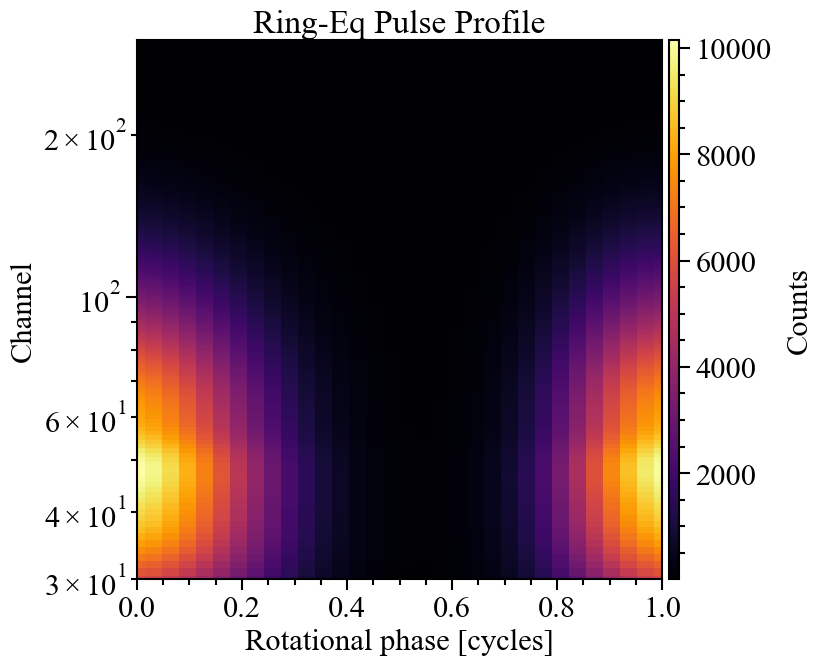

In [11]:
plot_pulse_profile(generate_pulse_profile(Ring_Eq_UltraXPSI), r'Counts', r'Ring-Eq Pulse Profile')

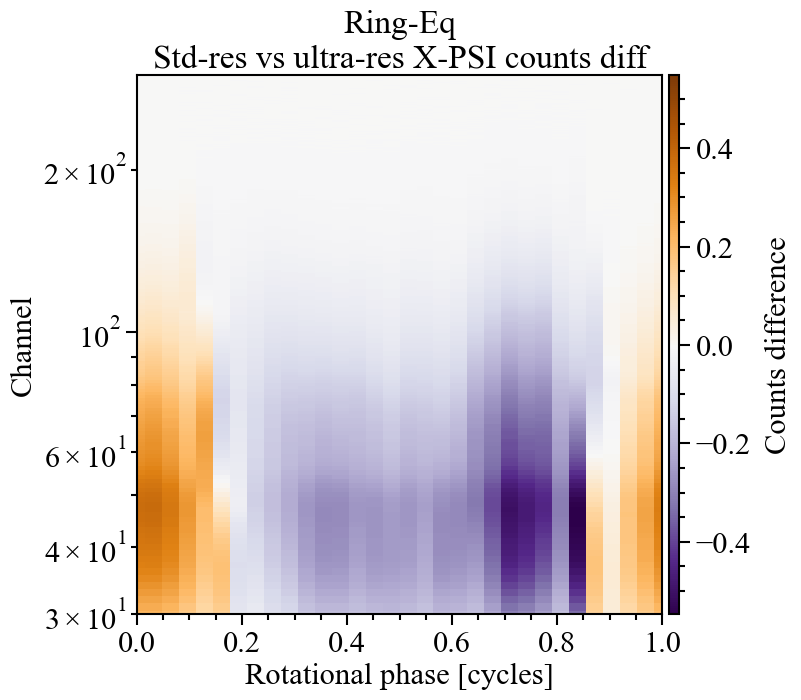

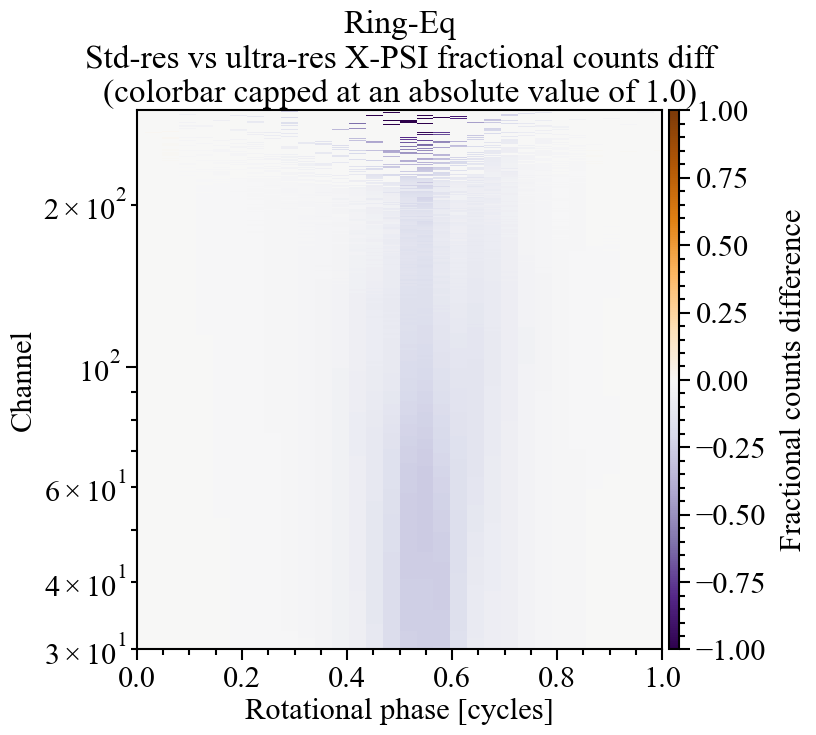

In [12]:
plot_pulse_profile(diff_Ring_Eq_UltraXPSI_and_StdXPSI_pulse_profile, 
                   r'Counts difference', r'Ring-Eq'+ '\n' + r'Std-res vs ultra-res X-PSI counts diff', 
                   norm='TwoSlope')  ## Figure 3

plot_pulse_profile(frac_diff_Ring_Eq_UltraXPSI_and_StdXPSI_pulse_profile, 
                   r'Fractional counts difference', r'Ring-Eq'+ '\n' + r'Std-res vs ultra-res X-PSI fractional counts diff'+ '\n' + r'(colorbar capped at an absolute value of 1.0)', 
                   norm='TwoSlope', maxcolor=-1.0)

### Figure 3

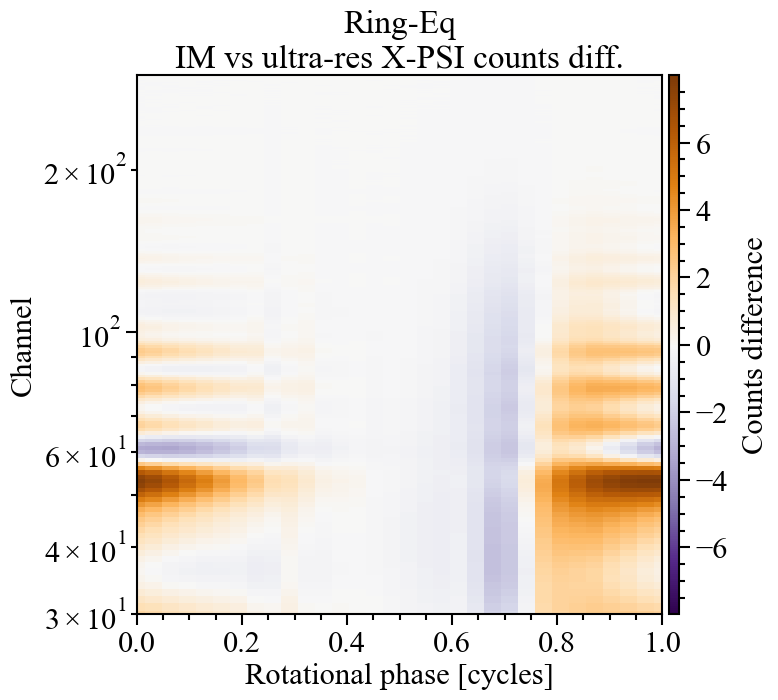

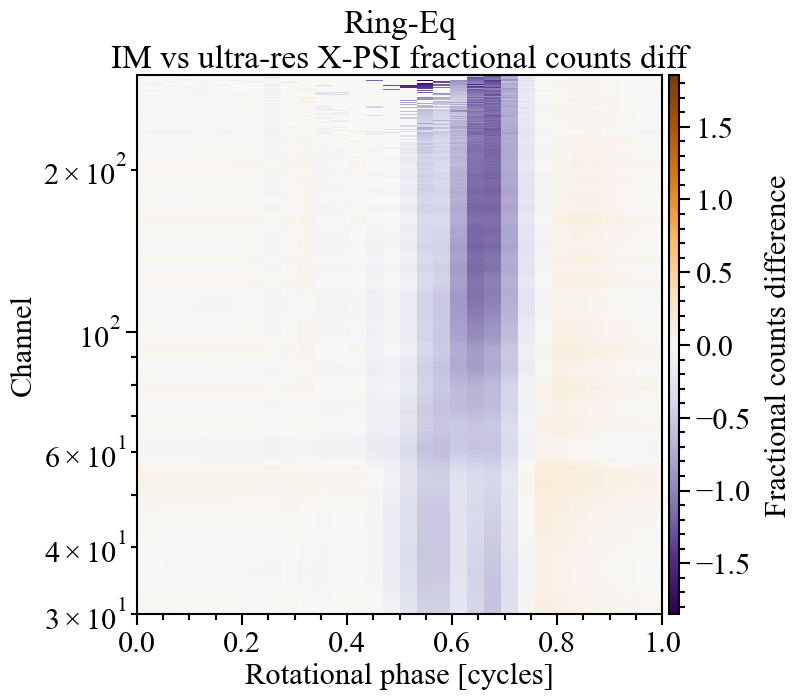

In [13]:
plot_pulse_profile(diff_Ring_Eq_UltraXPSI_and_IM_pulse_profile, 
                   r'Counts difference', r'Ring-Eq'+ '\n' + r'IM vs ultra-res X-PSI counts diff.', 
                   norm='TwoSlope')

plot_pulse_profile(frac_diff_Ring_Eq_UltraXPSI_and_IM_pulse_profile, 
                   r'Fractional counts difference', r'Ring-Eq'+ '\n' + r'IM vs ultra-res X-PSI fractional counts diff', 
                   norm='TwoSlope')

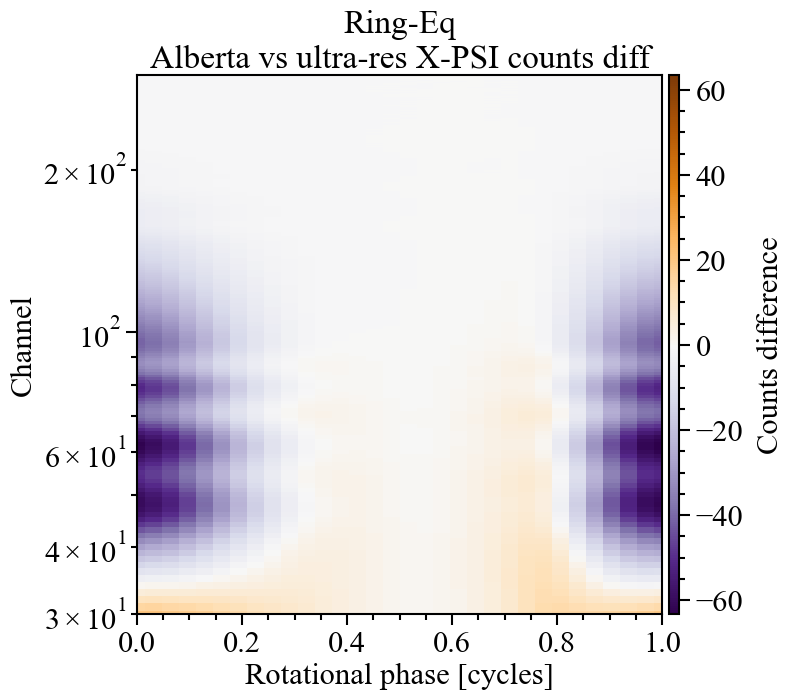

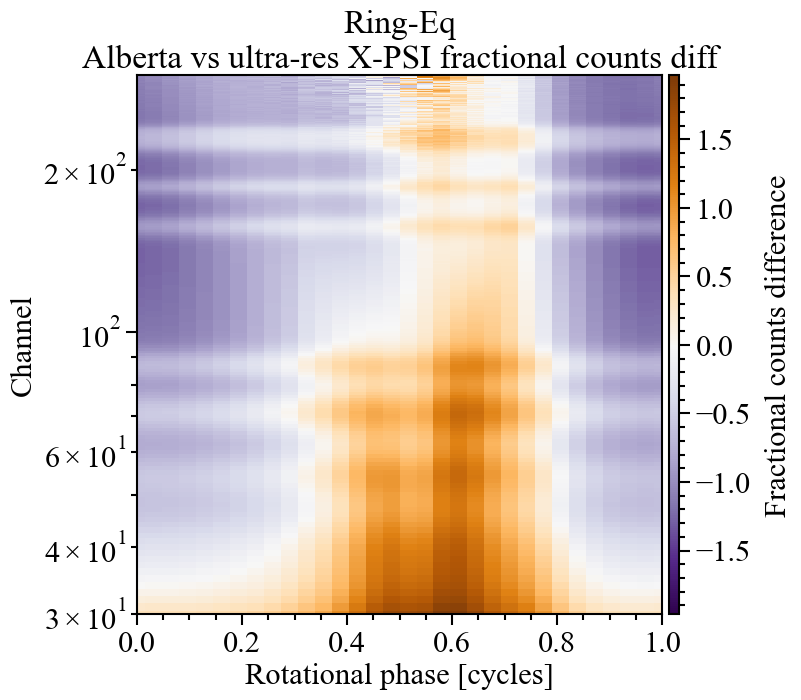

In [14]:
plot_pulse_profile(diff_Ring_Eq_UltraXPSI_and_Alberta_pulse_profile, 
                   r'Counts difference', r'Ring-Eq'+ '\n' + r'Alberta vs ultra-res X-PSI counts diff', 
                   norm='TwoSlope')

plot_pulse_profile(frac_diff_Ring_Eq_UltraXPSI_and_Alberta_pulse_profile, 
                   r'Fractional counts difference', r'Ring-Eq'+ '\n' + r'Alberta vs ultra-res X-PSI fractional counts diff', 
                   norm='TwoSlope')

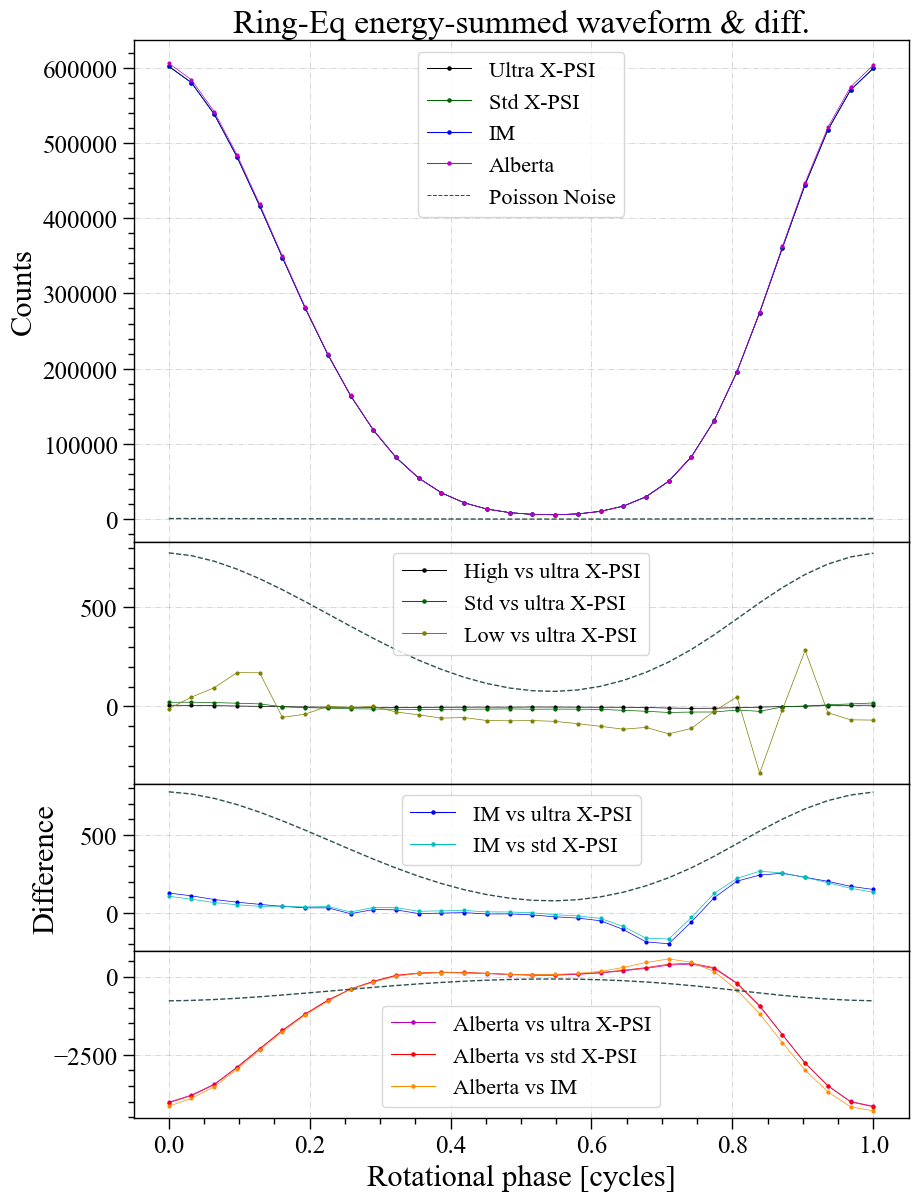

In [15]:
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(10, 14), sharex=True, gridspec_kw={'height_ratios': [3, 1.45, 1, 1]})

axes[0].plot(np.linspace(0.0, 1.0, 32), Ring_Eq_UltraXPSI_energy_summed, 'o-', color='k', lw=0.5, markersize=2, label='Ultra X-PSI')
axes[0].plot(np.linspace(0.0, 1.0, 32), Ring_Eq_StdXPSI_energy_summed, 'o-', color='darkgreen', lw=0.5, markersize=2, label='Std X-PSI')
axes[0].plot(np.linspace(0.0, 1.0, 32), Ring_Eq_IM_energy_summed, 'o-', color='b', lw=0.5, markersize=2, label='IM')
axes[0].plot(np.linspace(0.0, 1.0, 32), Ring_Eq_Alberta_energy_summed, 'o-', color='m', lw=0.5, markersize=2, label='Alberta')
axes[0].grid(linestyle="-.", color='grey',linewidth=0.7, alpha=0.3)
veneer(None, None, axes[0])
# legend_line_thickness(axes[0].legend())
axes[0].set_ylabel('Counts')
axes[0].set_title(r'Ring-Eq energy-summed waveform & diff.')

axes[1].plot(np.linspace(0.0, 1.0, 32), diff_Ring_Eq_UltraXPSI_and_HiXPSI, 'o-', color='k', lw=0.5, markersize=2, label='High vs ultra X-PSI')
axes[1].plot(np.linspace(0.0, 1.0, 32), diff_Ring_Eq_UltraXPSI_and_StdXPSI, 'o-', color='darkgreen', lw=0.5, markersize=2, label='Std vs ultra X-PSI')
axes[1].plot(np.linspace(0.0, 1.0, 32), diff_Ring_Eq_UltraXPSI_and_LowXPSI, 'o-', color='olive', lw=0.5, markersize=2, label='Low vs ultra X-PSI')
axes[1].grid(linestyle="-.", color='grey',linewidth=0.7, alpha=0.3)
veneer(None, None, axes[1])
# legend_line_thickness(axes[1].legend())

axes[2].plot(np.linspace(0.0, 1.0, 32), diff_Ring_Eq_UltraXPSI_and_IM, 'o-', color='b', lw=0.5, markersize=2, label='IM vs ultra X-PSI')
axes[2].plot(np.linspace(0.0, 1.0, 32), diff_Ring_Eq_StdXPSI_and_IM, 'o-', color='c', lw=0.5, markersize=2, label='IM vs std X-PSI')
axes[2].grid(linestyle="-.", color='grey',linewidth=0.7, alpha=0.3)
veneer(None, None, axes[2])
# legend_line_thickness(axes[2].legend())
axes[2].set_ylabel('Difference')
axes[2].yaxis.labelpad = 15     # Adjust axis label position

axes[3].plot(np.linspace(0.0, 1.0, 32), diff_Ring_Eq_UltraXPSI_and_Alberta, 'o-', color='m', lw=0.5, markersize=2, label='Alberta vs ultra X-PSI')
axes[3].plot(np.linspace(0.0, 1.0, 32), diff_Ring_Eq_StdXPSI_and_Alberta, 'o-', color='r', lw=0.5, markersize=2, label='Alberta vs std X-PSI')
axes[3].plot(np.linspace(0.0, 1.0, 32), diff_Ring_Eq_IM_and_Alberta, 'o-', color='darkorange', lw=0.5, markersize=2, label='Alberta vs IM')
axes[3].grid(linestyle="-.", color='grey',linewidth=0.7, alpha=0.3)
veneer(None, None, axes[3])
# legend_line_thickness(axes[3].legend())
axes[3].legend()
axes[3].set_xlabel('Rotational phase [cycles]')

axes[0].plot(np.linspace(0.0, 1.0, 32), np.sqrt(Ring_Eq_UltraXPSI_energy_summed), '--', color='darkslategrey', lw=1, markersize=2, label='Poisson Noise')
axes[1].plot(np.linspace(0.0, 1.0, 32), np.sqrt(Ring_Eq_UltraXPSI_energy_summed), '--', color='darkslategrey', lw=1, markersize=2)
axes[2].plot(np.linspace(0.0, 1.0, 32), np.sqrt(Ring_Eq_UltraXPSI_energy_summed), '--', color='darkslategrey', lw=1, markersize=2)
axes[3].plot(np.linspace(0.0, 1.0, 32), -np.sqrt(Ring_Eq_UltraXPSI_energy_summed), '--', color='darkslategrey', lw=1, markersize=2)
legend_line_thickness(axes[0].legend())
legend_line_thickness(axes[1].legend())
legend_line_thickness(axes[2].legend())
legend_line_thickness(axes[3].legend())

plt.subplots_adjust(hspace=0)

### Figure 4 left panel

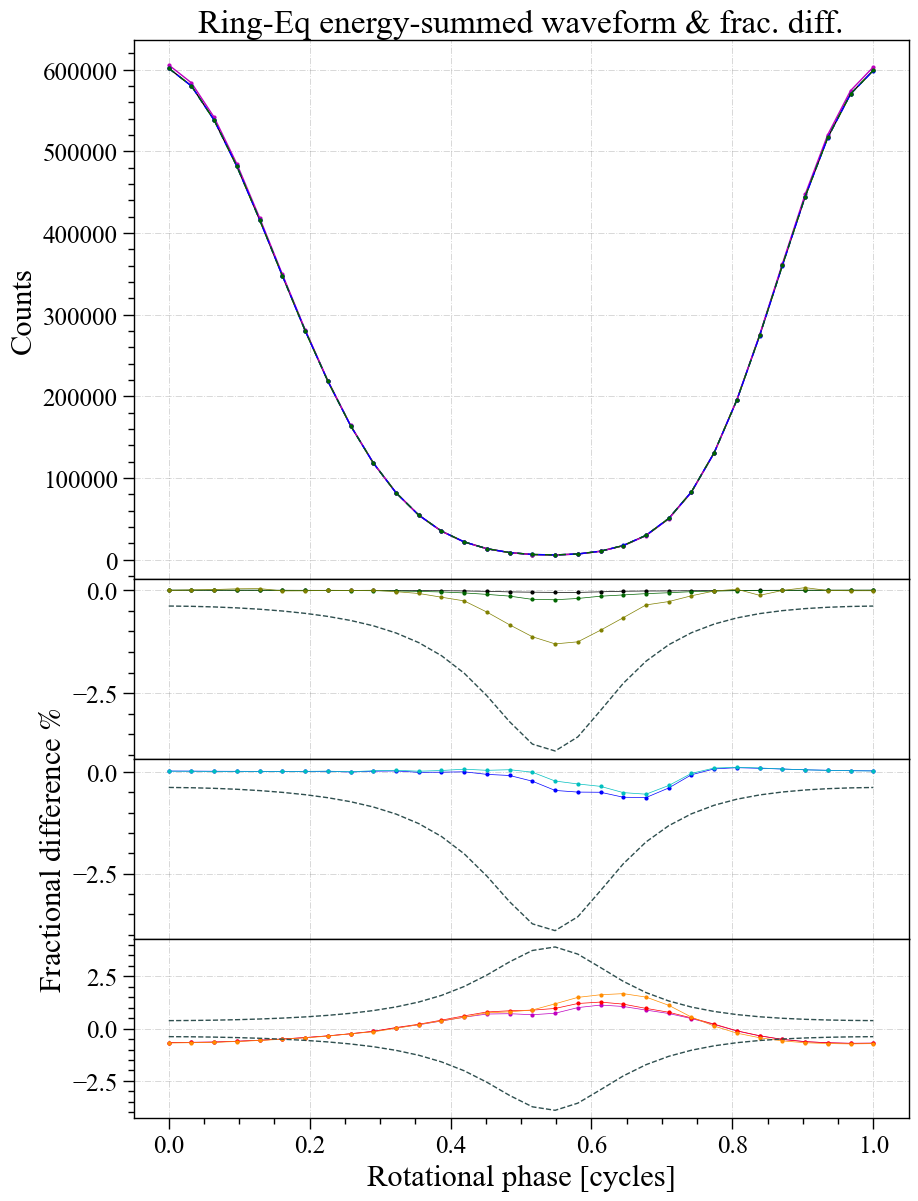

In [16]:
Ring_Eq_noise_norm = np.sum(Ring_Eq_UltraXPSI)/10**6
Ring_Eq_noise = (np.sqrt(Ring_Eq_UltraXPSI_energy_summed/Ring_Eq_noise_norm)/(Ring_Eq_UltraXPSI_energy_summed/Ring_Eq_noise_norm))*100

fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(10, 14), sharex=True, gridspec_kw={'height_ratios': [3, 1, 1, 1]})

axes[0].plot(np.linspace(0.0, 1.0, 32), Ring_Eq_UltraXPSI_energy_summed, 'o-', color='k', lw=1, markersize=2, label='Ultra X-PSI')
axes[0].plot(np.linspace(0.0, 1.0, 32), Ring_Eq_Alberta_energy_summed, 'o-', color='m', lw=1, markersize=2, label='Alberta')
axes[0].plot(np.linspace(0.0, 1.0, 32), Ring_Eq_IM_energy_summed, 'o--', dashes=(5, 2.5), color='b', lw=1, markersize=2, label='IM')
axes[0].plot(np.linspace(0.0, 1.0, 32), Ring_Eq_StdXPSI_energy_summed, 'o--', dashes=(5, 5), color='darkgreen', lw=1, markersize=2, label='Std X-PSI')
# axes[0].plot(np.linspace(0.0, 1.0, 32), np.sqrt(Ring_Eq_UltraXPSI_energy_summed), '--', color='darkslategrey', lw=1, markersize=2, label='Poisson Noise')
axes[0].grid(linestyle="-.", color='grey',linewidth=0.7, alpha=0.3)
veneer(None, None, axes[0])
# legend_line_thickness(axes[0].legend())
#axes[0].ticklabel_format(axis='y', style='sci', scilimits=(0,0))  # Scientific notation used for y-axis
axes[0].set_ylabel('Counts')
axes[0].set_title(r'Ring-Eq energy-summed waveform & frac. diff.')

axes[1].plot(np.linspace(0.0, 1.0, 32), frac_diff_Ring_Eq_UltraXPSI_and_HiXPSI, 'o-', color='k', lw=0.5, markersize=2, label='High vs ultra X-PSI')
axes[1].plot(np.linspace(0.0, 1.0, 32), frac_diff_Ring_Eq_UltraXPSI_and_StdXPSI, 'o-', color='darkgreen', lw=0.5, markersize=2, label='Std vs ultra X-PSI')
axes[1].plot(np.linspace(0.0, 1.0, 32), frac_diff_Ring_Eq_UltraXPSI_and_LowXPSI, 'o-', color='olive', lw=0.5, markersize=2, label='Low vs ultra X-PSI')
axes[1].plot(np.linspace(0.0, 1.0, 32), -Ring_Eq_noise, '--', color='darkslategrey', lw=1, markersize=2)
axes[1].grid(linestyle="-.", color='grey',linewidth=0.7, alpha=0.3)
veneer(None, None, axes[1])
# legend_line_thickness(axes[1].legend())
# axes[1].ticklabel_format(axis='y', style='sci', scilimits=(0,0))

axes[2].plot(np.linspace(0.0, 1.0, 32), frac_diff_Ring_Eq_UltraXPSI_and_IM, 'o-', color='b', lw=0.5, markersize=2, label='IM vs ultra X-PSI')
axes[2].plot(np.linspace(0.0, 1.0, 32), frac_diff_Ring_Eq_StdXPSI_and_IM, 'o-', color='c', lw=0.5, markersize=2, label='IM vs std X-PSI')
axes[2].plot(np.linspace(0.0, 1.0, 32), -Ring_Eq_noise, '--', color='darkslategrey', lw=1, markersize=2)
axes[2].grid(linestyle="-.", color='grey',linewidth=0.7, alpha=0.3)
veneer(None, None, axes[2])
# legend_line_thickness(axes[2].legend())
# axes[1].ticklabel_format(axis='y', style='sci', scilimits=(0,0))
axes[2].set_ylabel('Fractional difference $\%$')
# axes[2].yaxis.labelpad = 5     # Adjust axis label position

axes[3].plot(np.linspace(0.0, 1.0, 32), frac_diff_Ring_Eq_UltraXPSI_and_Alberta, 'o-', color='m', lw=0.5, markersize=2, label='Alberta vs ultra X-PSI')
axes[3].plot(np.linspace(0.0, 1.0, 32), frac_diff_Ring_Eq_StdXPSI_and_Alberta, 'o-', color='r', lw=0.5, markersize=2, label='Alberta vs std X-PSI')
axes[3].plot(np.linspace(0.0, 1.0, 32), frac_diff_Ring_Eq_IM_and_Alberta, 'o-', color='darkorange', lw=0.5, markersize=2, label='Alberta vs IM')
axes[3].plot(np.linspace(0.0, 1.0, 32), Ring_Eq_noise, '--', color='darkslategrey', lw=1, markersize=2)
axes[3].plot(np.linspace(0.0, 1.0, 32), -Ring_Eq_noise, '--', color='darkslategrey', lw=1, markersize=2)
axes[3].grid(linestyle="-.", color='grey',linewidth=0.7, alpha=0.3)
veneer(None, None, axes[3])
# legend_line_thickness(axes[3].legend(loc='upper left', framealpha=0.6))
#axes[3].ticklabel_format(axis='y', style='sci', scilimits=(0,0))
axes[3].set_xlabel('Rotational phase [cycles]')

plt.subplots_adjust(hspace=0)

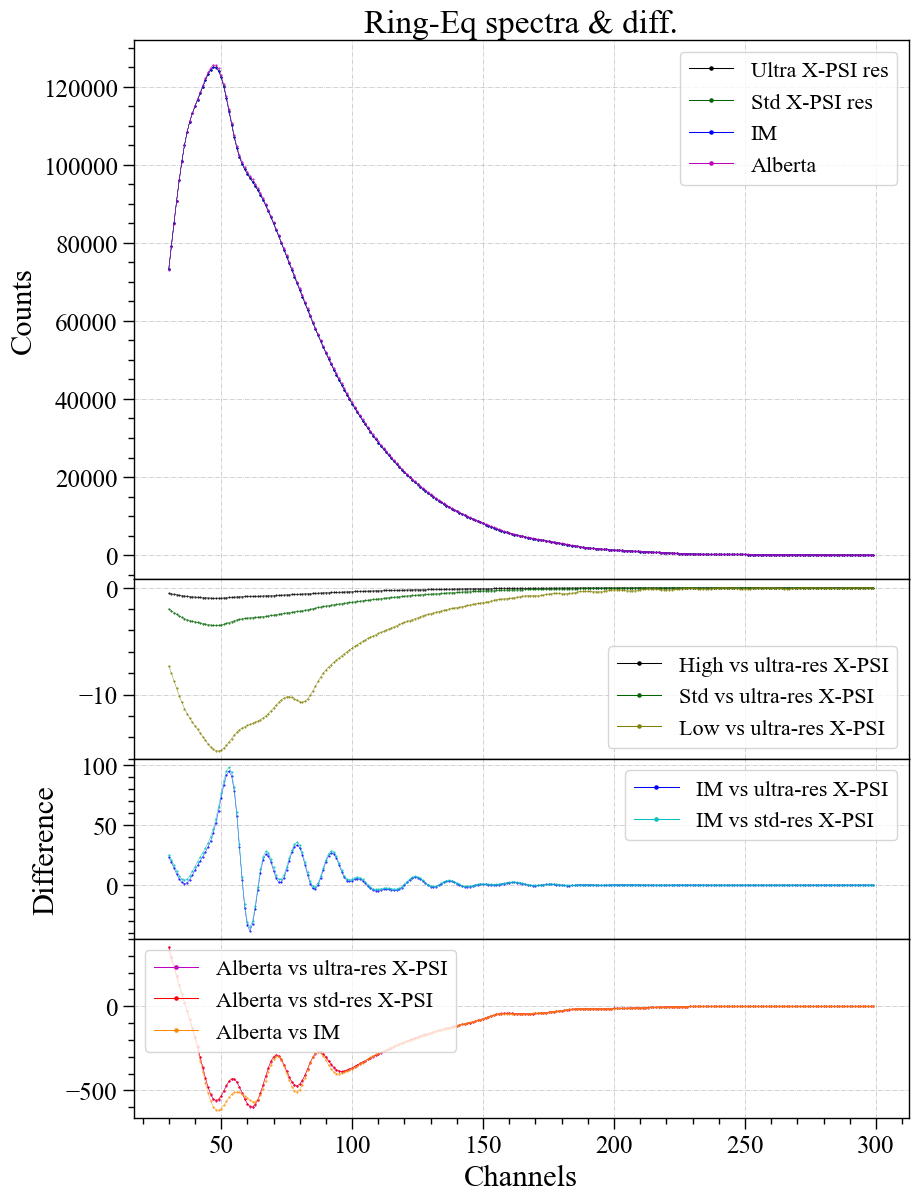

In [17]:
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(10, 14), sharex=True, gridspec_kw={'height_ratios': [3, 1, 1, 1]})

axes[0].plot(Ring_Eq_UltraXPSI_spectrum[:, 0], Ring_Eq_UltraXPSI_spectrum[:, 1], 'o-', color='k', lw=0.3, markersize=0.5, label='Ultra X-PSI res')
axes[0].plot(Ring_Eq_UltraXPSI_spectrum[:, 0], Ring_Eq_StdXPSI_spectrum[:, 1], 'o-', color='darkgreen', lw=0.3, markersize=0.5, label='Std X-PSI res')
axes[0].plot(Ring_Eq_UltraXPSI_spectrum[:, 0], Ring_Eq_IM_spectrum[:, 1], 'o-', color='b', lw=0.3, markersize=0.5, label='IM')
axes[0].plot(Ring_Eq_UltraXPSI_spectrum[:, 0], Ring_Eq_Alberta_spectrum[:, 1], 'o-', color='m', lw=0.3, markersize=0.5, label='Alberta')
axes[0].grid(linestyle="-.", color='grey',linewidth=0.5, alpha=0.5)
veneer(None, None, axes[0])
legend_line_thickness(axes[0].legend())
axes[0].set_ylabel('Counts')
axes[0].set_title(r'Ring-Eq spectra & diff.')

axes[1].plot(Ring_Eq_UltraXPSI_spectrum[:, 0], spec_diff_Ring_Eq_UltraXPSI_and_HiXPSI, 'o-', color='k', lw=0.3, markersize=0.5, label='High vs ultra-res X-PSI')
axes[1].plot(Ring_Eq_UltraXPSI_spectrum[:, 0], spec_diff_Ring_Eq_UltraXPSI_and_StdXPSI, 'o-', color='darkgreen', lw=0.3, markersize=0.5, label='Std vs ultra-res X-PSI')
axes[1].plot(Ring_Eq_UltraXPSI_spectrum[:, 0], spec_diff_Ring_Eq_UltraXPSI_and_LowXPSI, 'o-', color='olive', lw=0.3, markersize=0.5, label='Low vs ultra-res X-PSI')
axes[1].grid(linestyle="-.", color='grey',linewidth=0.5, alpha=0.5)
veneer(None, None, axes[1])
legend_line_thickness(axes[1].legend())

axes[2].plot(Ring_Eq_UltraXPSI_spectrum[:, 0], spec_diff_Ring_Eq_UltraXPSI_and_IM, 'o-', color='b', lw=0.3, markersize=0.5, label='IM vs ultra-res X-PSI')
axes[2].plot(Ring_Eq_UltraXPSI_spectrum[:, 0], spec_diff_Ring_Eq_StdXPSI_and_IM, 'o-', color='c', lw=0.3, markersize=0.5, label='IM vs std-res X-PSI')
axes[2].grid(linestyle="-.", color='grey',linewidth=0.5, alpha=0.5)
veneer(None, (10,50), axes[2])
legend_line_thickness(axes[2].legend())
axes[2].set_ylabel('Difference')
axes[2].yaxis.labelpad = 15     # Adjust axis label position

axes[3].plot(Ring_Eq_UltraXPSI_spectrum[:, 0], spec_diff_Ring_Eq_UltraXPSI_and_Alberta, 'o-', color='m', lw=0.3, markersize=0.5, label='Alberta vs ultra-res X-PSI')
axes[3].plot(Ring_Eq_UltraXPSI_spectrum[:, 0], spec_diff_Ring_Eq_StdXPSI_and_Alberta, 'o-', color='r', lw=0.3, markersize=0.5, label='Alberta vs std-res X-PSI')
axes[3].plot(Ring_Eq_UltraXPSI_spectrum[:, 0], spec_diff_Ring_Eq_IM_and_Alberta, 'o-', color='darkorange', lw=0.3, markersize=0.5, label='Alberta vs IM')
axes[3].grid(linestyle="-.", color='grey',linewidth=0.5, alpha=0.5)
veneer(None, None, axes[3])
legend_line_thickness(axes[3].legend())
axes[3].set_xlabel('Channels')

plt.subplots_adjust(hspace=0)

### Figure 4 right panel

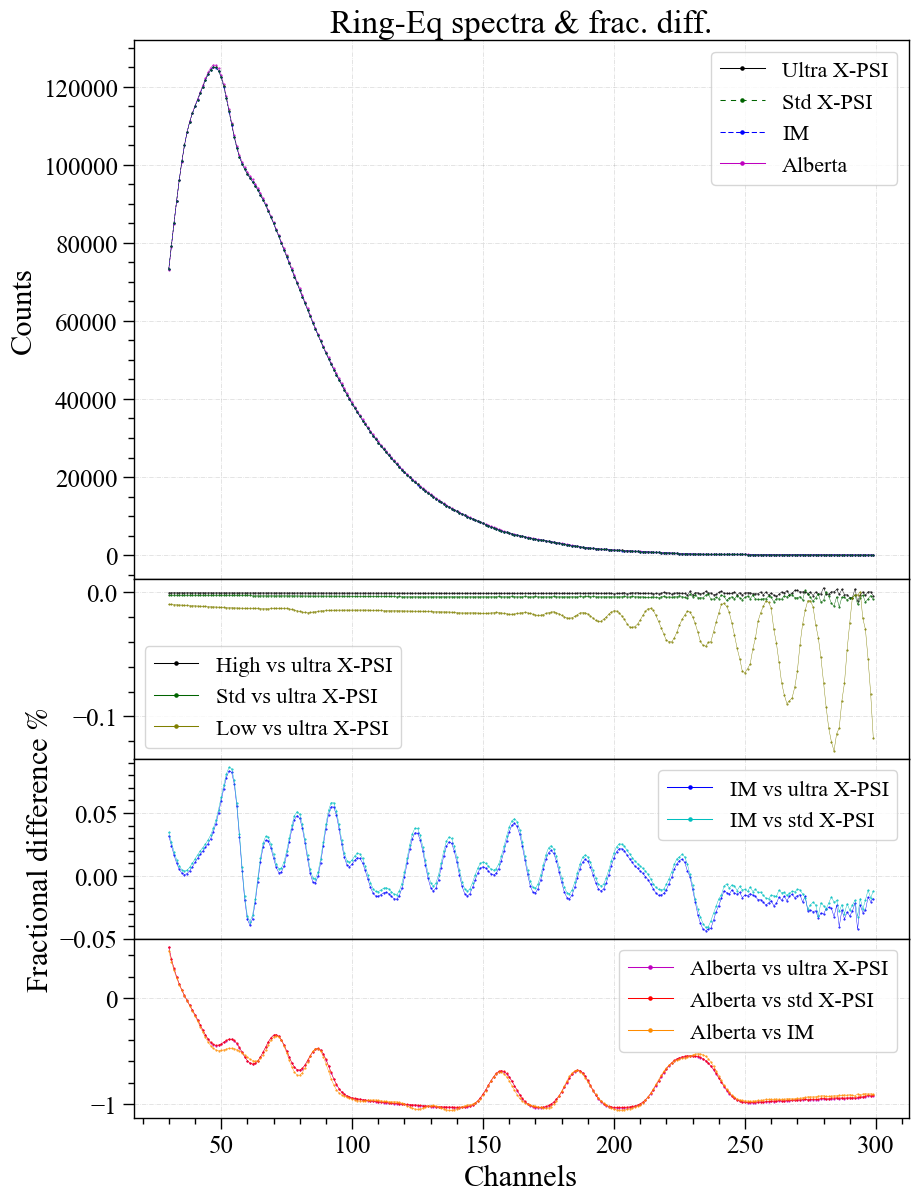

In [18]:
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(10, 14), sharex=True, gridspec_kw={'height_ratios': [3, 1, 1, 1]})

l1, = axes[0].plot(Ring_Eq_UltraXPSI_spectrum[:, 0], Ring_Eq_UltraXPSI_spectrum[:, 1], 'o-', color='k', lw=0.3, markersize=0.5, label='Ultra X-PSI')
l2, = axes[0].plot(Ring_Eq_UltraXPSI_spectrum[:, 0], Ring_Eq_Alberta_spectrum[:, 1], 'o-', color='m', lw=0.3, markersize=0.5, label='Alberta')
l3, = axes[0].plot(Ring_Eq_UltraXPSI_spectrum[:, 0], Ring_Eq_IM_spectrum[:, 1], 'o--', dashes=(5, 2.5), color='b', lw=0.3, markersize=0.5, label='IM')
l4, = axes[0].plot(Ring_Eq_UltraXPSI_spectrum[:, 0], Ring_Eq_StdXPSI_spectrum[:, 1], 'o--', dashes=(5, 5), color='darkgreen', lw=0.3, markersize=0.5, label='Std X-PSI')
axes[0].grid(linestyle="-.", color='grey',linewidth=0.5, alpha=0.3)
veneer(None, None, axes[0])
handles = [l1, l4, l3, l2]
labels = [line.get_label() for line in handles]
legend_line_thickness(axes[0].legend(handles, labels))
#axes[0].ticklabel_format(axis='y', style='sci', scilimits=(0,0))  # Scientific notation used for y-axis
axes[0].set_ylabel('Counts')
axes[0].set_title(r'Ring-Eq spectra & frac. diff.')

axes[1].plot(Ring_Eq_UltraXPSI_spectrum[:, 0], spec_frac_diff_Ring_Eq_UltraXPSI_and_HiXPSI, 'o-', color='k', lw=0.3, markersize=0.5, label='High vs ultra X-PSI')
axes[1].plot(Ring_Eq_UltraXPSI_spectrum[:, 0], spec_frac_diff_Ring_Eq_UltraXPSI_and_StdXPSI, 'o-', color='darkgreen', lw=0.3, markersize=0.5, label='Std vs ultra X-PSI')
axes[1].plot(Ring_Eq_UltraXPSI_spectrum[:, 0], spec_frac_diff_Ring_Eq_UltraXPSI_and_LowXPSI, 'o-', color='olive', lw=0.3, markersize=0.5, label='Low vs ultra X-PSI')
axes[1].grid(linestyle="-.", color='grey',linewidth=0.5, alpha=0.3)
#axes[1].ticklabel_format(axis='y', style='sci', scilimits=(0,0))  # Scientific notation used for y-axis
veneer(None, None, axes[1])
legend_line_thickness(axes[1].legend())

axes[2].plot(Ring_Eq_UltraXPSI_spectrum[:, 0], spec_frac_diff_Ring_Eq_UltraXPSI_and_IM, 'o-', color='b', lw=0.3, markersize=0.5, label='IM vs ultra X-PSI')
axes[2].plot(Ring_Eq_UltraXPSI_spectrum[:, 0], spec_frac_diff_Ring_Eq_StdXPSI_and_IM, 'o-', color='c', lw=0.3, markersize=0.5, label='IM vs std X-PSI')
axes[2].grid(linestyle="-.", color='grey',linewidth=0.5, alpha=0.3)
veneer(None, None, axes[2])
# Manually adjust yticklabels for axes[2] since it overlaps with axes[3]
# yticks_3 = axes[2].get_yticks()
# yticklabels_3 = ['' if i==0 or i==4 else label.get_text() for i, label in enumerate(axes[2].get_yticklabels())]
# axes[2].set_yticks(yticks_3)
# axes[2].set_yticklabels(yticklabels_3)
# axes[2].set_ylim(-0.0006)
legend_line_thickness(axes[2].legend())
#axes[2].ticklabel_format(axis='y', style='sci', scilimits=(-1,-1))  # Scientific notation used for y-axis
axes[2].set_ylabel('Fractional difference $\%$')
# axes[2].yaxis.labelpad = 3     # Adjust axis label position

axes[3].plot(Ring_Eq_UltraXPSI_spectrum[:, 0], spec_frac_diff_Ring_Eq_UltraXPSI_and_Alberta, 'o-', color='m', lw=0.3, markersize=0.5, label='Alberta vs ultra X-PSI')
axes[3].plot(Ring_Eq_UltraXPSI_spectrum[:, 0], spec_frac_diff_Ring_Eq_StdXPSI_and_Alberta, 'o-', color='r', lw=0.3, markersize=0.5, label='Alberta vs std X-PSI')
axes[3].plot(Ring_Eq_UltraXPSI_spectrum[:, 0], spec_frac_diff_Ring_Eq_IM_and_Alberta, 'o-', color='darkorange', lw=0.3, markersize=0.5, label='Alberta vs IM')
axes[3].grid(linestyle="-.", color='grey',linewidth=0.5, alpha=0.3)
veneer(None, None, axes[3])
legend_line_thickness(axes[3].legend())
axes[3].set_xlabel('Channels')

plt.subplots_adjust(hspace=0)

## Comparing Ring-polar

In [19]:
# Loading data from files
Ring_Polar_LowXPSI = np.loadtxt('./Pulse_profiles_by_diff_codes/XPSI/Low_res/Ring_Polar_expected_hreadable.dat')
Ring_Polar_StdXPSI = np.loadtxt('./Pulse_profiles_by_diff_codes/XPSI/Std_res/Ring_Polar_expected_hreadable.dat')
Ring_Polar_HiXPSI = np.loadtxt('./Pulse_profiles_by_diff_codes/XPSI/Hi_res/Ring_Polar_expected_hreadable.dat')
Ring_Polar_UltraXPSI = np.loadtxt('./Pulse_profiles_by_diff_codes/XPSI/Ultra_res/Ring_Polar_expected_hreadable.dat')
Ring_Polar_IM_full = np.loadtxt('./Pulse_profiles_by_diff_codes/IM/Ring_Polar.txt')
Ring_Polar_IM = Ring_Polar_IM_full[:, [0, 1, 3]]
Ring_Polar_Alberta_full = np.loadtxt('./Pulse_profiles_by_diff_codes/Alberta/Ring_Polar.txt')
Ring_Polar_Alberta = Ring_Polar_Alberta_full[0:8640, [0, 1, 2]]

# Energy summed waveforms
Ring_Polar_LowXPSI_energy_summed = generate_energy_summed_waveform(Ring_Polar_LowXPSI)
Ring_Polar_StdXPSI_energy_summed = generate_energy_summed_waveform(Ring_Polar_StdXPSI)
Ring_Polar_HiXPSI_energy_summed = generate_energy_summed_waveform(Ring_Polar_HiXPSI)
Ring_Polar_UltraXPSI_energy_summed = generate_energy_summed_waveform(Ring_Polar_UltraXPSI)
Ring_Polar_IM_energy_summed = generate_energy_summed_waveform(Ring_Polar_IM)
Ring_Polar_Alberta_energy_summed = generate_energy_summed_waveform(Ring_Polar_Alberta)

# Diff in energy summed waveforms
diff_Ring_Polar_UltraXPSI_and_LowXPSI = diff(Ring_Polar_UltraXPSI_energy_summed, Ring_Polar_LowXPSI_energy_summed)
diff_Ring_Polar_UltraXPSI_and_StdXPSI = diff(Ring_Polar_UltraXPSI_energy_summed, Ring_Polar_StdXPSI_energy_summed)
diff_Ring_Polar_UltraXPSI_and_HiXPSI = diff(Ring_Polar_UltraXPSI_energy_summed, Ring_Polar_HiXPSI_energy_summed)
diff_Ring_Polar_UltraXPSI_and_IM = diff(Ring_Polar_UltraXPSI_energy_summed, Ring_Polar_IM_energy_summed)
diff_Ring_Polar_StdXPSI_and_IM = diff(Ring_Polar_StdXPSI_energy_summed, Ring_Polar_IM_energy_summed)
diff_Ring_Polar_UltraXPSI_and_Alberta = diff(Ring_Polar_UltraXPSI_energy_summed, Ring_Polar_Alberta_energy_summed)
diff_Ring_Polar_StdXPSI_and_Alberta = diff(Ring_Polar_StdXPSI_energy_summed, Ring_Polar_Alberta_energy_summed)
diff_Ring_Polar_IM_and_Alberta = diff(Ring_Polar_IM_energy_summed, Ring_Polar_Alberta_energy_summed)

# Fractional diff in energy summed waveforms
frac_diff_Ring_Polar_UltraXPSI_and_LowXPSI = fractional_diff(Ring_Polar_UltraXPSI_energy_summed, Ring_Polar_LowXPSI_energy_summed)
frac_diff_Ring_Polar_UltraXPSI_and_StdXPSI = fractional_diff(Ring_Polar_UltraXPSI_energy_summed, Ring_Polar_StdXPSI_energy_summed)
frac_diff_Ring_Polar_UltraXPSI_and_HiXPSI = fractional_diff(Ring_Polar_UltraXPSI_energy_summed, Ring_Polar_HiXPSI_energy_summed)
frac_diff_Ring_Polar_UltraXPSI_and_IM = fractional_diff(Ring_Polar_UltraXPSI_energy_summed, Ring_Polar_IM_energy_summed)
frac_diff_Ring_Polar_StdXPSI_and_IM = fractional_diff(Ring_Polar_StdXPSI_energy_summed, Ring_Polar_IM_energy_summed)
frac_diff_Ring_Polar_UltraXPSI_and_Alberta = fractional_diff(Ring_Polar_UltraXPSI_energy_summed, Ring_Polar_Alberta_energy_summed)
frac_diff_Ring_Polar_StdXPSI_and_Alberta = fractional_diff(Ring_Polar_StdXPSI_energy_summed, Ring_Polar_Alberta_energy_summed)
frac_diff_Ring_Polar_IM_and_Alberta = fractional_diff(Ring_Polar_IM_energy_summed, Ring_Polar_Alberta_energy_summed)

# Spectra
Ring_Polar_LowXPSI_spectrum = generate_spectrum(Ring_Polar_LowXPSI)
Ring_Polar_StdXPSI_spectrum = generate_spectrum(Ring_Polar_StdXPSI)
Ring_Polar_HiXPSI_spectrum = generate_spectrum(Ring_Polar_HiXPSI)
Ring_Polar_UltraXPSI_spectrum = generate_spectrum(Ring_Polar_UltraXPSI)
Ring_Polar_IM_spectrum = generate_spectrum(Ring_Polar_IM)
Ring_Polar_Alberta_spectrum = generate_spectrum(Ring_Polar_Alberta)

# Diff in spectra
spec_diff_Ring_Polar_UltraXPSI_and_LowXPSI = diff(Ring_Polar_UltraXPSI_spectrum[:,1], Ring_Polar_LowXPSI_spectrum[:,1])
spec_diff_Ring_Polar_UltraXPSI_and_StdXPSI = diff(Ring_Polar_UltraXPSI_spectrum[:,1], Ring_Polar_StdXPSI_spectrum[:,1])
spec_diff_Ring_Polar_UltraXPSI_and_HiXPSI = diff(Ring_Polar_UltraXPSI_spectrum[:,1], Ring_Polar_HiXPSI_spectrum[:,1])
spec_diff_Ring_Polar_UltraXPSI_and_IM = diff(Ring_Polar_UltraXPSI_spectrum[:,1], Ring_Polar_IM_spectrum[:,1])
spec_diff_Ring_Polar_StdXPSI_and_IM = diff(Ring_Polar_StdXPSI_spectrum[:,1], Ring_Polar_IM_spectrum[:,1])
spec_diff_Ring_Polar_UltraXPSI_and_Alberta = diff(Ring_Polar_UltraXPSI_spectrum[:,1], Ring_Polar_Alberta_spectrum[:,1])
spec_diff_Ring_Polar_StdXPSI_and_Alberta = diff(Ring_Polar_StdXPSI_spectrum[:,1], Ring_Polar_Alberta_spectrum[:,1])
spec_diff_Ring_Polar_IM_and_Alberta = diff(Ring_Polar_IM_spectrum[:,1], Ring_Polar_Alberta_spectrum[:,1])

# Fractional diff in spectra
spec_frac_diff_Ring_Polar_UltraXPSI_and_LowXPSI = fractional_diff(Ring_Polar_UltraXPSI_spectrum[:,1], Ring_Polar_LowXPSI_spectrum[:,1])
spec_frac_diff_Ring_Polar_UltraXPSI_and_StdXPSI = fractional_diff(Ring_Polar_UltraXPSI_spectrum[:,1], Ring_Polar_StdXPSI_spectrum[:,1])
spec_frac_diff_Ring_Polar_UltraXPSI_and_HiXPSI = fractional_diff(Ring_Polar_UltraXPSI_spectrum[:,1], Ring_Polar_HiXPSI_spectrum[:,1])
spec_frac_diff_Ring_Polar_UltraXPSI_and_IM = fractional_diff(Ring_Polar_UltraXPSI_spectrum[:,1], Ring_Polar_IM_spectrum[:,1])
spec_frac_diff_Ring_Polar_StdXPSI_and_IM = fractional_diff(Ring_Polar_StdXPSI_spectrum[:,1], Ring_Polar_IM_spectrum[:,1])
spec_frac_diff_Ring_Polar_UltraXPSI_and_Alberta = fractional_diff(Ring_Polar_UltraXPSI_spectrum[:,1], Ring_Polar_Alberta_spectrum[:,1])
spec_frac_diff_Ring_Polar_StdXPSI_and_Alberta = fractional_diff(Ring_Polar_StdXPSI_spectrum[:,1], Ring_Polar_Alberta_spectrum[:,1])
spec_frac_diff_Ring_Polar_IM_and_Alberta = fractional_diff(Ring_Polar_IM_spectrum[:,1], Ring_Polar_Alberta_spectrum[:,1])

# Pulse profiles
Ring_Polar_LowXPSI_pulse_profile = generate_pulse_profile(Ring_Polar_LowXPSI)
Ring_Polar_StdXPSI_pulse_profile = generate_pulse_profile(Ring_Polar_StdXPSI)
Ring_Polar_HiXPSI_pulse_profile = generate_pulse_profile(Ring_Polar_HiXPSI)
Ring_Polar_UltraXPSI_pulse_profile = generate_pulse_profile(Ring_Polar_UltraXPSI)
Ring_Polar_IM_pulse_profile = generate_pulse_profile(Ring_Polar_IM)
Ring_Polar_Alberta_pulse_profile = generate_pulse_profile(Ring_Polar_Alberta)

# Difference in pulse profiles
diff_Ring_Polar_UltraXPSI_and_LowXPSI_pulse_profile = diff(Ring_Polar_UltraXPSI_pulse_profile, Ring_Polar_LowXPSI_pulse_profile)
diff_Ring_Polar_UltraXPSI_and_StdXPSI_pulse_profile = diff(Ring_Polar_UltraXPSI_pulse_profile, Ring_Polar_StdXPSI_pulse_profile)
diff_Ring_Polar_UltraXPSI_and_HiXPSI_pulse_profile = diff(Ring_Polar_UltraXPSI_pulse_profile, Ring_Polar_HiXPSI_pulse_profile)
diff_Ring_Polar_UltraXPSI_and_IM_pulse_profile = diff(Ring_Polar_UltraXPSI_pulse_profile, Ring_Polar_IM_pulse_profile)
diff_Ring_Polar_StdXPSI_and_IM_pulse_profile = diff(Ring_Polar_StdXPSI_pulse_profile, Ring_Polar_IM_pulse_profile)
diff_Ring_Polar_UltraXPSI_and_Alberta_pulse_profile = diff(Ring_Polar_UltraXPSI_pulse_profile, Ring_Polar_Alberta_pulse_profile)
diff_Ring_Polar_StdXPSI_and_Alberta_pulse_profile = diff(Ring_Polar_StdXPSI_pulse_profile, Ring_Polar_Alberta_pulse_profile)
diff_Ring_Polar_IM_and_Alberta_pulse_profile = diff(Ring_Polar_IM_pulse_profile, Ring_Polar_Alberta_pulse_profile)

# Fractional difference in pulse profiles when counts are above a certain counts threshold
frac_diff_Ring_Polar_UltraXPSI_and_LowXPSI_pulse_profile = fractional_diff(Ring_Polar_UltraXPSI_pulse_profile, Ring_Polar_LowXPSI_pulse_profile)
frac_diff_Ring_Polar_UltraXPSI_and_StdXPSI_pulse_profile = fractional_diff(Ring_Polar_UltraXPSI_pulse_profile, Ring_Polar_StdXPSI_pulse_profile)
frac_diff_Ring_Polar_UltraXPSI_and_HiXPSI_pulse_profile = fractional_diff(Ring_Polar_UltraXPSI_pulse_profile, Ring_Polar_HiXPSI_pulse_profile)
frac_diff_Ring_Polar_UltraXPSI_and_IM_pulse_profile = fractional_diff(Ring_Polar_UltraXPSI_pulse_profile, Ring_Polar_IM_pulse_profile)
frac_diff_Ring_Polar_StdXPSI_and_IM_pulse_profile = fractional_diff(Ring_Polar_StdXPSI_pulse_profile, Ring_Polar_IM_pulse_profile)
frac_diff_Ring_Polar_UltraXPSI_and_Alberta_pulse_profile = fractional_diff(Ring_Polar_UltraXPSI_pulse_profile, Ring_Polar_Alberta_pulse_profile)
frac_diff_Ring_Polar_StdXPSI_and_Alberta_pulse_profile = fractional_diff(Ring_Polar_StdXPSI_pulse_profile, Ring_Polar_Alberta_pulse_profile)
frac_diff_Ring_Polar_IM_and_Alberta_pulse_profile = fractional_diff(Ring_Polar_IM_pulse_profile, Ring_Polar_Alberta_pulse_profile)

# Max fractional differences for energy-summed waveforms
print('Max fractional difference for energy summed waveforms: \n')
print('\t X-PSI Ultra settings and Low settings:', np.max(np.abs(frac_diff_Ring_Polar_UltraXPSI_and_LowXPSI)))
print('\t X-PSI Ultra settings and Std settings:', np.max(np.abs(frac_diff_Ring_Polar_UltraXPSI_and_StdXPSI)))
print('\t X-PSI Ultra settings and High settings:', np.max(np.abs(frac_diff_Ring_Polar_UltraXPSI_and_HiXPSI)))
print('\t X-PSI Ultra settings and IM:', np.max(np.abs(frac_diff_Ring_Polar_UltraXPSI_and_IM)))
print('\t X-PSI Std settings and IM:', np.max(np.abs(frac_diff_Ring_Polar_StdXPSI_and_IM)))
print('\t X-PSI Ultra settings and Alberta:', np.max(np.abs(frac_diff_Ring_Polar_UltraXPSI_and_Alberta)))
print('\t X-PSI Std settings and Alberta:', np.max(np.abs(frac_diff_Ring_Polar_StdXPSI_and_Alberta)))
print('\t IM and Alberta:', np.max(np.abs(frac_diff_Ring_Polar_IM_and_Alberta)))

# Max fractional differences for spectra
print('\nMax fractional difference for spectra: \n')
print('\t X-PSI Ultra settings and Low settings:', np.max(np.abs(spec_frac_diff_Ring_Polar_UltraXPSI_and_LowXPSI)))
print('\t X-PSI Ultra settings and Std settings:', np.max(np.abs(spec_frac_diff_Ring_Polar_UltraXPSI_and_StdXPSI)))
print('\t X-PSI Ultra settings and High settings:', np.max(np.abs(spec_frac_diff_Ring_Polar_UltraXPSI_and_HiXPSI)))
print('\t X-PSI Ultra settings and IM:', np.max(np.abs(spec_frac_diff_Ring_Polar_UltraXPSI_and_IM)))
print('\t X-PSI Std settings and IM:', np.max(np.abs(spec_frac_diff_Ring_Polar_StdXPSI_and_IM)))
print('\t X-PSI Ultra settings and Alberta:', np.max(np.abs(spec_frac_diff_Ring_Polar_UltraXPSI_and_Alberta)))
print('\t X-PSI Std settings and Alberta:', np.max(np.abs(spec_frac_diff_Ring_Polar_StdXPSI_and_Alberta)))
print('\t IM and Alberta:', np.max(np.abs(spec_frac_diff_Ring_Polar_IM_and_Alberta)))

# Max fractional difference in pulse profiles
print('\nMax fractional difference for pulse profiles: \n')
print('\t X-PSI Ultra settings and Low settings:', np.max(np.abs(frac_diff_Ring_Polar_UltraXPSI_and_LowXPSI_pulse_profile)))
print('\t X-PSI Ultra settings and Std settings:', np.max(np.abs(frac_diff_Ring_Polar_UltraXPSI_and_StdXPSI_pulse_profile)))
print('\t X-PSI Ultra settings and High settings:', np.max(np.abs(frac_diff_Ring_Polar_UltraXPSI_and_HiXPSI_pulse_profile)))
print('\t X-PSI Ultra settings and IM:', np.max(np.abs(frac_diff_Ring_Polar_UltraXPSI_and_IM_pulse_profile)))
print('\t X-PSI Std settings and IM:', np.max(np.abs(frac_diff_Ring_Polar_StdXPSI_and_IM_pulse_profile)))
print('\t X-PSI Ultra settings and Alberta:', np.max(np.abs(frac_diff_Ring_Polar_UltraXPSI_and_Alberta_pulse_profile)))
print('\t IM and Alberta:', np.max(np.abs(frac_diff_Ring_Polar_StdXPSI_and_Alberta_pulse_profile)))

Max fractional difference for energy summed waveforms: 

	 X-PSI Ultra settings and Low settings: 0.0006444335061290394
	 X-PSI Ultra settings and Std settings: 0.00033730210140641966
	 X-PSI Ultra settings and High settings: 6.139887828570199e-05
	 X-PSI Ultra settings and IM: 0.040655151546799266
	 X-PSI Std settings and IM: 0.04083938372616834
	 X-PSI Ultra settings and Alberta: 0.41315845464140694
	 X-PSI Std settings and Alberta: 0.41337853048327744
	 IM and Alberta: 0.45360322930587593

Max fractional difference for spectra: 

	 X-PSI Ultra settings and Low settings: 1.5276145710928333
	 X-PSI Ultra settings and Std settings: 0.11750881316098719
	 X-PSI Ultra settings and High settings: 0.11750881316098719
	 X-PSI Ultra settings and IM: 0.2544529262086516
	 X-PSI Std settings and IM: 0.31786395422758384
	 X-PSI Ultra settings and Alberta: 2.1596357766203633
	 X-PSI Std settings and Alberta: 2.1596357766203633
	 IM and Alberta: 2.1596357766203633

Max fractional difference for pul

### Figure 2 top-right panel

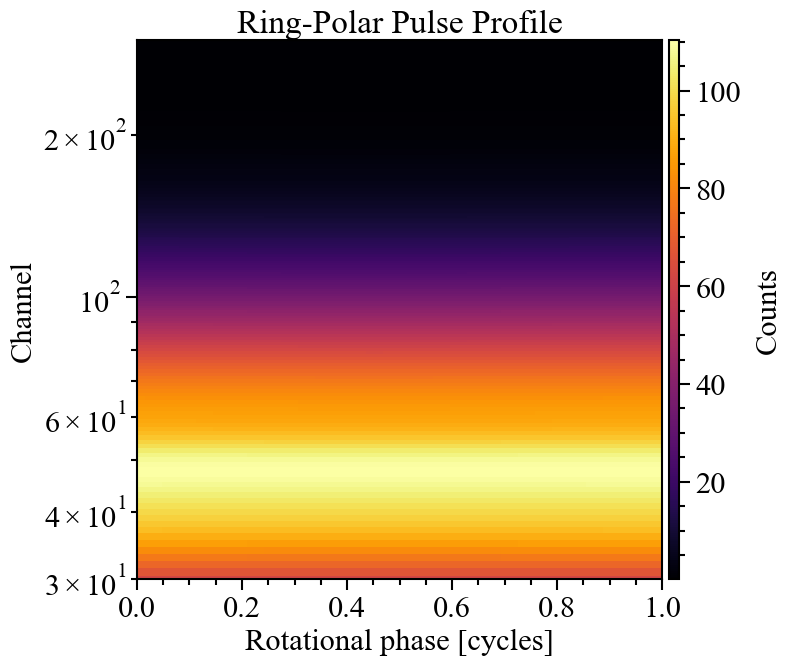

In [20]:
plot_pulse_profile(generate_pulse_profile(Ring_Polar_UltraXPSI), r'Counts', r'Ring-Polar Pulse Profile')

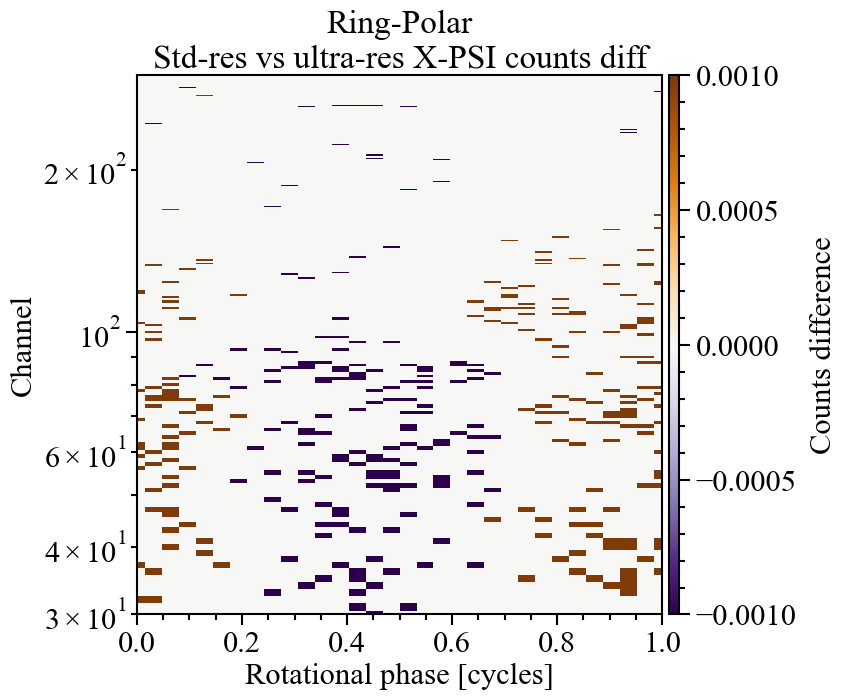

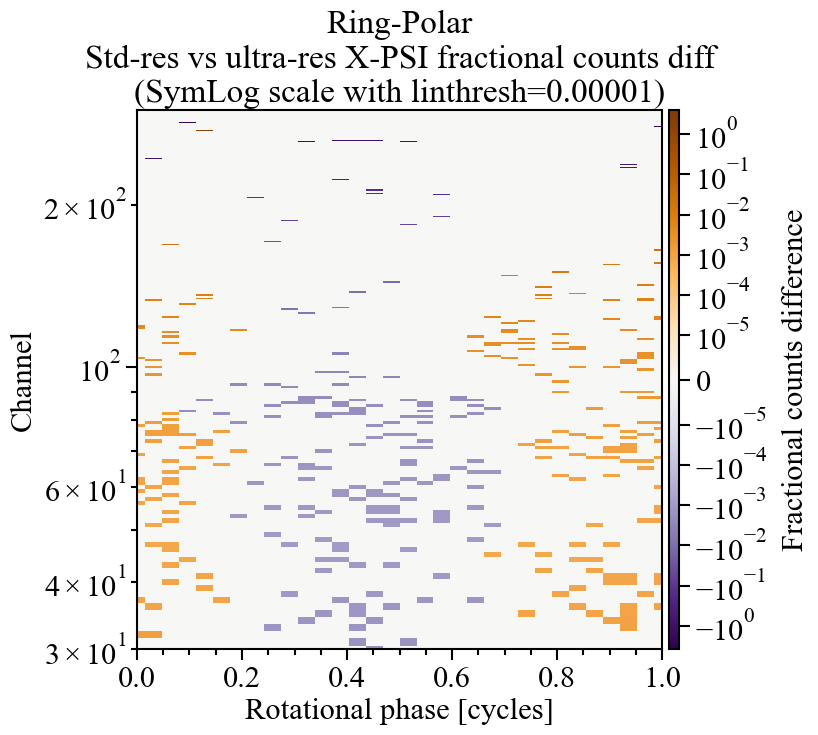

In [21]:
plot_pulse_profile(diff_Ring_Polar_UltraXPSI_and_StdXPSI_pulse_profile, 
                   r'Counts difference', r'Ring-Polar'+ '\n' + r'Std-res vs ultra-res X-PSI counts diff', 
                   norm='TwoSlope')

plot_pulse_profile(frac_diff_Ring_Polar_UltraXPSI_and_StdXPSI_pulse_profile, 
                   r'Fractional counts difference', r'Ring-Polar'+ '\n' + r'Std-res vs ultra-res X-PSI fractional counts diff'+ '\n' + r'(SymLog scale with linthresh=0.00001)', 
                   norm='SymLog', linthresh=0.00001)

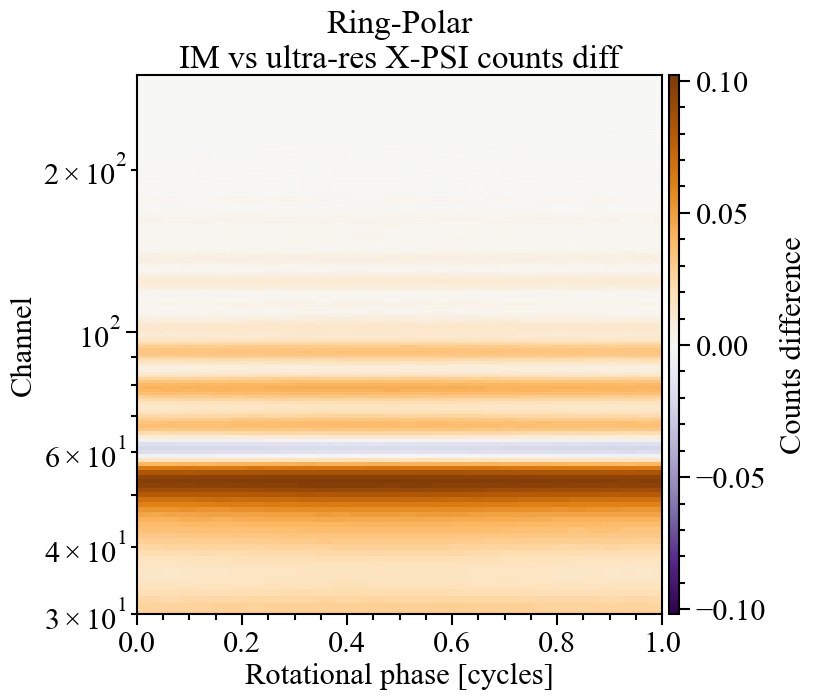

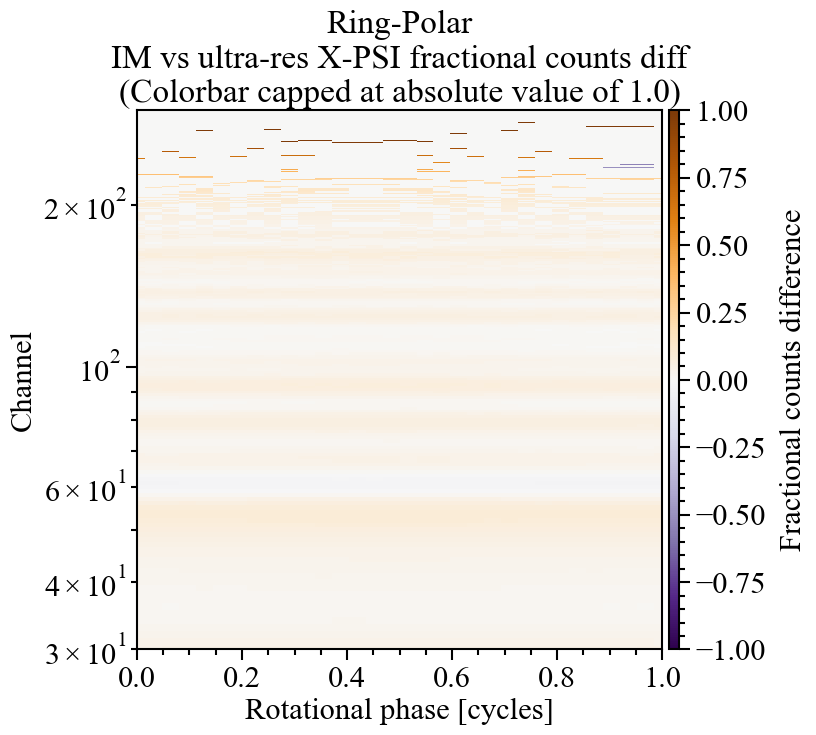

In [22]:
plot_pulse_profile(diff_Ring_Polar_UltraXPSI_and_IM_pulse_profile, 
                   r'Counts difference', r'Ring-Polar'+ '\n' + r'IM vs ultra-res X-PSI counts diff', 
                   norm='TwoSlope')

plot_pulse_profile(frac_diff_Ring_Polar_UltraXPSI_and_IM_pulse_profile, 
                   r'Fractional counts difference', r'Ring-Polar'+ '\n' + r'IM vs ultra-res X-PSI fractional counts diff' +'\n' + r'(Colorbar capped at absolute value of 1.0)', 
                   norm='TwoSlope', maxcolor=-1)

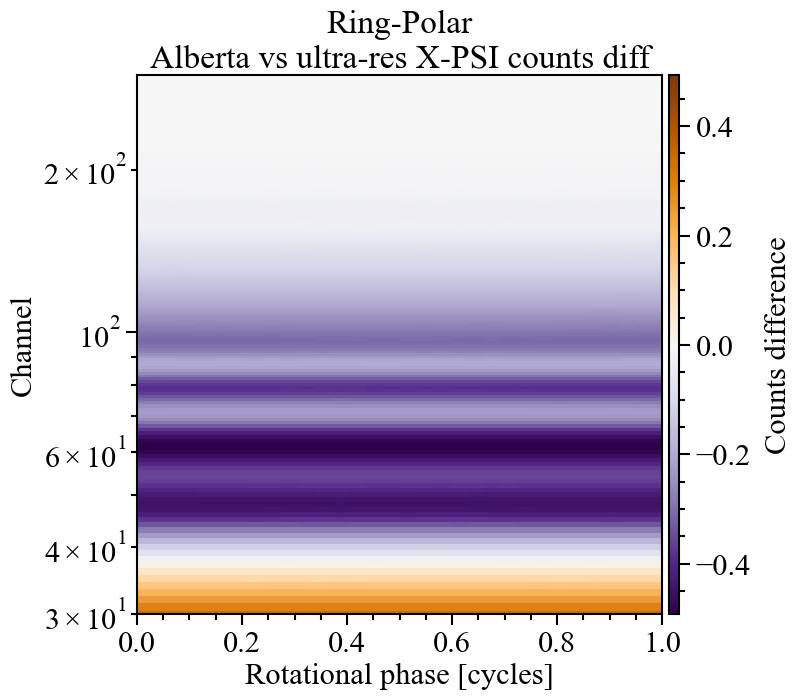

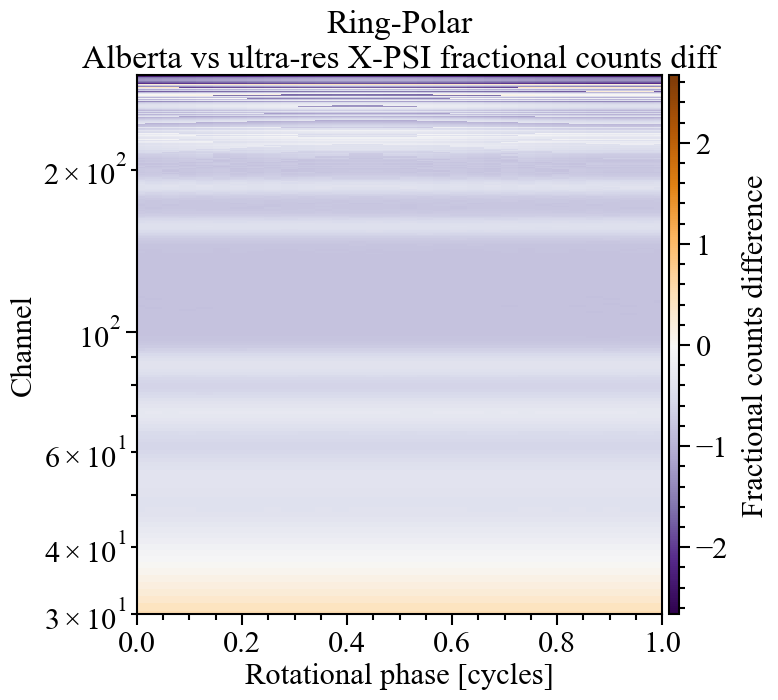

In [23]:
plot_pulse_profile(diff_Ring_Polar_UltraXPSI_and_Alberta_pulse_profile, 
                   r'Counts difference', r'Ring-Polar'+ '\n' + r'Alberta vs ultra-res X-PSI counts diff', 
                   norm='TwoSlope')

plot_pulse_profile(frac_diff_Ring_Polar_UltraXPSI_and_Alberta_pulse_profile, 
                   r'Fractional counts difference', r'Ring-Polar'+ '\n' + r'Alberta vs ultra-res X-PSI fractional counts diff', 
                   norm='TwoSlope')

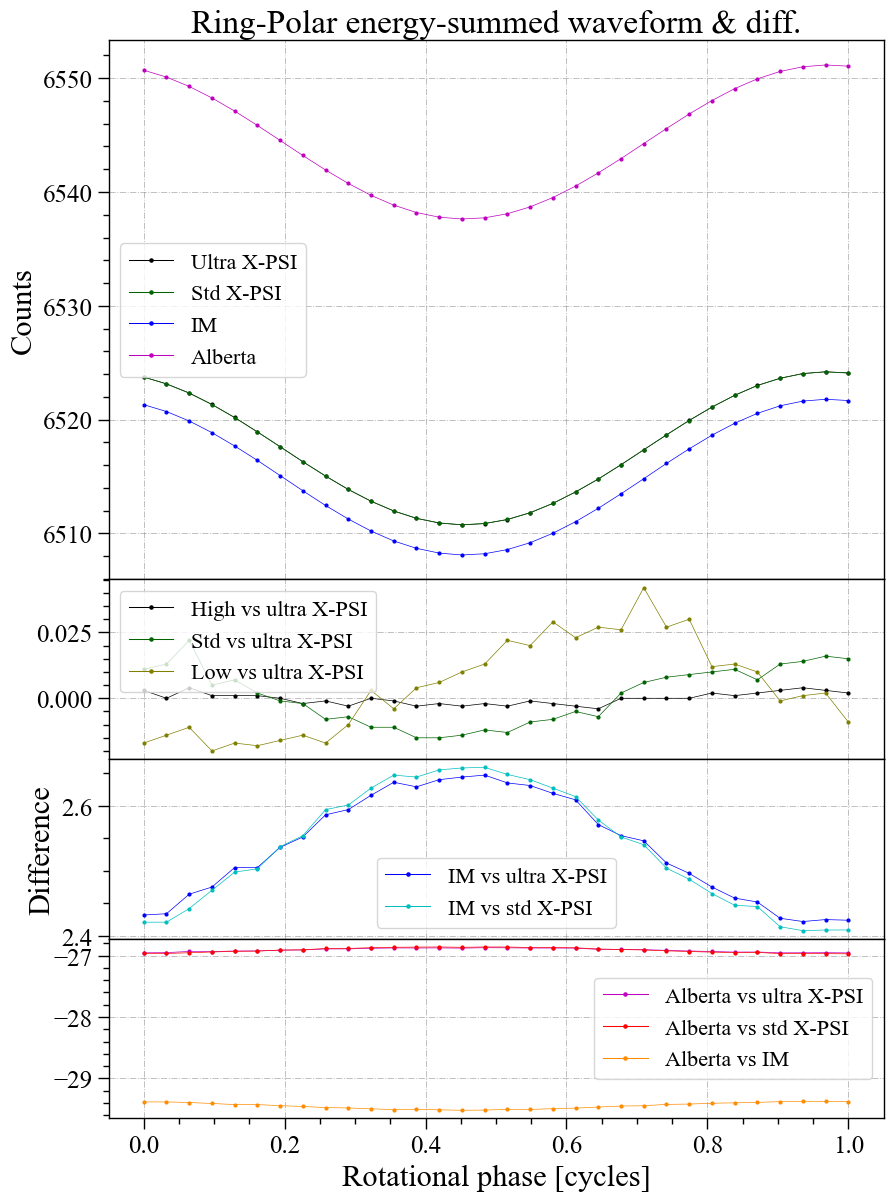

In [24]:
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(10, 14), sharex=True, gridspec_kw={'height_ratios': [3, 1, 1, 1]})

axes[0].plot(np.linspace(0.0, 1.0, 32), Ring_Polar_UltraXPSI_energy_summed, 'o-', color='k', lw=0.5, markersize=2, label='Ultra X-PSI')
axes[0].plot(np.linspace(0.0, 1.0, 32), Ring_Polar_StdXPSI_energy_summed, 'o-', color='darkgreen', lw=0.5, markersize=2, label='Std X-PSI')
axes[0].plot(np.linspace(0.0, 1.0, 32), Ring_Polar_IM_energy_summed, 'o-', color='b', lw=0.5, markersize=2, label='IM')
axes[0].plot(np.linspace(0.0, 1.0, 32), Ring_Polar_Alberta_energy_summed, 'o-', color='m', lw=0.5, markersize=2, label='Alberta')
axes[0].grid(linestyle="-.", color='grey',linewidth=0.7, alpha=0.5)
veneer(None, None, axes[0])
# legend_line_thickness(axes[0].legend())
axes[0].set_ylabel('Counts')
axes[0].set_title(r'Ring-Polar energy-summed waveform & diff.')

axes[1].plot(np.linspace(0.0, 1.0, 32), diff_Ring_Polar_UltraXPSI_and_HiXPSI, 'o-', color='k', lw=0.5, markersize=2, label='High vs ultra X-PSI')
axes[1].plot(np.linspace(0.0, 1.0, 32), diff_Ring_Polar_UltraXPSI_and_StdXPSI, 'o-', color='darkgreen', lw=0.5, markersize=2, label='Std vs ultra X-PSI')
axes[1].plot(np.linspace(0.0, 1.0, 32), diff_Ring_Polar_UltraXPSI_and_LowXPSI, 'o-', color='olive', lw=0.5, markersize=2, label='Low vs ultra X-PSI')
axes[1].grid(linestyle="-.", color='grey',linewidth=0.7, alpha=0.5)
veneer(None, None, axes[1])
# legend_line_thickness(axes[1].legend())
#axes[1].ticklabel_format(axis='y', style='sci', scilimits=(0,0))  # Scientific notation used for y-axis

axes[2].plot(np.linspace(0.0, 1.0, 32), diff_Ring_Polar_UltraXPSI_and_IM, 'o-', color='b', lw=0.5, markersize=2, label='IM vs ultra X-PSI')
axes[2].plot(np.linspace(0.0, 1.0, 32), diff_Ring_Polar_StdXPSI_and_IM, 'o-', color='c', lw=0.5, markersize=2, label='IM vs std X-PSI')
axes[2].grid(linestyle="-.", color='grey',linewidth=0.7, alpha=0.5)
veneer(None, None, axes[2])
# legend_line_thickness(axes[2].legend())
#axes[2].ticklabel_format(axis='y', style='sci', scilimits=(0,0))  # Scientific notation used for y-axis
axes[2].set_ylabel('Difference')
# axes[2].yaxis.labelpad = 25     # Adjust axis label position

axes[3].plot(np.linspace(0.0, 1.0, 32), diff_Ring_Polar_UltraXPSI_and_Alberta, 'o-', color='m', lw=0.5, markersize=2, label='Alberta vs ultra X-PSI')
axes[3].plot(np.linspace(0.0, 1.0, 32), diff_Ring_Polar_StdXPSI_and_Alberta, 'o-', color='r', lw=0.5, markersize=2, label='Alberta vs std X-PSI')
axes[3].plot(np.linspace(0.0, 1.0, 32), diff_Ring_Polar_IM_and_Alberta, 'o-', color='darkorange', lw=0.5, markersize=2, label='Alberta vs IM')
axes[3].grid(linestyle="-.", color='grey',linewidth=0.7, alpha=0.5)
veneer(None, None, axes[3])
# legend_line_thickness(axes[3].legend())
# axes[3].ticklabel_format(axis='y', style='sci', scilimits=(0,0))  # Scientific notation used for y-axis
axes[3].set_xlabel('Rotational phase [cycles]')

# axes[0].plot(np.linspace(0.0, 1.0, 32), np.sqrt(Ring_Polar_UltraXPSI_energy_summed), '--', color='darkslategrey', lw=1, markersize=2, label='Poisson Noise')
# axes[1].plot(np.linspace(0.0, 1.0, 32), np.sqrt(Ring_Polar_UltraXPSI_energy_summed), '--', color='darkslategrey', lw=1, markersize=2)
# axes[2].plot(np.linspace(0.0, 1.0, 32), np.sqrt(Ring_Polar_UltraXPSI_energy_summed), '--', color='darkslategrey', lw=1, markersize=2)
# axes[3].plot(np.linspace(0.0, 1.0, 32), np.sqrt(Ring_Polar_UltraXPSI_energy_summed), '--', color='darkslategrey', lw=1, markersize=2)
legend_line_thickness(axes[0].legend())
legend_line_thickness(axes[1].legend())
legend_line_thickness(axes[2].legend())
legend_line_thickness(axes[3].legend())


plt.subplots_adjust(hspace=0)

### Figure 5 left panel

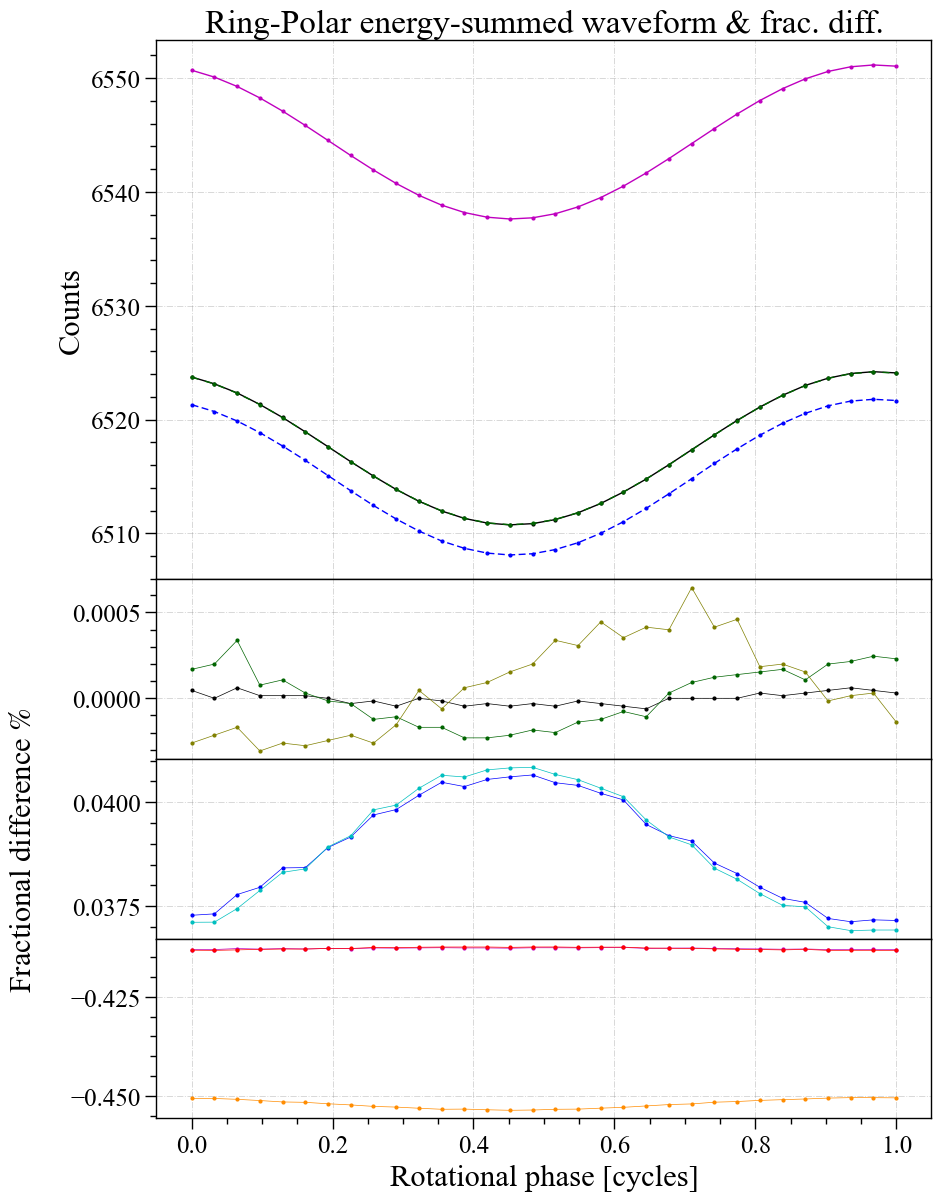

In [25]:
Ring_Polar_noise_norm = np.sum(Ring_Polar_UltraXPSI)/10**6
Ring_Polar_noise = (np.sqrt(Ring_Polar_UltraXPSI_energy_summed/Ring_Polar_noise_norm)/(Ring_Polar_UltraXPSI_energy_summed/Ring_Polar_noise_norm))*100

# Ring_Polar_noise = (np.sqrt(Ring_Polar_UltraXPSI_energy_summed)/Ring_Polar_UltraXPSI_energy_summed)*100

fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(10, 14), sharex=True, gridspec_kw={'height_ratios': [3, 1, 1, 1]})

axes[0].plot(np.linspace(0.0, 1.0, 32), Ring_Polar_UltraXPSI_energy_summed, 'o-', color='k', lw=1, markersize=2, label='Ultra X-PSI')
axes[0].plot(np.linspace(0.0, 1.0, 32), Ring_Polar_Alberta_energy_summed, 'o-', color='m', lw=1, markersize=2, label='Alberta')
axes[0].plot(np.linspace(0.0, 1.0, 32), Ring_Polar_IM_energy_summed, 'o--', dashes=(5, 2.5), color='b', lw=1, markersize=2, label='IM')
axes[0].plot(np.linspace(0.0, 1.0, 32), Ring_Polar_StdXPSI_energy_summed, 'o--', dashes=(5, 5), color='darkgreen', lw=1, markersize=2, label='Std X-PSI')
axes[0].grid(linestyle="-.", color='grey',linewidth=0.7, alpha=0.3)
veneer(None, None, axes[0])
# legend_line_thickness(axes[0].legend(loc='lower right'))
#axes[0].ticklabel_format(axis='y', style='sci', scilimits=(0,0))  # Scientific notation used for y-axis
axes[0].set_ylabel('Counts')
axes[0].set_title(r'Ring-Polar energy-summed waveform & frac. diff.')

axes[1].plot(np.linspace(0.0, 1.0, 32), frac_diff_Ring_Polar_UltraXPSI_and_HiXPSI, 'o-', color='k', lw=0.5, markersize=2, label='High vs ultra X-PSI')
axes[1].plot(np.linspace(0.0, 1.0, 32), frac_diff_Ring_Polar_UltraXPSI_and_StdXPSI, 'o-', color='darkgreen', lw=0.5, markersize=2, label='Std vs ultra X-PSI')
axes[1].plot(np.linspace(0.0, 1.0, 32), frac_diff_Ring_Polar_UltraXPSI_and_LowXPSI, 'o-', color='olive', lw=0.5, markersize=2, label='Low vs ultra X-PSI')
# axes[1].plot(np.linspace(0.0, 1.0, 32), Ring_Polar_noise, '--', color='darkslategrey', lw=1, markersize=2)
axes[1].grid(linestyle="-.", color='grey',linewidth=0.7, alpha=0.3)
veneer(None, None, axes[1])
# legend_line_thickness(axes[1].legend(loc='upper left'))
#axes[1].ticklabel_format(axis='y', style='sci', scilimits=(0,0))  # Scientific notation used for y-axis

axes[2].plot(np.linspace(0.0, 1.0, 32), frac_diff_Ring_Polar_UltraXPSI_and_IM, 'o-', color='b', lw=0.5, markersize=2, label='IM vs ultra X-PSI')
axes[2].plot(np.linspace(0.0, 1.0, 32), frac_diff_Ring_Polar_StdXPSI_and_IM, 'o-', color='c', lw=0.5, markersize=2, label='IM vs std X-PSI')
# axes[2].plot(np.linspace(0.0, 1.0, 32), Ring_Polar_noise, '--', color='darkslategrey', lw=1, markersize=2)
axes[2].grid(linestyle="-.", color='grey',linewidth=0.7, alpha=0.3)
veneer(None, None, axes[2])
# legend_line_thickness(axes[2].legend())
axes[2].set_ylabel('Fractional difference $\%$')
#axes[2].ticklabel_format(axis='y', style='sci', scilimits=(0,0))  # Scientific notation used for y-axis
axes[2].yaxis.labelpad = 25     # Adjust axis label position

axes[3].plot(np.linspace(0.0, 1.0, 32), frac_diff_Ring_Polar_UltraXPSI_and_Alberta, 'o-', color='m', lw=0.5, markersize=2, label='Alberta vs ultra X-PSI')
axes[3].plot(np.linspace(0.0, 1.0, 32), frac_diff_Ring_Polar_StdXPSI_and_Alberta, 'o-', color='r', lw=0.5, markersize=2, label='Alberta vs std X-PSI')
axes[3].plot(np.linspace(0.0, 1.0, 32), frac_diff_Ring_Polar_IM_and_Alberta, 'o-', color='darkorange', lw=0.5, markersize=2, label='Alberta vs IM')
# axes[3].plot(np.linspace(0.0, 1.0, 32), -Ring_Polar_noise, '--', color='darkslategrey', lw=1, markersize=2)
axes[3].grid(linestyle="-.", color='grey',linewidth=0.7, alpha=0.3)
# axes[3].set_yscale('log')
veneer(None, None, axes[3])
# legend_line_thickness(axes[3].legend())
#axes[3].ticklabel_format(axis='y', style='sci', scilimits=(0,0))  # Scientific notation used for y-axis
axes[3].set_xlabel('Rotational phase [cycles]')

plt.subplots_adjust(hspace=0)

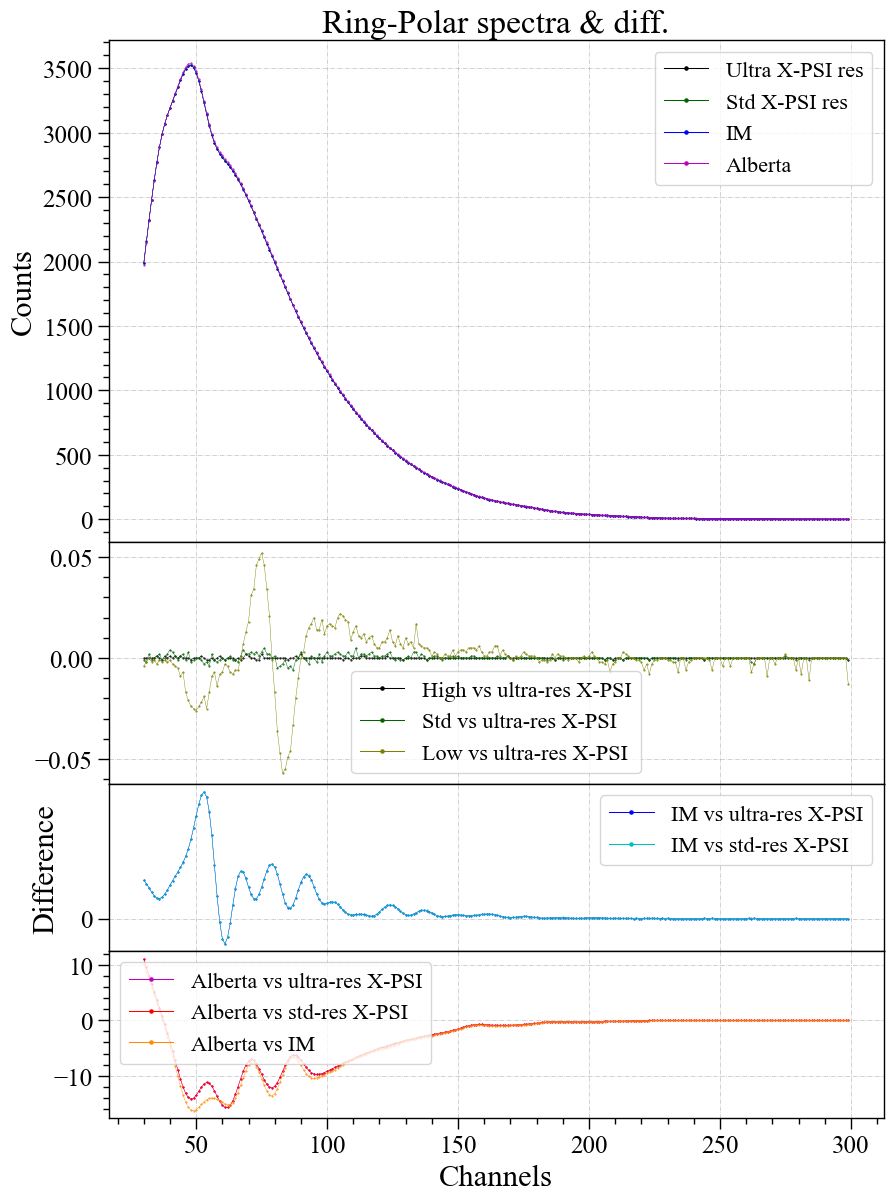

In [26]:
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(10, 14), sharex=True, gridspec_kw={'height_ratios': [3, 1.45, 1, 1]})

axes[0].plot(Ring_Polar_UltraXPSI_spectrum[:, 0], Ring_Polar_UltraXPSI_spectrum[:, 1], 'o-', color='k', lw=0.3, markersize=0.5, label='Ultra X-PSI res')
axes[0].plot(Ring_Polar_UltraXPSI_spectrum[:, 0], Ring_Polar_StdXPSI_spectrum[:, 1], 'o-', color='darkgreen', lw=0.3, markersize=0.5, label='Std X-PSI res')
axes[0].plot(Ring_Polar_UltraXPSI_spectrum[:, 0], Ring_Polar_IM_spectrum[:, 1], 'o-', color='b', lw=0.3, markersize=0.5, label='IM')
axes[0].plot(Ring_Polar_UltraXPSI_spectrum[:, 0], Ring_Polar_Alberta_spectrum[:, 1], 'o-', color='m', lw=0.3, markersize=0.5, label='Alberta')
axes[0].grid(linestyle="-.", color='grey',linewidth=0.5, alpha=0.5)
veneer(None, None, axes[0])
legend_line_thickness(axes[0].legend())
axes[0].set_ylabel('Counts')
axes[0].set_title(r'Ring-Polar spectra & diff.')

axes[1].plot(Ring_Polar_UltraXPSI_spectrum[:, 0], spec_diff_Ring_Polar_UltraXPSI_and_HiXPSI, 'o-', color='k', lw=0.3, markersize=0.5, label='High vs ultra-res X-PSI')
axes[1].plot(Ring_Polar_UltraXPSI_spectrum[:, 0], spec_diff_Ring_Polar_UltraXPSI_and_StdXPSI, 'o-', color='darkgreen', lw=0.3, markersize=0.5, label='Std vs ultra-res X-PSI')
axes[1].plot(Ring_Polar_UltraXPSI_spectrum[:, 0], spec_diff_Ring_Polar_UltraXPSI_and_LowXPSI, 'o-', color='olive', lw=0.3, markersize=0.5, label='Low vs ultra-res X-PSI')
axes[1].grid(linestyle="-.", color='grey',linewidth=0.5, alpha=0.5)
veneer(None, None, axes[1])
legend_line_thickness(axes[1].legend())

axes[2].plot(Ring_Polar_UltraXPSI_spectrum[:, 0], spec_diff_Ring_Polar_UltraXPSI_and_IM, 'o-', color='b', lw=0.3, markersize=0.5, label='IM vs ultra-res X-PSI')
axes[2].plot(Ring_Polar_UltraXPSI_spectrum[:, 0], spec_diff_Ring_Polar_StdXPSI_and_IM, 'o-', color='c', lw=0.3, markersize=0.5, label='IM vs std-res X-PSI')
axes[2].grid(linestyle="-.", color='grey',linewidth=0.5, alpha=0.5)
veneer(None, (10,50), axes[2])
legend_line_thickness(axes[2].legend())
axes[2].set_ylabel('Difference')
axes[2].yaxis.labelpad = 15     # Adjust axis label position

axes[3].plot(Ring_Polar_UltraXPSI_spectrum[:, 0], spec_diff_Ring_Polar_UltraXPSI_and_Alberta, 'o-', color='m', lw=0.3, markersize=0.5, label='Alberta vs ultra-res X-PSI')
axes[3].plot(Ring_Polar_UltraXPSI_spectrum[:, 0], spec_diff_Ring_Polar_StdXPSI_and_Alberta, 'o-', color='r', lw=0.3, markersize=0.5, label='Alberta vs std-res X-PSI')
axes[3].plot(Ring_Polar_UltraXPSI_spectrum[:, 0], spec_diff_Ring_Polar_IM_and_Alberta, 'o-', color='darkorange', lw=0.3, markersize=0.5, label='Alberta vs IM')
axes[3].grid(linestyle="-.", color='grey',linewidth=0.5, alpha=0.5)
veneer(None, None, axes[3])
legend_line_thickness(axes[3].legend())
axes[3].set_xlabel('Channels')

plt.subplots_adjust(hspace=0)

### Figure 5 right panel

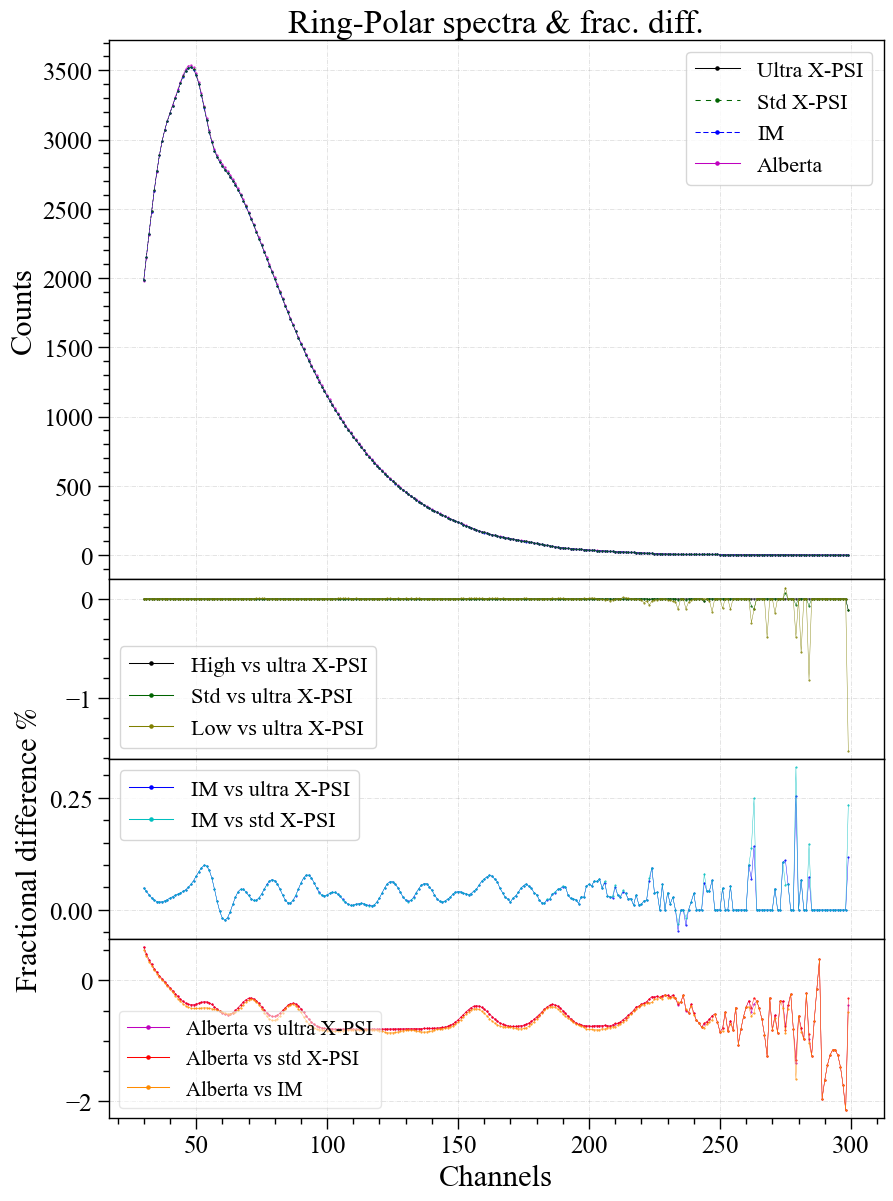

In [27]:
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(10, 14), sharex=True, gridspec_kw={'height_ratios': [3, 1, 1, 1]})

l1, = axes[0].plot(Ring_Polar_UltraXPSI_spectrum[:, 0], Ring_Polar_UltraXPSI_spectrum[:, 1], 'o-', color='k', lw=0.3, markersize=0.5, label='Ultra X-PSI')
l2, = axes[0].plot(Ring_Polar_UltraXPSI_spectrum[:, 0], Ring_Polar_Alberta_spectrum[:, 1], 'o-', color='m', lw=0.3, markersize=0.5, label='Alberta')
l3, = axes[0].plot(Ring_Polar_UltraXPSI_spectrum[:, 0], Ring_Polar_IM_spectrum[:, 1], 'o--', dashes=(5, 2.5), color='b', lw=0.3, markersize=0.5, label='IM')
l4, = axes[0].plot(Ring_Polar_UltraXPSI_spectrum[:, 0], Ring_Polar_StdXPSI_spectrum[:, 1], 'o--', dashes=(5, 5), color='darkgreen', lw=0.3, markersize=0.5, label='Std X-PSI')
axes[0].grid(linestyle="-.", color='grey',linewidth=0.5, alpha=0.3)
veneer(None, None, axes[0])
handles = [l1, l4, l3, l2]
labels = [line.get_label() for line in handles]
legend_line_thickness(axes[0].legend(handles, labels))
#axes[0].ticklabel_format(axis='y', style='sci', scilimits=(0,0))  # Scientific notation used for y-axis'
axes[0].set_ylabel('Counts')
axes[0].set_title(r'Ring-Polar spectra & frac. diff.')

axes[1].plot(Ring_Polar_UltraXPSI_spectrum[:, 0], spec_frac_diff_Ring_Polar_UltraXPSI_and_HiXPSI, 'o-', color='k', lw=0.3, markersize=0.5, label='High vs ultra X-PSI')
axes[1].plot(Ring_Polar_UltraXPSI_spectrum[:, 0], spec_frac_diff_Ring_Polar_UltraXPSI_and_StdXPSI, 'o-', color='darkgreen', lw=0.3, markersize=0.5, label='Std vs ultra X-PSI')
axes[1].plot(Ring_Polar_UltraXPSI_spectrum[:, 0], spec_frac_diff_Ring_Polar_UltraXPSI_and_LowXPSI, 'o-', color='olive', lw=0.3, markersize=0.5, label='Low vs ultra X-PSI')
axes[1].grid(linestyle="-.", color='grey',linewidth=0.5, alpha=0.3)
veneer(None, None, axes[1])
legend_line_thickness(axes[1].legend())

axes[2].plot(Ring_Polar_UltraXPSI_spectrum[:, 0], spec_frac_diff_Ring_Polar_UltraXPSI_and_IM, 'o-', color='b', lw=0.3, markersize=0.5, label='IM vs ultra X-PSI')
axes[2].plot(Ring_Polar_UltraXPSI_spectrum[:, 0], spec_frac_diff_Ring_Polar_StdXPSI_and_IM, 'o-', color='c', lw=0.3, markersize=0.5, label='IM vs std X-PSI')
axes[2].grid(linestyle="-.", color='grey',linewidth=0.5, alpha=0.3)
veneer(None, None, axes[2])
# Manually adjust yticklabels for axes[2] since it overlaps with axes[3]
# yticks_3 = axes[2].get_yticks()
# yticklabels_3 = ['' if i==0 or i==4 else label.get_text() for i, label in enumerate(axes[2].get_yticklabels())]
# axes[2].set_yticks(yticks_3)
# axes[2].set_yticklabels(yticklabels_3)
# axes[2].set_ylim(-0.0006)
legend_line_thickness(axes[2].legend())
axes[2].set_ylabel('Fractional difference $\%$')
# axes[2].yaxis.labelpad = 10     # Adjust axis label position

axes[3].plot(Ring_Polar_UltraXPSI_spectrum[:, 0], spec_frac_diff_Ring_Polar_UltraXPSI_and_Alberta, 'o-', color='m', lw=0.3, markersize=0.5, label='Alberta vs ultra X-PSI')
axes[3].plot(Ring_Polar_UltraXPSI_spectrum[:, 0], spec_frac_diff_Ring_Polar_StdXPSI_and_Alberta, 'o-', color='r', lw=0.3, markersize=0.5, label='Alberta vs std X-PSI')
axes[3].plot(Ring_Polar_UltraXPSI_spectrum[:, 0], spec_frac_diff_Ring_Polar_IM_and_Alberta, 'o-', color='darkorange', lw=0.3, markersize=0.5, label='Alberta vs IM')
axes[3].grid(linestyle="-.", color='grey',linewidth=0.5, alpha=0.3)
veneer(None, None, axes[3])
legend_line_thickness(axes[3].legend(fontsize=15, framealpha=0.5))
# axes[3].legend.get_frame().set_alpha(0.5)
axes[3].set_xlabel('Channels')

plt.subplots_adjust(hspace=0)

## Comparing Crescent-polar

In [28]:
# Loading data from files
Crescent_Polar_LowXPSI = np.loadtxt('./Pulse_profiles_by_diff_codes/XPSI/Low_res/Crescent_Polar_expected_hreadable.dat')
Crescent_Polar_StdXPSI = np.loadtxt('./Pulse_profiles_by_diff_codes/XPSI/Std_res/Crescent_Polar_expected_hreadable.dat')
Crescent_Polar_HiXPSI = np.loadtxt('./Pulse_profiles_by_diff_codes/XPSI/Hi_res/Crescent_Polar_expected_hreadable.dat')
Crescent_Polar_UltraXPSI = np.loadtxt('./Pulse_profiles_by_diff_codes/XPSI/Ultra_res/Crescent_Polar_expected_hreadable.dat')
Crescent_Polar_IM_full = np.loadtxt('./Pulse_profiles_by_diff_codes/IM/Crescent_Polar.txt')
Crescent_Polar_IM = Crescent_Polar_IM_full[:, [0, 1, 3]]
Crescent_Polar_Alberta_full = np.loadtxt('./Pulse_profiles_by_diff_codes/Alberta/Crescent_Polar.txt')
Crescent_Polar_Alberta = Crescent_Polar_Alberta_full[0:8640, [0, 1, 2]]

# Energy summed waveforms
Crescent_Polar_LowXPSI_energy_summed = generate_energy_summed_waveform(Crescent_Polar_LowXPSI)
Crescent_Polar_StdXPSI_energy_summed = generate_energy_summed_waveform(Crescent_Polar_StdXPSI)
Crescent_Polar_HiXPSI_energy_summed = generate_energy_summed_waveform(Crescent_Polar_HiXPSI)
Crescent_Polar_UltraXPSI_energy_summed = generate_energy_summed_waveform(Crescent_Polar_UltraXPSI)
Crescent_Polar_IM_energy_summed = generate_energy_summed_waveform(Crescent_Polar_IM)
Crescent_Polar_Alberta_energy_summed = generate_energy_summed_waveform(Crescent_Polar_Alberta)

# Diff in energy summed waveforms
diff_Crescent_Polar_UltraXPSI_and_LowXPSI = diff(Crescent_Polar_UltraXPSI_energy_summed, Crescent_Polar_LowXPSI_energy_summed)
diff_Crescent_Polar_UltraXPSI_and_StdXPSI = diff(Crescent_Polar_UltraXPSI_energy_summed, Crescent_Polar_StdXPSI_energy_summed)
diff_Crescent_Polar_UltraXPSI_and_HiXPSI = diff(Crescent_Polar_UltraXPSI_energy_summed, Crescent_Polar_HiXPSI_energy_summed)
diff_Crescent_Polar_UltraXPSI_and_IM = diff(Crescent_Polar_UltraXPSI_energy_summed, Crescent_Polar_IM_energy_summed)
diff_Crescent_Polar_StdXPSI_and_IM = diff(Crescent_Polar_StdXPSI_energy_summed, Crescent_Polar_IM_energy_summed)
diff_Crescent_Polar_UltraXPSI_and_Alberta = diff(Crescent_Polar_UltraXPSI_energy_summed, Crescent_Polar_Alberta_energy_summed)
diff_Crescent_Polar_StdXPSI_and_Alberta = diff(Crescent_Polar_StdXPSI_energy_summed, Crescent_Polar_Alberta_energy_summed)
diff_Crescent_Polar_IM_and_Alberta = diff(Crescent_Polar_IM_energy_summed, Crescent_Polar_Alberta_energy_summed)

# Fractional diff in energy summed waveforms
frac_diff_Crescent_Polar_UltraXPSI_and_LowXPSI = fractional_diff(Crescent_Polar_UltraXPSI_energy_summed, Crescent_Polar_LowXPSI_energy_summed)
frac_diff_Crescent_Polar_UltraXPSI_and_StdXPSI = fractional_diff(Crescent_Polar_UltraXPSI_energy_summed, Crescent_Polar_StdXPSI_energy_summed)
frac_diff_Crescent_Polar_UltraXPSI_and_HiXPSI = fractional_diff(Crescent_Polar_UltraXPSI_energy_summed, Crescent_Polar_HiXPSI_energy_summed)
frac_diff_Crescent_Polar_UltraXPSI_and_IM = fractional_diff(Crescent_Polar_UltraXPSI_energy_summed, Crescent_Polar_IM_energy_summed)
frac_diff_Crescent_Polar_StdXPSI_and_IM = fractional_diff(Crescent_Polar_StdXPSI_energy_summed, Crescent_Polar_IM_energy_summed)
frac_diff_Crescent_Polar_UltraXPSI_and_Alberta = fractional_diff(Crescent_Polar_UltraXPSI_energy_summed, Crescent_Polar_Alberta_energy_summed)
frac_diff_Crescent_Polar_StdXPSI_and_Alberta = fractional_diff(Crescent_Polar_StdXPSI_energy_summed, Crescent_Polar_Alberta_energy_summed)
frac_diff_Crescent_Polar_IM_and_Alberta = fractional_diff(Crescent_Polar_IM_energy_summed, Crescent_Polar_Alberta_energy_summed)

# Spectra
Crescent_Polar_LowXPSI_spectrum = generate_spectrum(Crescent_Polar_LowXPSI)
Crescent_Polar_StdXPSI_spectrum = generate_spectrum(Crescent_Polar_StdXPSI)
Crescent_Polar_HiXPSI_spectrum = generate_spectrum(Crescent_Polar_HiXPSI)
Crescent_Polar_UltraXPSI_spectrum = generate_spectrum(Crescent_Polar_UltraXPSI)
Crescent_Polar_IM_spectrum = generate_spectrum(Crescent_Polar_IM)
Crescent_Polar_Alberta_spectrum = generate_spectrum(Crescent_Polar_Alberta)

# Diff in spectra
spec_diff_Crescent_Polar_UltraXPSI_and_LowXPSI = diff(Crescent_Polar_UltraXPSI_spectrum[:,1], Crescent_Polar_LowXPSI_spectrum[:,1])
spec_diff_Crescent_Polar_UltraXPSI_and_StdXPSI = diff(Crescent_Polar_UltraXPSI_spectrum[:,1], Crescent_Polar_StdXPSI_spectrum[:,1])
spec_diff_Crescent_Polar_UltraXPSI_and_HiXPSI = diff(Crescent_Polar_UltraXPSI_spectrum[:,1], Crescent_Polar_HiXPSI_spectrum[:,1])
spec_diff_Crescent_Polar_UltraXPSI_and_IM = diff(Crescent_Polar_UltraXPSI_spectrum[:,1], Crescent_Polar_IM_spectrum[:,1])
spec_diff_Crescent_Polar_StdXPSI_and_IM = diff(Crescent_Polar_StdXPSI_spectrum[:,1], Crescent_Polar_IM_spectrum[:,1])
spec_diff_Crescent_Polar_UltraXPSI_and_Alberta = diff(Crescent_Polar_UltraXPSI_spectrum[:,1], Crescent_Polar_Alberta_spectrum[:,1])
spec_diff_Crescent_Polar_StdXPSI_and_Alberta = diff(Crescent_Polar_StdXPSI_spectrum[:,1], Crescent_Polar_Alberta_spectrum[:,1])
spec_diff_Crescent_Polar_IM_and_Alberta = diff(Crescent_Polar_IM_spectrum[:,1], Crescent_Polar_Alberta_spectrum[:,1])

# Fractional diff in spectra
spec_frac_diff_Crescent_Polar_UltraXPSI_and_LowXPSI = fractional_diff(Crescent_Polar_UltraXPSI_spectrum[:,1], Crescent_Polar_LowXPSI_spectrum[:,1])
spec_frac_diff_Crescent_Polar_UltraXPSI_and_StdXPSI = fractional_diff(Crescent_Polar_UltraXPSI_spectrum[:,1], Crescent_Polar_StdXPSI_spectrum[:,1])
spec_frac_diff_Crescent_Polar_UltraXPSI_and_HiXPSI = fractional_diff(Crescent_Polar_UltraXPSI_spectrum[:,1], Crescent_Polar_HiXPSI_spectrum[:,1])
spec_frac_diff_Crescent_Polar_UltraXPSI_and_IM = fractional_diff(Crescent_Polar_UltraXPSI_spectrum[:,1], Crescent_Polar_IM_spectrum[:,1])
spec_frac_diff_Crescent_Polar_StdXPSI_and_IM = fractional_diff(Crescent_Polar_StdXPSI_spectrum[:,1], Crescent_Polar_IM_spectrum[:,1])
spec_frac_diff_Crescent_Polar_UltraXPSI_and_Alberta = fractional_diff(Crescent_Polar_UltraXPSI_spectrum[:,1], Crescent_Polar_Alberta_spectrum[:,1])
spec_frac_diff_Crescent_Polar_StdXPSI_and_Alberta = fractional_diff(Crescent_Polar_StdXPSI_spectrum[:,1], Crescent_Polar_Alberta_spectrum[:,1])
spec_frac_diff_Crescent_Polar_IM_and_Alberta = fractional_diff(Crescent_Polar_IM_spectrum[:,1], Crescent_Polar_Alberta_spectrum[:,1])

# Pulse profiles
Crescent_Polar_LowXPSI_pulse_profile = generate_pulse_profile(Crescent_Polar_LowXPSI)
Crescent_Polar_StdXPSI_pulse_profile = generate_pulse_profile(Crescent_Polar_StdXPSI)
Crescent_Polar_HiXPSI_pulse_profile = generate_pulse_profile(Crescent_Polar_HiXPSI)
Crescent_Polar_UltraXPSI_pulse_profile = generate_pulse_profile(Crescent_Polar_UltraXPSI)
Crescent_Polar_IM_pulse_profile = generate_pulse_profile(Crescent_Polar_IM)
Crescent_Polar_Alberta_pulse_profile = generate_pulse_profile(Crescent_Polar_Alberta)

# Difference in pulse profiles
diff_Crescent_Polar_UltraXPSI_and_LowXPSI_pulse_profile = diff(Crescent_Polar_UltraXPSI_pulse_profile, Crescent_Polar_LowXPSI_pulse_profile)
diff_Crescent_Polar_UltraXPSI_and_StdXPSI_pulse_profile = diff(Crescent_Polar_UltraXPSI_pulse_profile, Crescent_Polar_StdXPSI_pulse_profile)
diff_Crescent_Polar_UltraXPSI_and_HiXPSI_pulse_profile = diff(Crescent_Polar_UltraXPSI_pulse_profile, Crescent_Polar_HiXPSI_pulse_profile)
diff_Crescent_Polar_UltraXPSI_and_IM_pulse_profile = diff(Crescent_Polar_UltraXPSI_pulse_profile, Crescent_Polar_IM_pulse_profile)
diff_Crescent_Polar_StdXPSI_and_IM_pulse_profile = diff(Crescent_Polar_StdXPSI_pulse_profile, Crescent_Polar_IM_pulse_profile)
diff_Crescent_Polar_UltraXPSI_and_Alberta_pulse_profile = diff(Crescent_Polar_UltraXPSI_pulse_profile, Crescent_Polar_Alberta_pulse_profile)
diff_Crescent_Polar_StdXPSI_and_Alberta_pulse_profile = diff(Crescent_Polar_StdXPSI_pulse_profile, Crescent_Polar_Alberta_pulse_profile)
diff_Crescent_Polar_IM_and_Alberta_pulse_profile = diff(Crescent_Polar_IM_pulse_profile, Crescent_Polar_Alberta_pulse_profile)

# Fractional difference in pulse profiles when counts are above a certain counts threshold
frac_diff_Crescent_Polar_UltraXPSI_and_LowXPSI_pulse_profile = fractional_diff(Crescent_Polar_UltraXPSI_pulse_profile, Crescent_Polar_LowXPSI_pulse_profile)
frac_diff_Crescent_Polar_UltraXPSI_and_StdXPSI_pulse_profile = fractional_diff(Crescent_Polar_UltraXPSI_pulse_profile, Crescent_Polar_StdXPSI_pulse_profile)
frac_diff_Crescent_Polar_UltraXPSI_and_HiXPSI_pulse_profile = fractional_diff(Crescent_Polar_UltraXPSI_pulse_profile, Crescent_Polar_HiXPSI_pulse_profile)
frac_diff_Crescent_Polar_UltraXPSI_and_IM_pulse_profile = fractional_diff(Crescent_Polar_UltraXPSI_pulse_profile, Crescent_Polar_IM_pulse_profile)
frac_diff_Crescent_Polar_StdXPSI_and_IM_pulse_profile = fractional_diff(Crescent_Polar_StdXPSI_pulse_profile, Crescent_Polar_IM_pulse_profile)
frac_diff_Crescent_Polar_UltraXPSI_and_Alberta_pulse_profile = fractional_diff(Crescent_Polar_UltraXPSI_pulse_profile, Crescent_Polar_Alberta_pulse_profile)
frac_diff_Crescent_Polar_StdXPSI_and_Alberta_pulse_profile = fractional_diff(Crescent_Polar_StdXPSI_pulse_profile, Crescent_Polar_Alberta_pulse_profile)
frac_diff_Crescent_Polar_IM_and_Alberta_pulse_profile = fractional_diff(Crescent_Polar_IM_pulse_profile, Crescent_Polar_Alberta_pulse_profile)

# Max fractional differences for energy-summed waveforms
print('Max fractional difference for energy summed waveforms: \n')
print('\t X-PSI Ultra settings and Low settings:', np.max(np.abs(frac_diff_Crescent_Polar_UltraXPSI_and_LowXPSI)))
print('\t X-PSI Ultra settings and Std settings:', np.max(np.abs(frac_diff_Crescent_Polar_UltraXPSI_and_StdXPSI)))
print('\t X-PSI Ultra settings and High settings:', np.max(np.abs(frac_diff_Crescent_Polar_UltraXPSI_and_HiXPSI)))
print('\t X-PSI Ultra settings and IM:', np.max(np.abs(frac_diff_Crescent_Polar_UltraXPSI_and_IM)))
print('\t X-PSI Std settings and IM:', np.max(np.abs(frac_diff_Crescent_Polar_StdXPSI_and_IM)))
print('\t X-PSI Ultra settings and Alberta:', np.max(np.abs(frac_diff_Crescent_Polar_UltraXPSI_and_Alberta)))
print('\t X-PSI Std settings and Alberta:', np.max(np.abs(frac_diff_Crescent_Polar_StdXPSI_and_Alberta)))
print('\t IM and Alberta:', np.max(np.abs(frac_diff_Crescent_Polar_IM_and_Alberta)))

# Max fractional differences for spectra
print('\nMax fractional difference for spectra: \n')
print('\t X-PSI Ultra settings and Low settings:', np.max(np.abs(spec_frac_diff_Crescent_Polar_UltraXPSI_and_LowXPSI)))
print('\t X-PSI Ultra settings and Std settings:', np.max(np.abs(spec_frac_diff_Crescent_Polar_UltraXPSI_and_StdXPSI)))
print('\t X-PSI Ultra settings and High settings:', np.max(np.abs(spec_frac_diff_Crescent_Polar_UltraXPSI_and_HiXPSI)))
print('\t X-PSI Ultra settings and IM:', np.max(np.abs(spec_frac_diff_Crescent_Polar_UltraXPSI_and_IM)))
print('\t X-PSI Std settings and IM:', np.max(np.abs(spec_frac_diff_Crescent_Polar_StdXPSI_and_IM)))
print('\t X-PSI Ultra settings and Alberta:', np.max(np.abs(spec_frac_diff_Crescent_Polar_UltraXPSI_and_Alberta)))
print('\t X-PSI Std settings and Alberta:', np.max(np.abs(spec_frac_diff_Crescent_Polar_StdXPSI_and_Alberta)))
print('\t IM and Alberta:', np.max(np.abs(spec_frac_diff_Crescent_Polar_IM_and_Alberta)))

# Max fractional difference in pulse profiles
print('\nMax fractional difference for pulse profiles: \n')
print('\t X-PSI Ultra settings and Low settings:', np.max(np.abs(frac_diff_Crescent_Polar_UltraXPSI_and_LowXPSI_pulse_profile)))
print('\t X-PSI Ultra settings and Std settings:', np.max(np.abs(frac_diff_Crescent_Polar_UltraXPSI_and_StdXPSI_pulse_profile)))
print('\t X-PSI Ultra settings and High settings:', np.max(np.abs(frac_diff_Crescent_Polar_UltraXPSI_and_HiXPSI_pulse_profile)))
print('\t X-PSI Ultra settings and IM:', np.max(np.abs(frac_diff_Crescent_Polar_UltraXPSI_and_IM_pulse_profile)))
print('\t X-PSI Std settings and IM:', np.max(np.abs(frac_diff_Crescent_Polar_StdXPSI_and_IM_pulse_profile)))
print('\t X-PSI Ultra settings and Alberta:', np.max(np.abs(frac_diff_Crescent_Polar_UltraXPSI_and_Alberta_pulse_profile)))
print('\t IM and Alberta:', np.max(np.abs(frac_diff_Crescent_Polar_StdXPSI_and_Alberta_pulse_profile)))

Max fractional difference for energy summed waveforms: 

	 X-PSI Ultra settings and Low settings: 66.08863760714937
	 X-PSI Ultra settings and Std settings: 38.05216122560641
	 X-PSI Ultra settings and High settings: 2.77585263541855
	 X-PSI Ultra settings and IM: 23.441911362392815
	 X-PSI Std settings and IM: 10.583137368879985
	 X-PSI Ultra settings and Alberta: 30.195116896910022
	 X-PSI Std settings and Alberta: 49.43586360157445
	 IM and Alberta: 43.45122954378007

Max fractional difference for spectra: 

	 X-PSI Ultra settings and Low settings: 0.8807985907222621
	 X-PSI Ultra settings and Std settings: 0.7277137659187393
	 X-PSI Ultra settings and High settings: 0.15584415584416175
	 X-PSI Ultra settings and IM: 0.8236166451443641
	 X-PSI Std settings and IM: 1.324503311258266
	 X-PSI Ultra settings and Alberta: 2.2367002544020065
	 X-PSI Std settings and Alberta: 1.7356416463316209
	 IM and Alberta: 2.7645825272360995

Max fractional difference for pulse profiles: 

	 X-PSI Ul

### Figure 2 middle-right panel

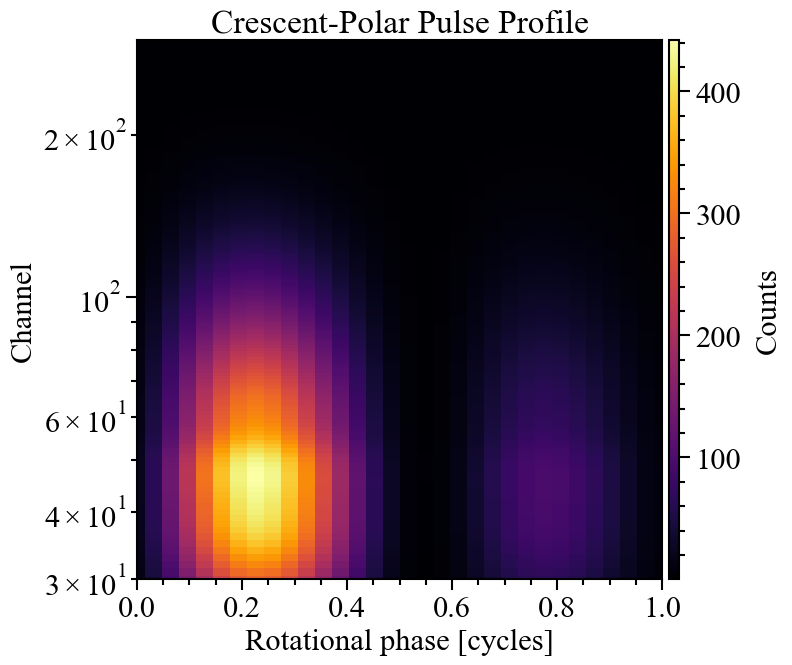

In [29]:
plot_pulse_profile(generate_pulse_profile(Crescent_Polar_UltraXPSI), r'Counts', r'Crescent-Polar Pulse Profile')

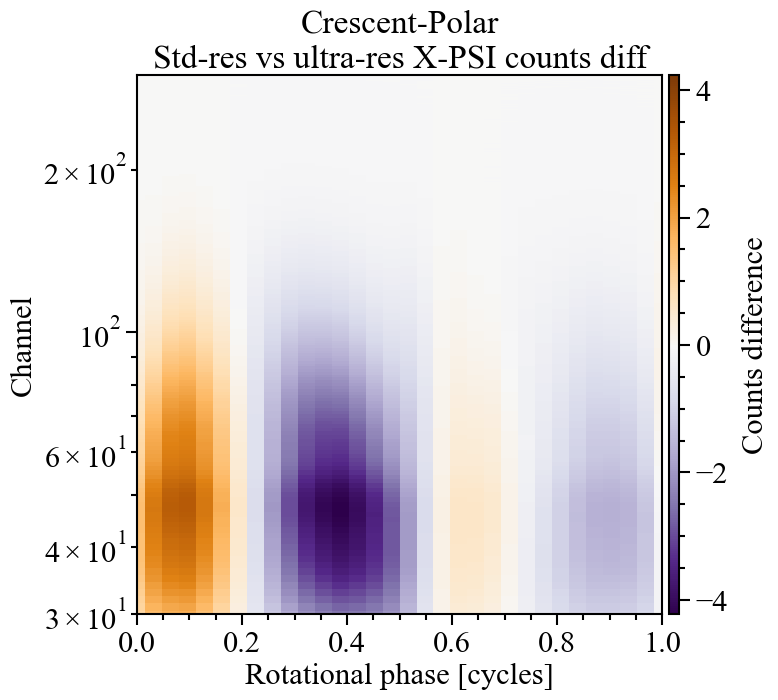

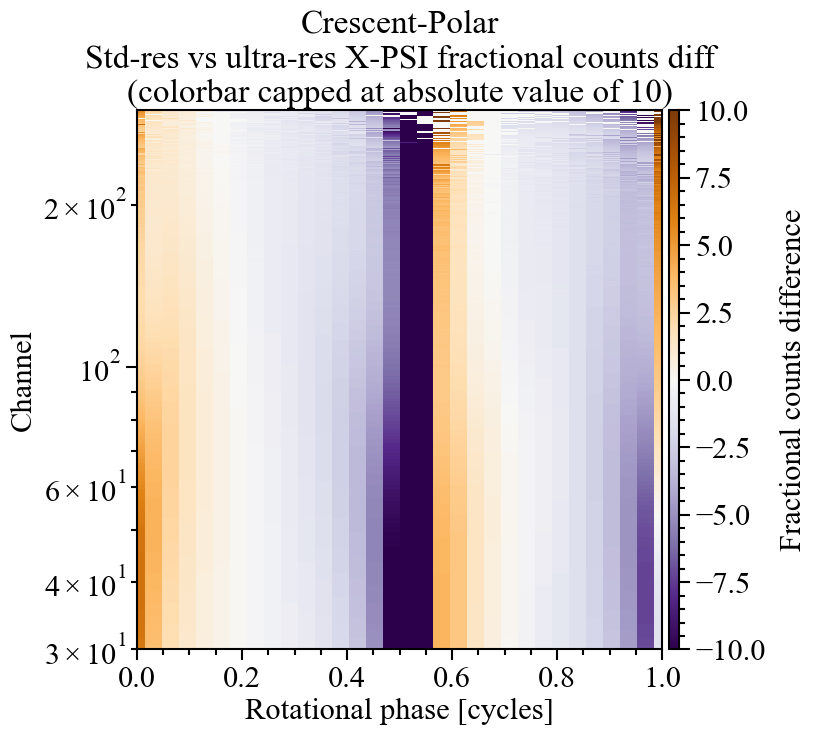

In [30]:
plot_pulse_profile(diff_Crescent_Polar_UltraXPSI_and_StdXPSI_pulse_profile, 
                   r'Counts difference', r'Crescent-Polar'+ '\n' + r'Std-res vs ultra-res X-PSI counts diff', 
                   norm='TwoSlope')

plot_pulse_profile(frac_diff_Crescent_Polar_UltraXPSI_and_StdXPSI_pulse_profile, 
                   r'Fractional counts difference', r'Crescent-Polar'+ '\n' + r'Std-res vs ultra-res X-PSI fractional counts diff'+ '\n' + r'(colorbar capped at absolute value of 10)', 
                   norm='TwoSlope', maxcolor=-10)

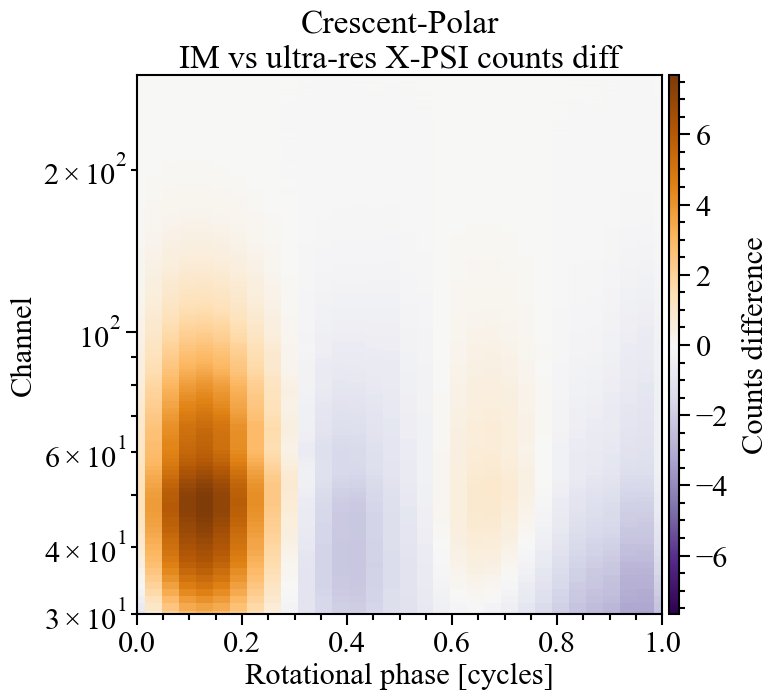

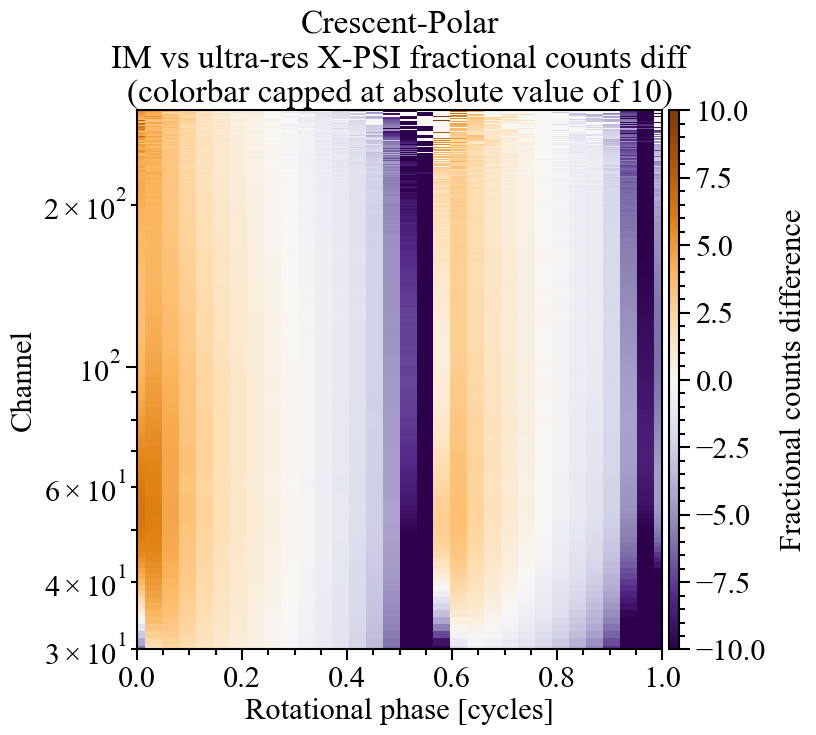

In [31]:
plot_pulse_profile(diff_Crescent_Polar_UltraXPSI_and_IM_pulse_profile, 
                   r'Counts difference', r'Crescent-Polar'+ '\n' + r'IM vs ultra-res X-PSI counts diff', 
                   norm='TwoSlope')

plot_pulse_profile(frac_diff_Crescent_Polar_UltraXPSI_and_IM_pulse_profile, 
                   r'Fractional counts difference', r'Crescent-Polar'+ '\n' + r'IM vs ultra-res X-PSI fractional counts diff' + '\n' + r'(colorbar capped at absolute value of 10)', 
                   norm='TwoSlope', maxcolor=-10)

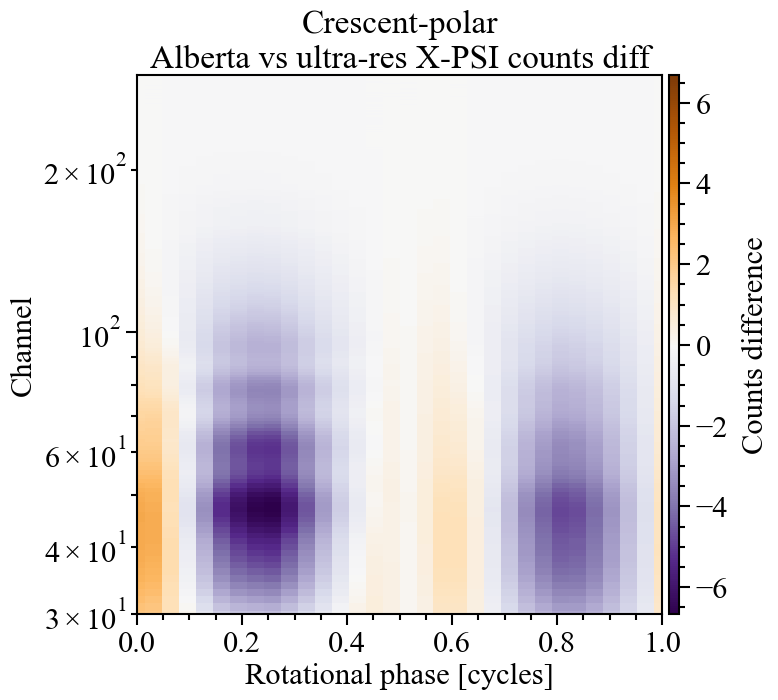

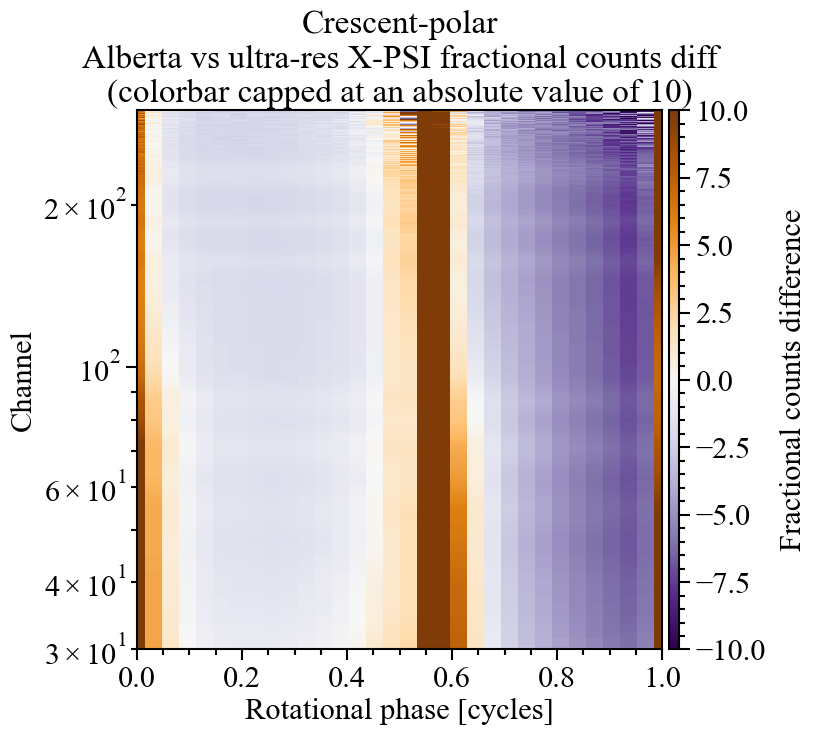

In [32]:
plot_pulse_profile(diff_Crescent_Polar_UltraXPSI_and_Alberta_pulse_profile, 
                   r'Counts difference', r'Crescent-polar'+ '\n' + r'Alberta vs ultra-res X-PSI counts diff', 
                   norm='TwoSlope')

plot_pulse_profile(frac_diff_Crescent_Polar_UltraXPSI_and_Alberta_pulse_profile, 
                   r'Fractional counts difference', r'Crescent-polar'+ '\n' + r'Alberta vs ultra-res X-PSI fractional counts diff' + '\n' + r'(colorbar capped at an absolute value of 10)', 
                   norm='TwoSlope', maxcolor=-10)

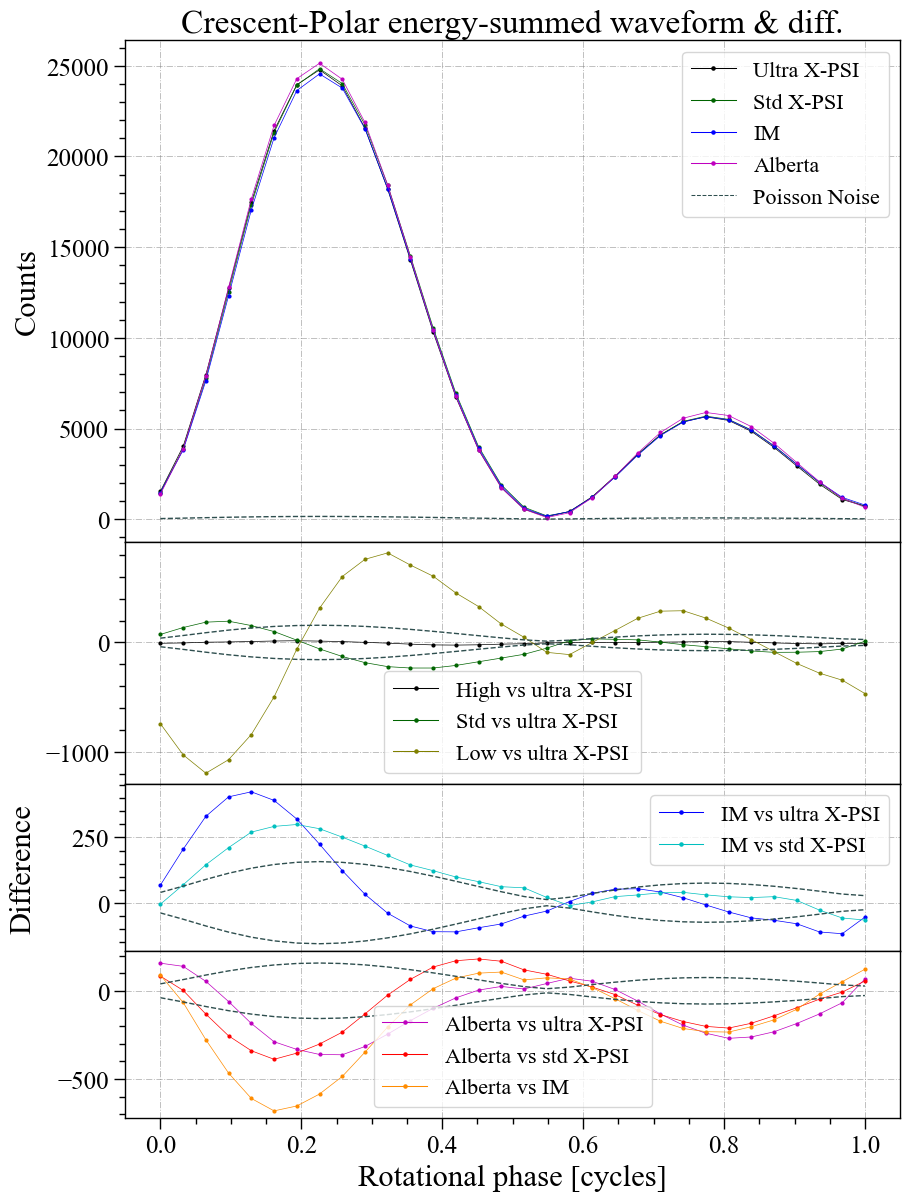

In [33]:
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(10, 14), sharex=True, gridspec_kw={'height_ratios': [3, 1.45, 1, 1]})

axes[0].plot(np.linspace(0.0, 1.0, 32), Crescent_Polar_UltraXPSI_energy_summed, 'o-', color='k', lw=0.5, markersize=2, label='Ultra X-PSI')
axes[0].plot(np.linspace(0.0, 1.0, 32), Crescent_Polar_StdXPSI_energy_summed, 'o-', color='darkgreen', lw=0.5, markersize=2, label='Std X-PSI')
axes[0].plot(np.linspace(0.0, 1.0, 32), Crescent_Polar_IM_energy_summed, 'o-', color='b', lw=0.5, markersize=2, label='IM')
axes[0].plot(np.linspace(0.0, 1.0, 32), Crescent_Polar_Alberta_energy_summed, 'o-', color='m', lw=0.5, markersize=2, label='Alberta')
axes[0].grid(linestyle="-.", color='grey',linewidth=0.7, alpha=0.5)
veneer(None, None, axes[0])
legend_line_thickness(axes[0].legend())
axes[0].set_ylabel('Counts')
axes[0].set_title(r'Crescent-Polar energy-summed waveform & diff.')

axes[1].plot(np.linspace(0.0, 1.0, 32), diff_Crescent_Polar_UltraXPSI_and_HiXPSI, 'o-', color='k', lw=0.5, markersize=2, label='High vs ultra X-PSI')
axes[1].plot(np.linspace(0.0, 1.0, 32), diff_Crescent_Polar_UltraXPSI_and_StdXPSI, 'o-', color='darkgreen', lw=0.5, markersize=2, label='Std vs ultra X-PSI')
axes[1].plot(np.linspace(0.0, 1.0, 32), diff_Crescent_Polar_UltraXPSI_and_LowXPSI, 'o-', color='olive', lw=0.5, markersize=2, label='Low vs ultra X-PSI')
axes[1].grid(linestyle="-.", color='grey',linewidth=0.7, alpha=0.5)
veneer(None, None, axes[1])
legend_line_thickness(axes[1].legend())

axes[2].plot(np.linspace(0.0, 1.0, 32), diff_Crescent_Polar_UltraXPSI_and_IM, 'o-', color='b', lw=0.5, markersize=2, label='IM vs ultra X-PSI')
axes[2].plot(np.linspace(0.0, 1.0, 32), diff_Crescent_Polar_StdXPSI_and_IM, 'o-', color='c', lw=0.5, markersize=2, label='IM vs std X-PSI')
axes[2].grid(linestyle="-.", color='grey',linewidth=0.7, alpha=0.5)
veneer(None, None, axes[2])
legend_line_thickness(axes[2].legend())
axes[2].set_ylabel('Difference')
axes[2].yaxis.labelpad = 25     # Adjust axis label position

axes[3].plot(np.linspace(0.0, 1.0, 32), diff_Crescent_Polar_UltraXPSI_and_Alberta, 'o-', color='m', lw=0.5, markersize=2, label='Alberta vs ultra X-PSI')
axes[3].plot(np.linspace(0.0, 1.0, 32), diff_Crescent_Polar_StdXPSI_and_Alberta, 'o-', color='r', lw=0.5, markersize=2, label='Alberta vs std X-PSI')
axes[3].plot(np.linspace(0.0, 1.0, 32), diff_Crescent_Polar_IM_and_Alberta, 'o-', color='darkorange', lw=0.5, markersize=2, label='Alberta vs IM')
axes[3].grid(linestyle="-.", color='grey',linewidth=0.7, alpha=0.5)
veneer(None, None, axes[3])
axes[3].legend()
axes[3].set_xlabel('Rotational phase [cycles]')

axes[0].plot(np.linspace(0.0, 1.0, 32), np.sqrt(Crescent_Polar_UltraXPSI_energy_summed), '--', color='darkslategrey', lw=1, markersize=2, label='Poisson Noise')
axes[1].plot(np.linspace(0.0, 1.0, 32), np.sqrt(Crescent_Polar_UltraXPSI_energy_summed), '--', color='darkslategrey', lw=1, markersize=2)
axes[1].plot(np.linspace(0.0, 1.0, 32), -np.sqrt(Crescent_Polar_UltraXPSI_energy_summed), '--', color='darkslategrey', lw=1, markersize=2)
axes[2].plot(np.linspace(0.0, 1.0, 32), np.sqrt(Crescent_Polar_UltraXPSI_energy_summed), '--', color='darkslategrey', lw=1, markersize=2)
axes[2].plot(np.linspace(0.0, 1.0, 32), -np.sqrt(Crescent_Polar_UltraXPSI_energy_summed), '--', color='darkslategrey', lw=1, markersize=2)
axes[3].plot(np.linspace(0.0, 1.0, 32), np.sqrt(Crescent_Polar_UltraXPSI_energy_summed), '--', color='darkslategrey', lw=1, markersize=2)
axes[3].plot(np.linspace(0.0, 1.0, 32), -np.sqrt(Crescent_Polar_UltraXPSI_energy_summed), '--', color='darkslategrey', lw=1, markersize=2)
legend_line_thickness(axes[0].legend())
legend_line_thickness(axes[1].legend())
legend_line_thickness(axes[2].legend())
legend_line_thickness(axes[3].legend())

plt.subplots_adjust(hspace=0)

### Figure 7 left panel

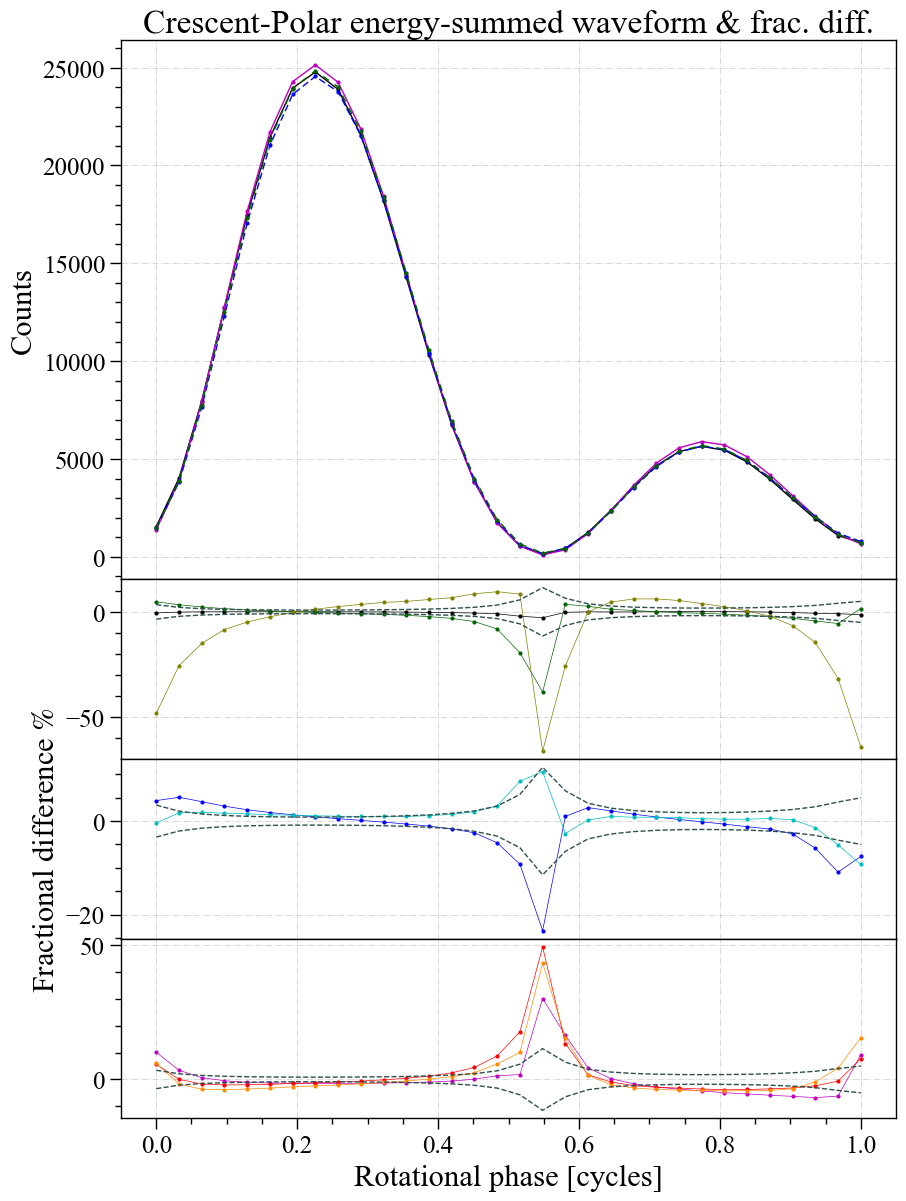

In [34]:
Crescent_Polar_noise_norm = np.sum(Crescent_Polar_UltraXPSI)/10**6
Crescent_Polar_noise = (np.sqrt(Crescent_Polar_UltraXPSI_energy_summed/Crescent_Polar_noise_norm)/(Crescent_Polar_UltraXPSI_energy_summed/Crescent_Polar_noise_norm))*100

# Crescent_Polar_noise = (np.sqrt(Crescent_Polar_UltraXPSI_energy_summed)/Crescent_Polar_UltraXPSI_energy_summed)*100

fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(10, 14), sharex=True, gridspec_kw={'height_ratios': [3, 1, 1, 1]})

axes[0].plot(np.linspace(0.0, 1.0, 32), Crescent_Polar_UltraXPSI_energy_summed, 'o-', color='k', lw=1, markersize=2, label='Ultra X-PSI')
axes[0].plot(np.linspace(0.0, 1.0, 32), Crescent_Polar_Alberta_energy_summed, 'o-', color='m', lw=1, markersize=2, label='Alberta')
axes[0].plot(np.linspace(0.0, 1.0, 32), Crescent_Polar_IM_energy_summed, 'o--', dashes=(5, 2.5), color='b', lw=1, markersize=2, label='IM')
axes[0].plot(np.linspace(0.0, 1.0, 32), Crescent_Polar_StdXPSI_energy_summed, 'o--', dashes=(5, 5), color='darkgreen', lw=1, markersize=2, label='Std X-PSI')
# axes[0].plot(np.linspace(0.0, 1.0, 32), np.sqrt(Crescent_Polar_UltraXPSI_energy_summed), '--', color='darkslategrey', lw=1, markersize=2, label='Poisson Noise')
axes[0].grid(linestyle="-.", color='grey',linewidth=0.7, alpha=0.3)
veneer(None, None, axes[0])
# legend_line_thickness(axes[0].legend())
#axes[0].ticklabel_format(axis='y', style='sci', scilimits=(0,0))  # Scientific notation used for y-axis
axes[0].set_ylabel('Counts')
axes[0].set_title(r'Crescent-Polar energy-summed waveform & frac. diff.')

axes[1].plot(np.linspace(0.0, 1.0, 32), frac_diff_Crescent_Polar_UltraXPSI_and_HiXPSI, 'o-', color='k', lw=0.5, markersize=2, label='High vs ultra X-PSI')
axes[1].plot(np.linspace(0.0, 1.0, 32), frac_diff_Crescent_Polar_UltraXPSI_and_StdXPSI, 'o-', color='darkgreen', lw=0.5, markersize=2, label='Std vs ultra X-PSI')
axes[1].plot(np.linspace(0.0, 1.0, 32), frac_diff_Crescent_Polar_UltraXPSI_and_LowXPSI, 'o-', color='olive', lw=0.5, markersize=2, label='Low vs ultra X-PSI')
axes[1].plot(np.linspace(0.0, 1.0, 32), Crescent_Polar_noise, '--', color='darkslategrey', lw=1, markersize=2)
axes[1].plot(np.linspace(0.0, 1.0, 32), -Crescent_Polar_noise, '--', color='darkslategrey', lw=1, markersize=2)

axes[1].grid(linestyle="-.", color='grey',linewidth=0.7, alpha=0.3)
veneer(None, None, axes[1])
# legend_line_thickness(axes[1].legend(loc='lower left', framealpha=0.6))

axes[2].plot(np.linspace(0.0, 1.0, 32), frac_diff_Crescent_Polar_UltraXPSI_and_IM, 'o-', color='b', lw=0.5, markersize=2, label='IM vs ultra X-PSI')
axes[2].plot(np.linspace(0.0, 1.0, 32), frac_diff_Crescent_Polar_StdXPSI_and_IM, 'o-', color='c', lw=0.5, markersize=2, label='IM vs std X-PSI')
axes[2].plot(np.linspace(0.0, 1.0, 32), Crescent_Polar_noise, '--', color='darkslategrey', lw=1, markersize=2)
axes[2].plot(np.linspace(0.0, 1.0, 32), -Crescent_Polar_noise, '--', color='darkslategrey', lw=1, markersize=2)

axes[2].grid(linestyle="-.", color='grey',linewidth=0.7, alpha=0.3)
veneer(None, None, axes[2])
# legend_line_thickness(axes[2].legend())
axes[2].set_ylabel('Fractional difference $\%$')
# axes[2].yaxis.labelpad = 10     # Adjust axis label position

axes[3].plot(np.linspace(0.0, 1.0, 32), frac_diff_Crescent_Polar_UltraXPSI_and_Alberta, 'o-', color='m', lw=0.5, markersize=2, label='Alberta vs ultra X-PSI')
axes[3].plot(np.linspace(0.0, 1.0, 32), frac_diff_Crescent_Polar_StdXPSI_and_Alberta, 'o-', color='r', lw=0.5, markersize=2, label='Alberta vs std X-PSI')
axes[3].plot(np.linspace(0.0, 1.0, 32), frac_diff_Crescent_Polar_IM_and_Alberta, 'o-', color='darkorange', lw=0.5, markersize=2, label='Alberta vs IM')
axes[3].plot(np.linspace(0.0, 1.0, 32), Crescent_Polar_noise, '--', color='darkslategrey', lw=1, markersize=2)
axes[3].plot(np.linspace(0.0, 1.0, 32), -Crescent_Polar_noise, '--', color='darkslategrey', lw=1, markersize=2)

axes[3].grid(linestyle="-.", color='grey',linewidth=0.7, alpha=0.3)
veneer(None, None, axes[3])
# legend_line_thickness(axes[3].legend())
axes[3].set_xlabel('Rotational phase [cycles]')

plt.subplots_adjust(hspace=0)

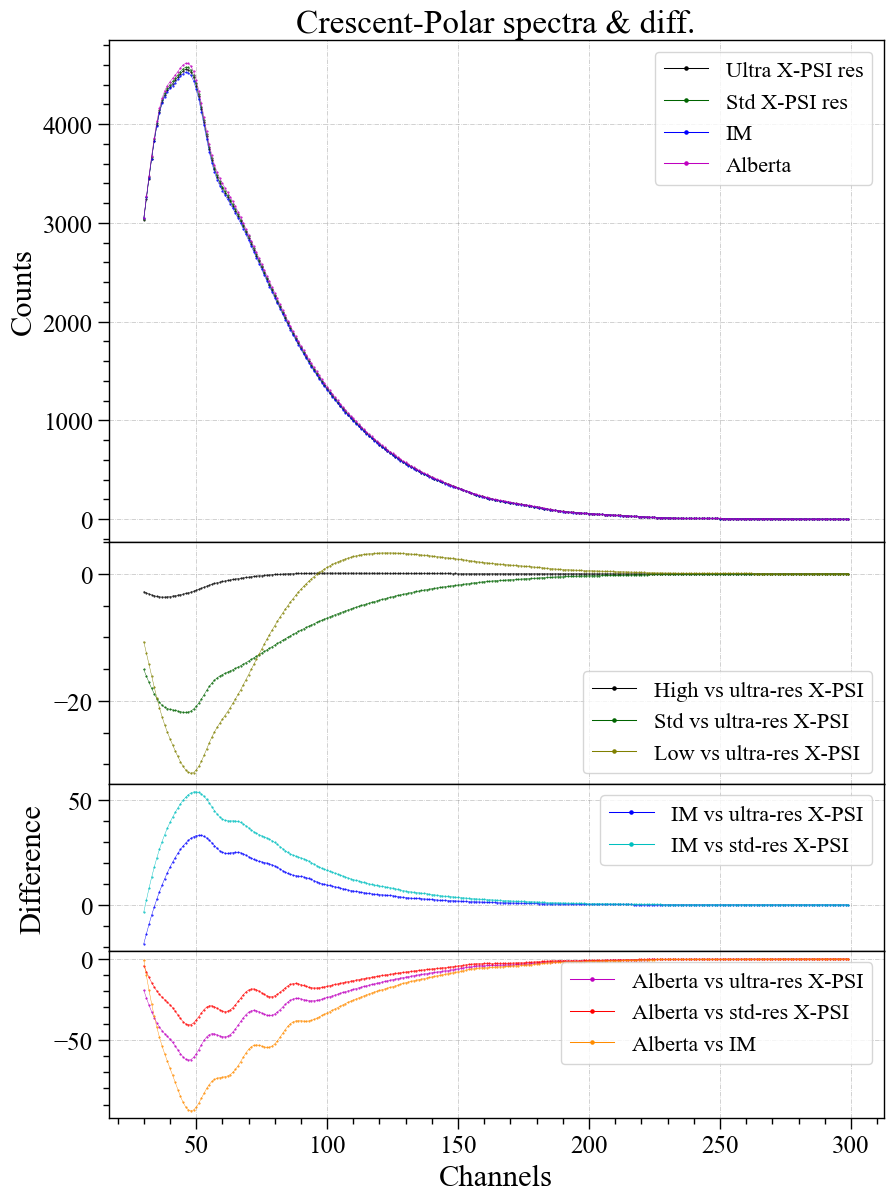

In [35]:
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(10, 14), sharex=True, gridspec_kw={'height_ratios': [3, 1.45, 1, 1]})

axes[0].plot(Crescent_Polar_UltraXPSI_spectrum[:, 0], Crescent_Polar_UltraXPSI_spectrum[:, 1], 'o-', color='k', lw=0.3, markersize=0.5, label='Ultra X-PSI res')
axes[0].plot(Crescent_Polar_UltraXPSI_spectrum[:, 0], Crescent_Polar_StdXPSI_spectrum[:, 1], 'o-', color='darkgreen', lw=0.3, markersize=0.5, label='Std X-PSI res')
axes[0].plot(Crescent_Polar_UltraXPSI_spectrum[:, 0], Crescent_Polar_IM_spectrum[:, 1], 'o-', color='b', lw=0.3, markersize=0.5, label='IM')
axes[0].plot(Crescent_Polar_UltraXPSI_spectrum[:, 0], Crescent_Polar_Alberta_spectrum[:, 1], 'o-', color='m', lw=0.3, markersize=0.5, label='Alberta')
axes[0].grid(linestyle="-.", color='grey',linewidth=0.5, alpha=0.5)
veneer(None, None, axes[0])
legend_line_thickness(axes[0].legend())
axes[0].set_ylabel('Counts')
axes[0].set_title(r'Crescent-Polar spectra & diff.')

axes[1].plot(Crescent_Polar_UltraXPSI_spectrum[:, 0], spec_diff_Crescent_Polar_UltraXPSI_and_HiXPSI, 'o-', color='k', lw=0.3, markersize=0.5, label='High vs ultra-res X-PSI')
axes[1].plot(Crescent_Polar_UltraXPSI_spectrum[:, 0], spec_diff_Crescent_Polar_UltraXPSI_and_StdXPSI, 'o-', color='darkgreen', lw=0.3, markersize=0.5, label='Std vs ultra-res X-PSI')
axes[1].plot(Crescent_Polar_UltraXPSI_spectrum[:, 0], spec_diff_Crescent_Polar_UltraXPSI_and_LowXPSI, 'o-', color='olive', lw=0.3, markersize=0.5, label='Low vs ultra-res X-PSI')
axes[1].grid(linestyle="-.", color='grey',linewidth=0.5, alpha=0.5)
veneer(None, None, axes[1])
legend_line_thickness(axes[1].legend())

axes[2].plot(Crescent_Polar_UltraXPSI_spectrum[:, 0], spec_diff_Crescent_Polar_UltraXPSI_and_IM, 'o-', color='b', lw=0.3, markersize=0.5, label='IM vs ultra-res X-PSI')
axes[2].plot(Crescent_Polar_UltraXPSI_spectrum[:, 0], spec_diff_Crescent_Polar_StdXPSI_and_IM, 'o-', color='c', lw=0.3, markersize=0.5, label='IM vs std-res X-PSI')
axes[2].grid(linestyle="-.", color='grey',linewidth=0.5, alpha=0.5)
veneer(None, None, axes[2])
legend_line_thickness(axes[2].legend())
axes[2].set_ylabel('Difference')
axes[2].yaxis.labelpad = 15     # Adjust axis label position

axes[3].plot(Crescent_Polar_UltraXPSI_spectrum[:, 0], spec_diff_Crescent_Polar_UltraXPSI_and_Alberta, 'o-', color='m', lw=0.3, markersize=0.5, label='Alberta vs ultra-res X-PSI')
axes[3].plot(Crescent_Polar_UltraXPSI_spectrum[:, 0], spec_diff_Crescent_Polar_StdXPSI_and_Alberta, 'o-', color='r', lw=0.3, markersize=0.5, label='Alberta vs std-res X-PSI')
axes[3].plot(Crescent_Polar_UltraXPSI_spectrum[:, 0], spec_diff_Crescent_Polar_IM_and_Alberta, 'o-', color='darkorange', lw=0.3, markersize=0.5, label='Alberta vs IM')
axes[3].grid(linestyle="-.", color='grey',linewidth=0.5, alpha=0.5)
veneer(None, None, axes[3])
legend_line_thickness(axes[3].legend())
axes[3].set_xlabel('Channels')

plt.subplots_adjust(hspace=0)

### Figure 7 right panel

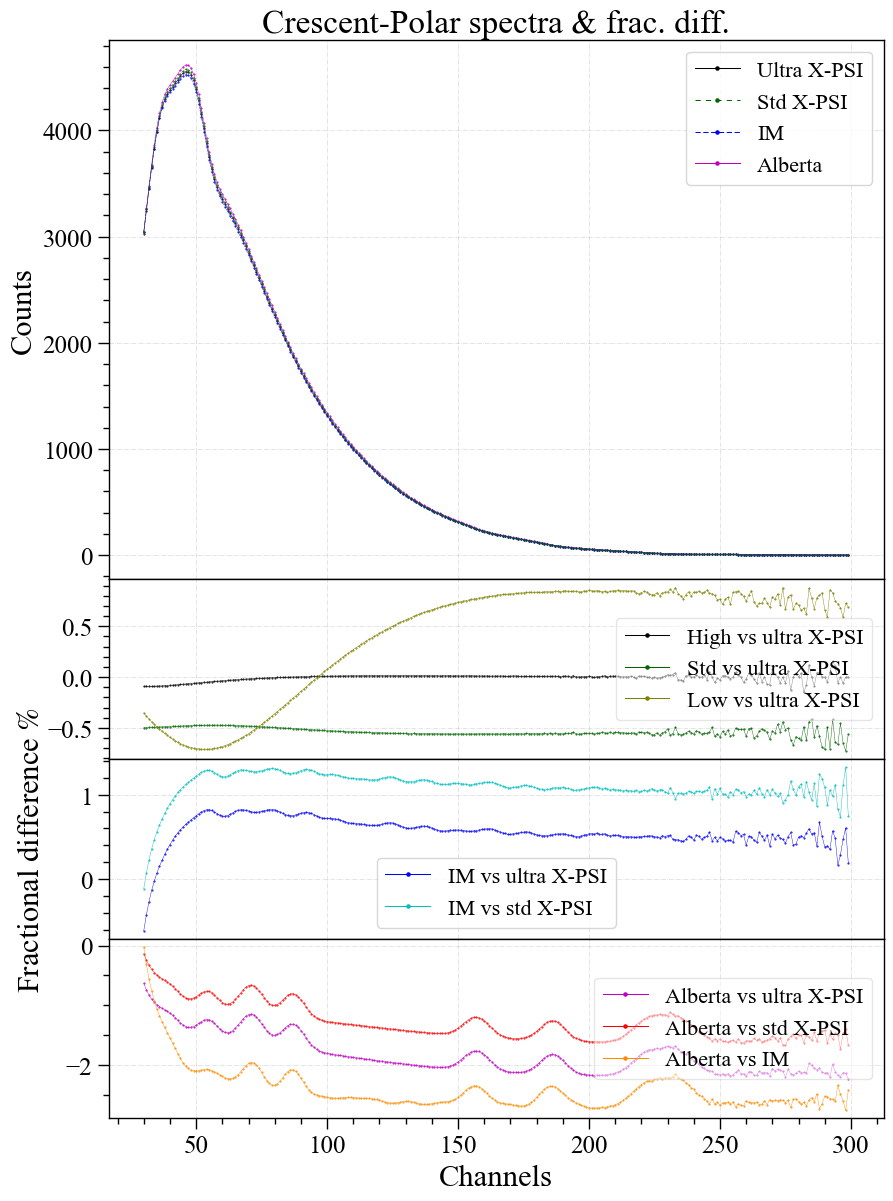

In [36]:
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(10, 14), sharex=True, gridspec_kw={'height_ratios': [3, 1, 1, 1]})

l1, = axes[0].plot(Crescent_Polar_UltraXPSI_spectrum[:, 0], Crescent_Polar_UltraXPSI_spectrum[:, 1], 'o-', color='k', lw=0.3, markersize=0.5, label='Ultra X-PSI')
l2, = axes[0].plot(Crescent_Polar_UltraXPSI_spectrum[:, 0], Crescent_Polar_Alberta_spectrum[:, 1], 'o-', color='m', lw=0.3, markersize=0.5, label='Alberta')
l3, = axes[0].plot(Crescent_Polar_UltraXPSI_spectrum[:, 0], Crescent_Polar_IM_spectrum[:, 1], 'o--', dashes=(5, 2.5), color='b', lw=0.3, markersize=0.5, label='IM')
l4, = axes[0].plot(Crescent_Polar_UltraXPSI_spectrum[:, 0], Crescent_Polar_StdXPSI_spectrum[:, 1], 'o--', dashes=(5, 5), color='darkgreen', lw=0.3, markersize=0.5, label='Std X-PSI')
axes[0].grid(linestyle="-.", color='grey',linewidth=0.5, alpha=0.3)
veneer(None, None, axes[0])
handles = [l1, l4, l3, l2]
labels = [line.get_label() for line in handles]
legend_line_thickness(axes[0].legend(handles, labels))
#axes[0].ticklabel_format(axis='y', style='sci', scilimits=(0,0))  # Scientific notation used for y-axis
axes[0].set_ylabel('Counts')
axes[0].set_title(r'Crescent-Polar spectra & frac. diff.')

axes[1].plot(Crescent_Polar_UltraXPSI_spectrum[:, 0], spec_frac_diff_Crescent_Polar_UltraXPSI_and_HiXPSI, 'o-', color='k', lw=0.3, markersize=0.5, label='High vs ultra X-PSI')
axes[1].plot(Crescent_Polar_UltraXPSI_spectrum[:, 0], spec_frac_diff_Crescent_Polar_UltraXPSI_and_StdXPSI, 'o-', color='darkgreen', lw=0.3, markersize=0.5, label='Std vs ultra X-PSI')
axes[1].plot(Crescent_Polar_UltraXPSI_spectrum[:, 0], spec_frac_diff_Crescent_Polar_UltraXPSI_and_LowXPSI, 'o-', color='olive', lw=0.3, markersize=0.5, label='Low vs ultra X-PSI')
axes[1].grid(linestyle="-.", color='grey',linewidth=0.5, alpha=0.3)
veneer(None, None, axes[1])
legend_line_thickness(axes[1].legend(framealpha=0.5))

axes[2].plot(Crescent_Polar_UltraXPSI_spectrum[:, 0], spec_frac_diff_Crescent_Polar_UltraXPSI_and_IM, 'o-', color='b', lw=0.3, markersize=0.5, label='IM vs ultra X-PSI')
axes[2].plot(Crescent_Polar_UltraXPSI_spectrum[:, 0], spec_frac_diff_Crescent_Polar_StdXPSI_and_IM, 'o-', color='c', lw=0.3, markersize=0.5, label='IM vs std X-PSI')
axes[2].grid(linestyle="-.", color='grey',linewidth=0.5, alpha=0.3)
veneer(None, None, axes[2])
# Manually adjust yticklabels for axes[2] since it overlaps with axes[3]
# yticks_3 = axes[2].get_yticks()
# yticklabels_3 = ['' if i==0 or i==4 else label.get_text() for i, label in enumerate(axes[2].get_yticklabels())]
# axes[2].set_yticks(yticks_3)
# axes[2].set_yticklabels(yticklabels_3)
# axes[2].set_ylim(-0.0006)
legend_line_thickness(axes[2].legend())
# axes[2].set_ylim(0.5,1)
axes[2].set_ylabel('Fractional difference $\%$')
axes[2].yaxis.labelpad = 25     # Adjust axis label position

axes[3].plot(Crescent_Polar_UltraXPSI_spectrum[:, 0], spec_frac_diff_Crescent_Polar_UltraXPSI_and_Alberta, 'o-', color='m', lw=0.3, markersize=0.5, label='Alberta vs ultra X-PSI')
axes[3].plot(Crescent_Polar_UltraXPSI_spectrum[:, 0], spec_frac_diff_Crescent_Polar_StdXPSI_and_Alberta, 'o-', color='r', lw=0.3, markersize=0.5, label='Alberta vs std X-PSI')
axes[3].plot(Crescent_Polar_UltraXPSI_spectrum[:, 0], spec_frac_diff_Crescent_Polar_IM_and_Alberta, 'o-', color='darkorange', lw=0.3, markersize=0.5, label='Alberta vs IM')
axes[3].grid(linestyle="-.", color='grey',linewidth=0.5, alpha=0.3)
veneer(None, None, axes[3])
legend_line_thickness(axes[3].legend(framealpha=0.5, loc='right'))
axes[3].set_xlabel('Channels')

plt.subplots_adjust(hspace=0)

## Comparing Crescent-Eq

In [37]:
# Loading data from files
Crescent_Eq_LowXPSI = np.loadtxt('./Pulse_profiles_by_diff_codes/XPSI/Low_res/Crescent_Eq_expected_hreadable.dat')
Crescent_Eq_StdXPSI = np.loadtxt('./Pulse_profiles_by_diff_codes/XPSI/Std_res/Crescent_Eq_expected_hreadable.dat')
Crescent_Eq_HiXPSI = np.loadtxt('./Pulse_profiles_by_diff_codes/XPSI/Hi_res/Crescent_Eq_expected_hreadable.dat')
Crescent_Eq_UltraXPSI = np.loadtxt('./Pulse_profiles_by_diff_codes/XPSI/Ultra_res/Crescent_Eq_expected_hreadable.dat')
Crescent_Eq_IM_full = np.loadtxt('./Pulse_profiles_by_diff_codes/IM/Crescent_Eq.txt')
Crescent_Eq_IM = Crescent_Eq_IM_full[:, [0, 1, 3]]
Crescent_Eq_Alberta_full = np.loadtxt('./Pulse_profiles_by_diff_codes/Alberta/Crescent_Eq.txt')
Crescent_Eq_Alberta = Crescent_Eq_Alberta_full[0:8640, [0, 1, 2]]

# Energy summed waveforms
Crescent_Eq_LowXPSI_energy_summed = generate_energy_summed_waveform(Crescent_Eq_LowXPSI)
Crescent_Eq_StdXPSI_energy_summed = generate_energy_summed_waveform(Crescent_Eq_StdXPSI)
Crescent_Eq_HiXPSI_energy_summed = generate_energy_summed_waveform(Crescent_Eq_HiXPSI)
Crescent_Eq_UltraXPSI_energy_summed = generate_energy_summed_waveform(Crescent_Eq_UltraXPSI)
Crescent_Eq_IM_energy_summed = generate_energy_summed_waveform(Crescent_Eq_IM)
Crescent_Eq_Alberta_energy_summed = generate_energy_summed_waveform(Crescent_Eq_Alberta)

# Diff in energy summed waveforms
diff_Crescent_Eq_UltraXPSI_and_LowXPSI = diff(Crescent_Eq_UltraXPSI_energy_summed, Crescent_Eq_LowXPSI_energy_summed)
diff_Crescent_Eq_UltraXPSI_and_StdXPSI = diff(Crescent_Eq_UltraXPSI_energy_summed, Crescent_Eq_StdXPSI_energy_summed)
diff_Crescent_Eq_UltraXPSI_and_HiXPSI = diff(Crescent_Eq_UltraXPSI_energy_summed, Crescent_Eq_HiXPSI_energy_summed)
diff_Crescent_Eq_UltraXPSI_and_IM = diff(Crescent_Eq_UltraXPSI_energy_summed, Crescent_Eq_IM_energy_summed)
diff_Crescent_Eq_StdXPSI_and_IM = diff(Crescent_Eq_StdXPSI_energy_summed, Crescent_Eq_IM_energy_summed)
diff_Crescent_Eq_UltraXPSI_and_Alberta = diff(Crescent_Eq_UltraXPSI_energy_summed, Crescent_Eq_Alberta_energy_summed)
diff_Crescent_Eq_StdXPSI_and_Alberta = diff(Crescent_Eq_StdXPSI_energy_summed, Crescent_Eq_Alberta_energy_summed)
diff_Crescent_Eq_IM_and_Alberta = diff(Crescent_Eq_IM_energy_summed, Crescent_Eq_Alberta_energy_summed)

# Fractional diff in energy summed waveforms
frac_diff_Crescent_Eq_UltraXPSI_and_LowXPSI = fractional_diff(Crescent_Eq_UltraXPSI_energy_summed, Crescent_Eq_LowXPSI_energy_summed)
frac_diff_Crescent_Eq_UltraXPSI_and_StdXPSI = fractional_diff(Crescent_Eq_UltraXPSI_energy_summed, Crescent_Eq_StdXPSI_energy_summed)
frac_diff_Crescent_Eq_UltraXPSI_and_HiXPSI = fractional_diff(Crescent_Eq_UltraXPSI_energy_summed, Crescent_Eq_HiXPSI_energy_summed)
frac_diff_Crescent_Eq_UltraXPSI_and_IM = fractional_diff(Crescent_Eq_UltraXPSI_energy_summed, Crescent_Eq_IM_energy_summed)
frac_diff_Crescent_Eq_StdXPSI_and_IM = fractional_diff(Crescent_Eq_StdXPSI_energy_summed, Crescent_Eq_IM_energy_summed)
frac_diff_Crescent_Eq_UltraXPSI_and_Alberta = fractional_diff(Crescent_Eq_UltraXPSI_energy_summed, Crescent_Eq_Alberta_energy_summed)
frac_diff_Crescent_Eq_StdXPSI_and_Alberta = fractional_diff(Crescent_Eq_StdXPSI_energy_summed, Crescent_Eq_Alberta_energy_summed)
frac_diff_Crescent_Eq_IM_and_Alberta = fractional_diff(Crescent_Eq_IM_energy_summed, Crescent_Eq_Alberta_energy_summed)

# Spectra
Crescent_Eq_LowXPSI_spectrum = generate_spectrum(Crescent_Eq_LowXPSI)
Crescent_Eq_StdXPSI_spectrum = generate_spectrum(Crescent_Eq_StdXPSI)
Crescent_Eq_HiXPSI_spectrum = generate_spectrum(Crescent_Eq_HiXPSI)
Crescent_Eq_UltraXPSI_spectrum = generate_spectrum(Crescent_Eq_UltraXPSI)
Crescent_Eq_IM_spectrum = generate_spectrum(Crescent_Eq_IM)
Crescent_Eq_Alberta_spectrum = generate_spectrum(Crescent_Eq_Alberta)

# Diff in spectra
spec_diff_Crescent_Eq_UltraXPSI_and_LowXPSI = diff(Crescent_Eq_UltraXPSI_spectrum[:,1], Crescent_Eq_LowXPSI_spectrum[:,1])
spec_diff_Crescent_Eq_UltraXPSI_and_StdXPSI = diff(Crescent_Eq_UltraXPSI_spectrum[:,1], Crescent_Eq_StdXPSI_spectrum[:,1])
spec_diff_Crescent_Eq_UltraXPSI_and_HiXPSI = diff(Crescent_Eq_UltraXPSI_spectrum[:,1], Crescent_Eq_HiXPSI_spectrum[:,1])
spec_diff_Crescent_Eq_UltraXPSI_and_IM = diff(Crescent_Eq_UltraXPSI_spectrum[:,1], Crescent_Eq_IM_spectrum[:,1])
spec_diff_Crescent_Eq_StdXPSI_and_IM = diff(Crescent_Eq_StdXPSI_spectrum[:,1], Crescent_Eq_IM_spectrum[:,1])
spec_diff_Crescent_Eq_UltraXPSI_and_Alberta = diff(Crescent_Eq_UltraXPSI_spectrum[:,1], Crescent_Eq_Alberta_spectrum[:,1])
spec_diff_Crescent_Eq_StdXPSI_and_Alberta = diff(Crescent_Eq_StdXPSI_spectrum[:,1], Crescent_Eq_Alberta_spectrum[:,1])
spec_diff_Crescent_Eq_IM_and_Alberta = diff(Crescent_Eq_IM_spectrum[:,1], Crescent_Eq_Alberta_spectrum[:,1])

# Fractional diff in spectra
spec_frac_diff_Crescent_Eq_UltraXPSI_and_LowXPSI = fractional_diff(Crescent_Eq_UltraXPSI_spectrum[:,1], Crescent_Eq_LowXPSI_spectrum[:,1])
spec_frac_diff_Crescent_Eq_UltraXPSI_and_StdXPSI = fractional_diff(Crescent_Eq_UltraXPSI_spectrum[:,1], Crescent_Eq_StdXPSI_spectrum[:,1])
spec_frac_diff_Crescent_Eq_UltraXPSI_and_HiXPSI = fractional_diff(Crescent_Eq_UltraXPSI_spectrum[:,1], Crescent_Eq_HiXPSI_spectrum[:,1])
spec_frac_diff_Crescent_Eq_UltraXPSI_and_IM = fractional_diff(Crescent_Eq_UltraXPSI_spectrum[:,1], Crescent_Eq_IM_spectrum[:,1])
spec_frac_diff_Crescent_Eq_StdXPSI_and_IM = fractional_diff(Crescent_Eq_StdXPSI_spectrum[:,1], Crescent_Eq_IM_spectrum[:,1])
spec_frac_diff_Crescent_Eq_UltraXPSI_and_Alberta = fractional_diff(Crescent_Eq_UltraXPSI_spectrum[:,1], Crescent_Eq_Alberta_spectrum[:,1])
spec_frac_diff_Crescent_Eq_StdXPSI_and_Alberta = fractional_diff(Crescent_Eq_StdXPSI_spectrum[:,1], Crescent_Eq_Alberta_spectrum[:,1])
spec_frac_diff_Crescent_Eq_IM_and_Alberta = fractional_diff(Crescent_Eq_IM_spectrum[:,1], Crescent_Eq_Alberta_spectrum[:,1])

# Pulse profiles
Crescent_Eq_LowXPSI_pulse_profile = generate_pulse_profile(Crescent_Eq_LowXPSI)
Crescent_Eq_StdXPSI_pulse_profile = generate_pulse_profile(Crescent_Eq_StdXPSI)
Crescent_Eq_HiXPSI_pulse_profile = generate_pulse_profile(Crescent_Eq_HiXPSI)
Crescent_Eq_UltraXPSI_pulse_profile = generate_pulse_profile(Crescent_Eq_UltraXPSI)
Crescent_Eq_IM_pulse_profile = generate_pulse_profile(Crescent_Eq_IM)
Crescent_Eq_Alberta_pulse_profile = generate_pulse_profile(Crescent_Eq_Alberta)

# Difference in pulse profiles
diff_Crescent_Eq_UltraXPSI_and_LowXPSI_pulse_profile = diff(Crescent_Eq_UltraXPSI_pulse_profile, Crescent_Eq_LowXPSI_pulse_profile)
diff_Crescent_Eq_UltraXPSI_and_StdXPSI_pulse_profile = diff(Crescent_Eq_UltraXPSI_pulse_profile, Crescent_Eq_StdXPSI_pulse_profile)
diff_Crescent_Eq_UltraXPSI_and_HiXPSI_pulse_profile = diff(Crescent_Eq_UltraXPSI_pulse_profile, Crescent_Eq_HiXPSI_pulse_profile)
diff_Crescent_Eq_UltraXPSI_and_IM_pulse_profile = diff(Crescent_Eq_UltraXPSI_pulse_profile, Crescent_Eq_IM_pulse_profile)
diff_Crescent_Eq_StdXPSI_and_IM_pulse_profile = diff(Crescent_Eq_StdXPSI_pulse_profile, Crescent_Eq_IM_pulse_profile)
diff_Crescent_Eq_UltraXPSI_and_Alberta_pulse_profile = diff(Crescent_Eq_UltraXPSI_pulse_profile, Crescent_Eq_Alberta_pulse_profile)
diff_Crescent_Eq_StdXPSI_and_Alberta_pulse_profile = diff(Crescent_Eq_StdXPSI_pulse_profile, Crescent_Eq_Alberta_pulse_profile)
diff_Crescent_Eq_IM_and_Alberta_pulse_profile = diff(Crescent_Eq_IM_pulse_profile, Crescent_Eq_Alberta_pulse_profile)

# Fractional difference in pulse profiles when counts are above a certain counts threshold
frac_diff_Crescent_Eq_UltraXPSI_and_LowXPSI_pulse_profile = fractional_diff(Crescent_Eq_UltraXPSI_pulse_profile, Crescent_Eq_LowXPSI_pulse_profile)
frac_diff_Crescent_Eq_UltraXPSI_and_StdXPSI_pulse_profile = fractional_diff(Crescent_Eq_UltraXPSI_pulse_profile, Crescent_Eq_StdXPSI_pulse_profile)
frac_diff_Crescent_Eq_UltraXPSI_and_HiXPSI_pulse_profile = fractional_diff(Crescent_Eq_UltraXPSI_pulse_profile, Crescent_Eq_HiXPSI_pulse_profile)
frac_diff_Crescent_Eq_UltraXPSI_and_IM_pulse_profile = fractional_diff(Crescent_Eq_UltraXPSI_pulse_profile, Crescent_Eq_IM_pulse_profile)
frac_diff_Crescent_Eq_StdXPSI_and_IM_pulse_profile = fractional_diff(Crescent_Eq_StdXPSI_pulse_profile, Crescent_Eq_IM_pulse_profile)
frac_diff_Crescent_Eq_UltraXPSI_and_Alberta_pulse_profile = fractional_diff(Crescent_Eq_UltraXPSI_pulse_profile, Crescent_Eq_Alberta_pulse_profile)
frac_diff_Crescent_Eq_StdXPSI_and_Alberta_pulse_profile = fractional_diff(Crescent_Eq_StdXPSI_pulse_profile, Crescent_Eq_Alberta_pulse_profile)
frac_diff_Crescent_Eq_IM_and_Alberta_pulse_profile = fractional_diff(Crescent_Eq_IM_pulse_profile, Crescent_Eq_Alberta_pulse_profile)

# Max fractional differences for energy-summed waveforms
print('Max fractional difference for energy summed waveforms: \n')
print('\t X-PSI Ultra settings and Low settings:', np.max(np.abs(frac_diff_Crescent_Eq_UltraXPSI_and_LowXPSI)))
print('\t X-PSI Ultra settings and Std settings:', np.max(np.abs(frac_diff_Crescent_Eq_UltraXPSI_and_StdXPSI)))
print('\t X-PSI Ultra settings and High settings:', np.max(np.abs(frac_diff_Crescent_Eq_UltraXPSI_and_HiXPSI)))
print('\t X-PSI Ultra settings and IM:', np.max(np.abs(frac_diff_Crescent_Eq_UltraXPSI_and_IM)))
print('\t X-PSI Std settings and IM:', np.max(np.abs(frac_diff_Crescent_Eq_StdXPSI_and_IM)))
print('\t X-PSI Ultra settings and Alberta:', np.max(np.abs(frac_diff_Crescent_Eq_UltraXPSI_and_Alberta)))
print('\t X-PSI Std settings and Alberta:', np.max(np.abs(frac_diff_Crescent_Eq_StdXPSI_and_Alberta)))
print('\t IM and Alberta:', np.max(np.abs(frac_diff_Crescent_Eq_IM_and_Alberta)))

# Max fractional differences for spectra
print('\nMax fractional difference for spectra: \n')
print('\t X-PSI Ultra settings and Low settings:', np.max(np.abs(spec_frac_diff_Crescent_Eq_UltraXPSI_and_LowXPSI)))
print('\t X-PSI Ultra settings and Std settings:', np.max(np.abs(spec_frac_diff_Crescent_Eq_UltraXPSI_and_StdXPSI)))
print('\t X-PSI Ultra settings and High settings:', np.max(np.abs(spec_frac_diff_Crescent_Eq_UltraXPSI_and_HiXPSI)))
print('\t X-PSI Ultra settings and IM:', np.max(np.abs(spec_frac_diff_Crescent_Eq_UltraXPSI_and_IM)))
print('\t X-PSI Std settings and IM:', np.max(np.abs(spec_frac_diff_Crescent_Eq_StdXPSI_and_IM)))
print('\t X-PSI Ultra settings and Alberta:', np.max(np.abs(spec_frac_diff_Crescent_Eq_UltraXPSI_and_Alberta)))
print('\t X-PSI Std settings and Alberta:', np.max(np.abs(spec_frac_diff_Crescent_Eq_StdXPSI_and_Alberta)))
print('\t IM and Alberta:', np.max(np.abs(spec_frac_diff_Crescent_Eq_IM_and_Alberta)))

# Max fractional difference in pulse profiles
print('\nMax fractional difference for pulse profiles: \n')
print('\t X-PSI Ultra settings and Low settings:', np.max(np.abs(frac_diff_Crescent_Eq_UltraXPSI_and_LowXPSI_pulse_profile)))
print('\t X-PSI Ultra settings and Std settings:', np.max(np.abs(frac_diff_Crescent_Eq_UltraXPSI_and_StdXPSI_pulse_profile)))
print('\t X-PSI Ultra settings and High settings:', np.max(np.abs(frac_diff_Crescent_Eq_UltraXPSI_and_HiXPSI_pulse_profile)))
print('\t X-PSI Ultra settings and IM:', np.max(np.abs(frac_diff_Crescent_Eq_UltraXPSI_and_IM_pulse_profile)))
print('\t X-PSI Std settings and IM:', np.max(np.abs(frac_diff_Crescent_Eq_StdXPSI_and_IM_pulse_profile)))
print('\t X-PSI Ultra settings and Alberta:', np.max(np.abs(frac_diff_Crescent_Eq_UltraXPSI_and_Alberta_pulse_profile)))
print('\t IM and Alberta:', np.max(np.abs(frac_diff_Crescent_Eq_StdXPSI_and_Alberta_pulse_profile)))

Max fractional difference for energy summed waveforms: 

	 X-PSI Ultra settings and Low settings: 2.592622865319021
	 X-PSI Ultra settings and Std settings: 0.7626064370411302
	 X-PSI Ultra settings and High settings: 0.18004854948777446
	 X-PSI Ultra settings and IM: 0.19345554335444365
	 X-PSI Std settings and IM: 0.5774595632962498
	 X-PSI Ultra settings and Alberta: 0.521020291109264
	 X-PSI Std settings and Alberta: 1.0046518928653279
	 IM and Alberta: 0.47812915890025637

Max fractional difference for spectra: 

	 X-PSI Ultra settings and Low settings: 0.09130825936916445
	 X-PSI Ultra settings and Std settings: 0.014938272922256966
	 X-PSI Ultra settings and High settings: 0.004024144869211632
	 X-PSI Ultra settings and IM: 0.12944467172739776
	 X-PSI Std settings and IM: 0.11985277007041253
	 X-PSI Ultra settings and Alberta: 0.8488412772909746
	 X-PSI Std settings and Alberta: 0.8401419760736061
	 IM and Alberta: 0.793881898893156

Max fractional difference for pulse profiles:

### Figure 2 middle-left panel

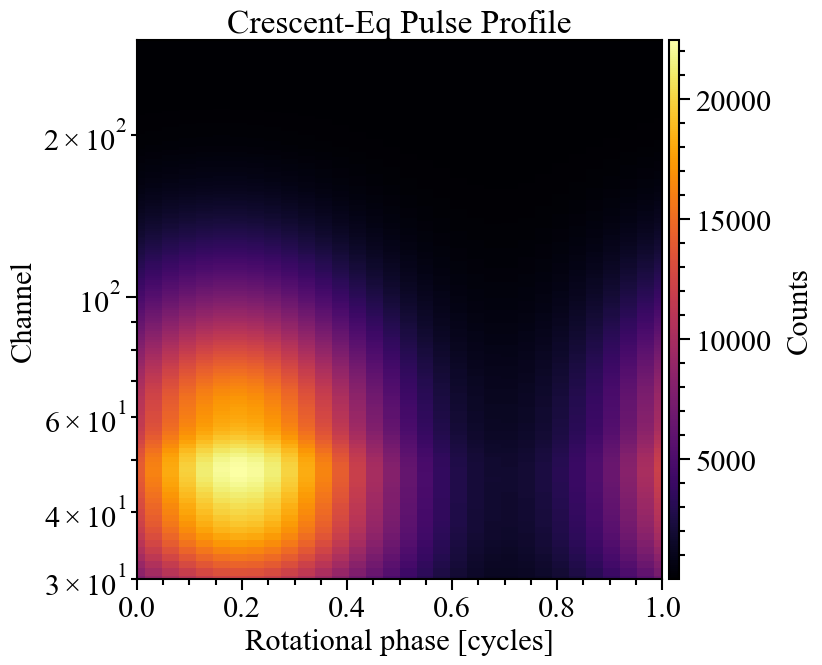

In [38]:
plot_pulse_profile(generate_pulse_profile(Crescent_Eq_UltraXPSI), r'Counts', r'Crescent-Eq Pulse Profile')

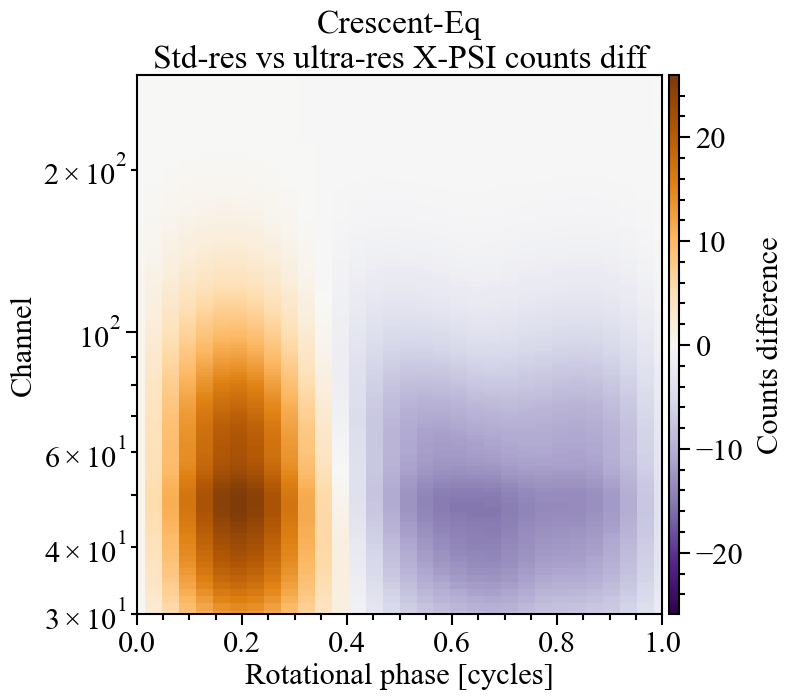

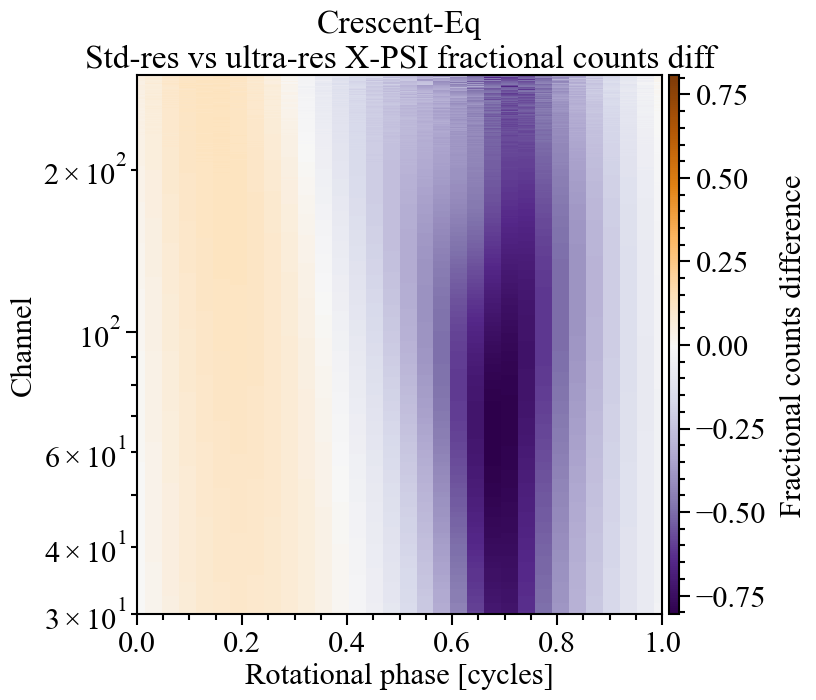

In [39]:
plot_pulse_profile(diff_Crescent_Eq_UltraXPSI_and_StdXPSI_pulse_profile, 
                   r'Counts difference', r'Crescent-Eq'+ '\n' + r'Std-res vs ultra-res X-PSI counts diff', 
                   norm='TwoSlope')

plot_pulse_profile(frac_diff_Crescent_Eq_UltraXPSI_and_StdXPSI_pulse_profile, 
                   r'Fractional counts difference', r'Crescent-Eq'+ '\n' + r'Std-res vs ultra-res X-PSI fractional counts diff', 
                   norm='TwoSlope')

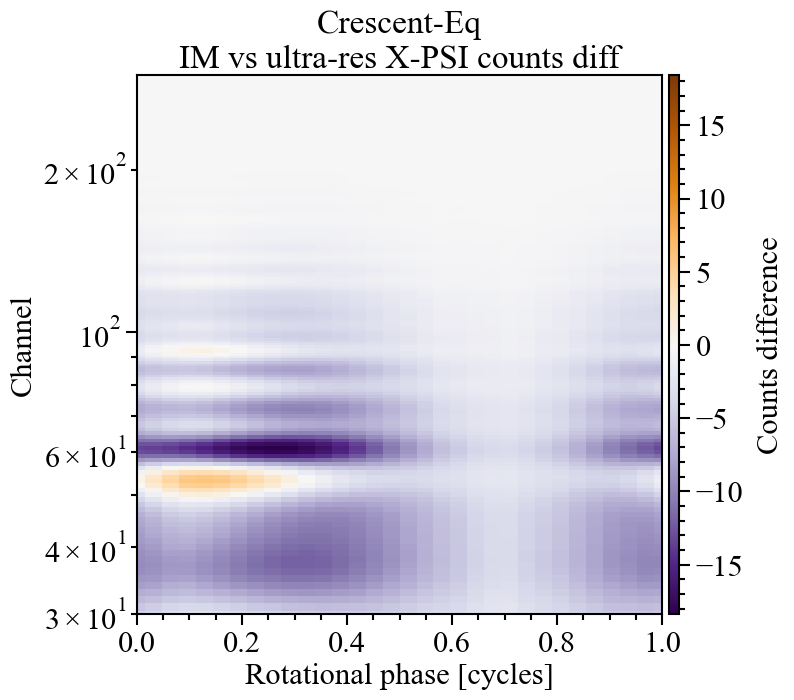

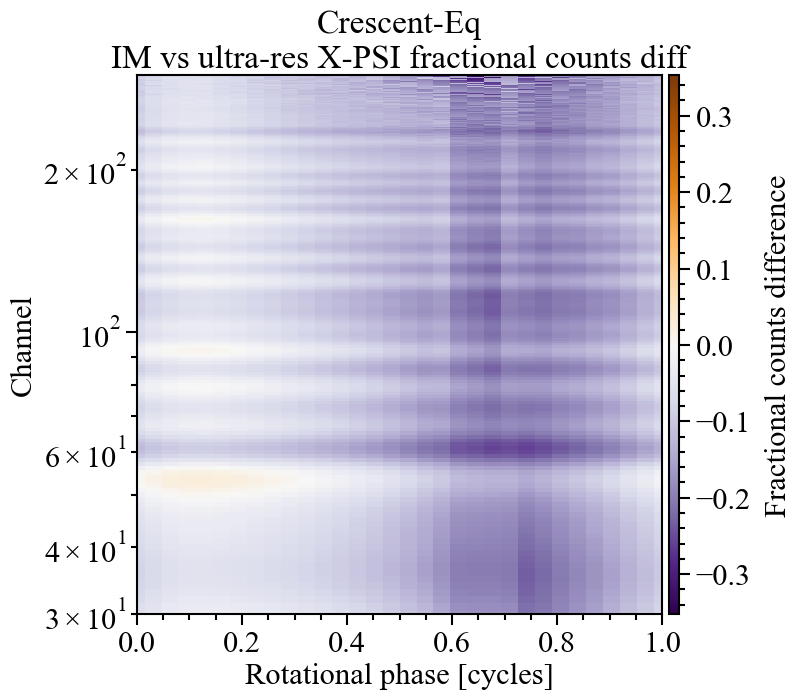

In [40]:
plot_pulse_profile(diff_Crescent_Eq_UltraXPSI_and_IM_pulse_profile, 
                   r'Counts difference', r'Crescent-Eq'+ '\n' + r'IM vs ultra-res X-PSI counts diff', 
                   norm='TwoSlope')

plot_pulse_profile(frac_diff_Crescent_Eq_UltraXPSI_and_IM_pulse_profile, 
                   r'Fractional counts difference', r'Crescent-Eq'+ '\n' + r'IM vs ultra-res X-PSI fractional counts diff', 
                   norm='TwoSlope')

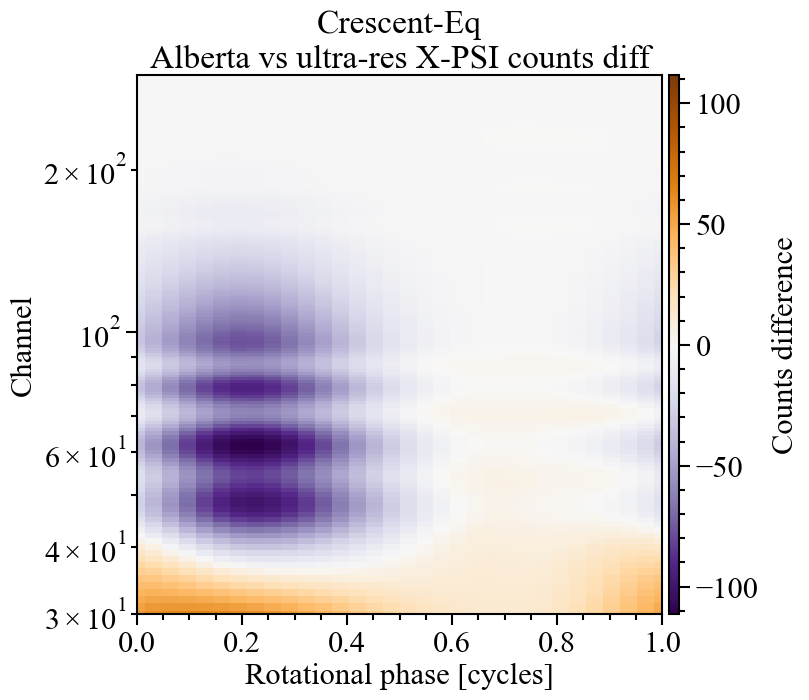

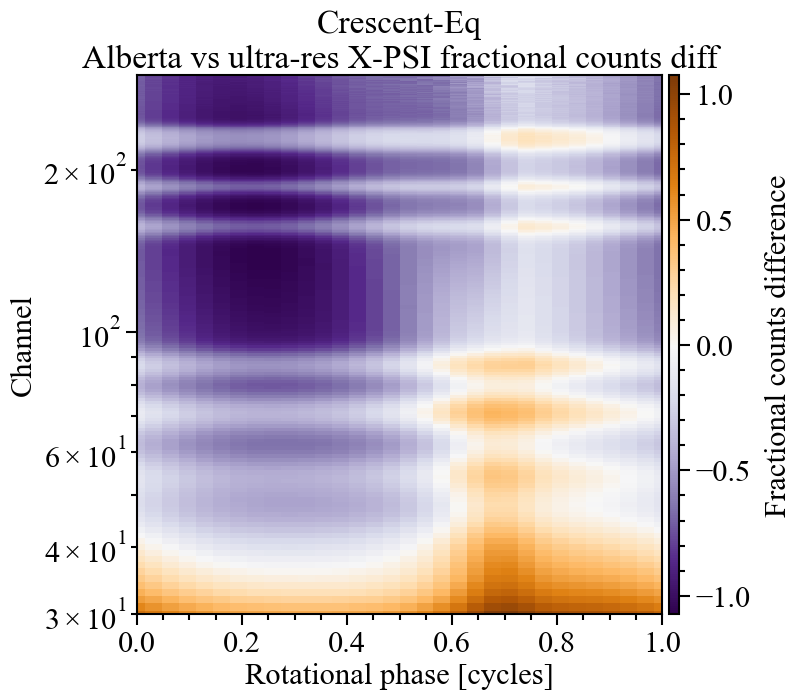

In [41]:
plot_pulse_profile(diff_Crescent_Eq_UltraXPSI_and_Alberta_pulse_profile, 
                   r'Counts difference', r'Crescent-Eq'+ '\n' + r'Alberta vs ultra-res X-PSI counts diff', 
                   norm='TwoSlope')

plot_pulse_profile(frac_diff_Crescent_Eq_UltraXPSI_and_Alberta_pulse_profile, 
                   r'Fractional counts difference', r'Crescent-Eq'+ '\n' + r'Alberta vs ultra-res X-PSI fractional counts diff',
                   norm='TwoSlope')

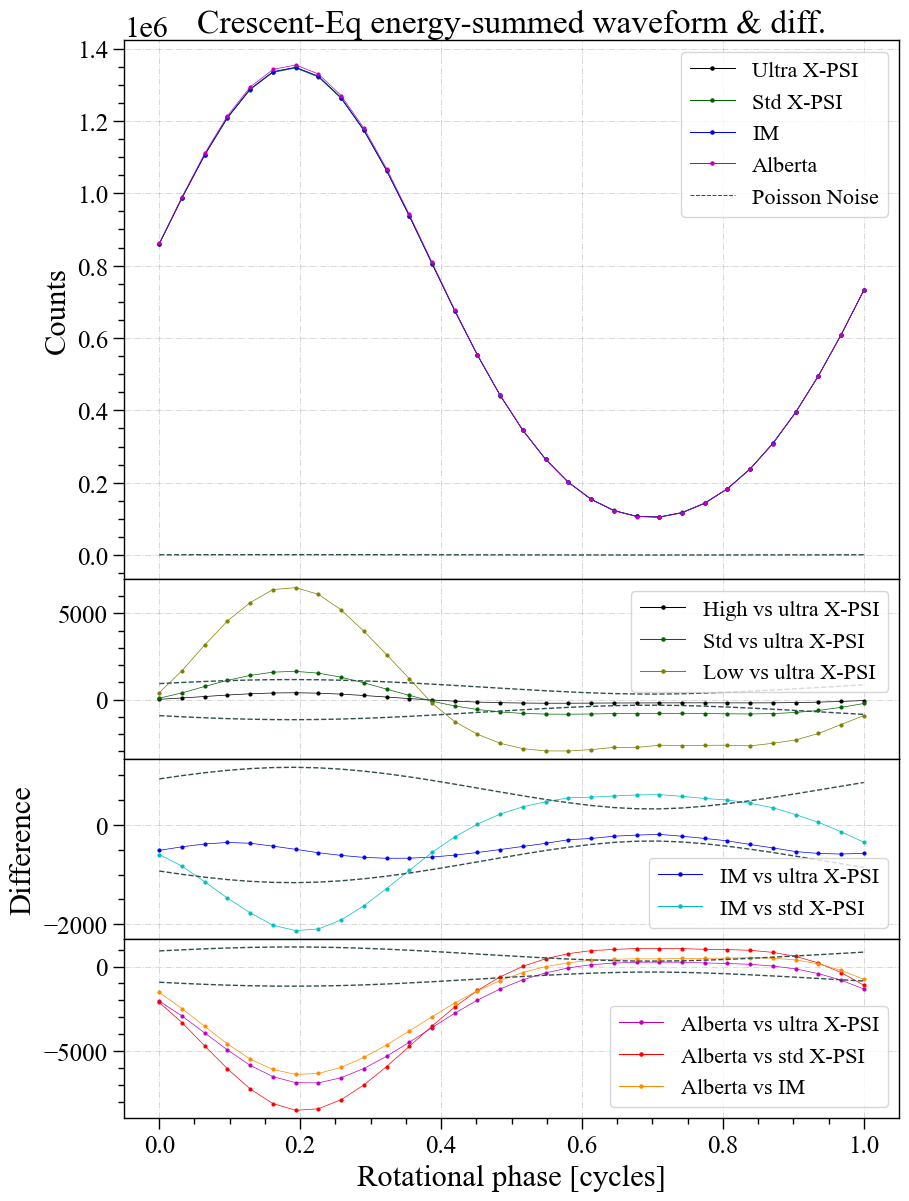

In [42]:
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(10, 14), sharex=True, gridspec_kw={'height_ratios': [3, 1, 1, 1]})

axes[0].plot(np.linspace(0.0, 1.0, 32), Crescent_Eq_UltraXPSI_energy_summed, 'o-', color='k', lw=0.5, markersize=2, label='Ultra X-PSI')
axes[0].plot(np.linspace(0.0, 1.0, 32), Crescent_Eq_StdXPSI_energy_summed, 'o-', color='darkgreen', lw=0.5, markersize=2, label='Std X-PSI')
axes[0].plot(np.linspace(0.0, 1.0, 32), Crescent_Eq_IM_energy_summed, 'o-', color='b', lw=0.5, markersize=2, label='IM')
axes[0].plot(np.linspace(0.0, 1.0, 32), Crescent_Eq_Alberta_energy_summed, 'o-', color='m', lw=0.5, markersize=2, label='Alberta')
axes[0].grid(linestyle="-.", color='grey',linewidth=0.7, alpha=0.3)
veneer(None, None, axes[0])
legend_line_thickness(axes[0].legend())
axes[0].set_ylabel('Counts')
axes[0].set_title(r'Crescent-Eq energy-summed waveform & diff.')

axes[1].plot(np.linspace(0.0, 1.0, 32), diff_Crescent_Eq_UltraXPSI_and_HiXPSI, 'o-', color='k', lw=0.5, markersize=2, label='High vs ultra X-PSI')
axes[1].plot(np.linspace(0.0, 1.0, 32), diff_Crescent_Eq_UltraXPSI_and_StdXPSI, 'o-', color='darkgreen', lw=0.5, markersize=2, label='Std vs ultra X-PSI')
axes[1].plot(np.linspace(0.0, 1.0, 32), diff_Crescent_Eq_UltraXPSI_and_LowXPSI, 'o-', color='olive', lw=0.5, markersize=2, label='Low vs ultra X-PSI')
axes[1].grid(linestyle="-.", color='grey',linewidth=0.7, alpha=0.3)
veneer(None, None, axes[1])
legend_line_thickness(axes[1].legend())

axes[2].plot(np.linspace(0.0, 1.0, 32), diff_Crescent_Eq_UltraXPSI_and_IM, 'o-', color='b', lw=0.5, markersize=2, label='IM vs ultra X-PSI')
axes[2].plot(np.linspace(0.0, 1.0, 32), diff_Crescent_Eq_StdXPSI_and_IM, 'o-', color='c', lw=0.5, markersize=2, label='IM vs std X-PSI')
axes[2].grid(linestyle="-.", color='grey',linewidth=0.7, alpha=0.3)
veneer(None, None, axes[2])
legend_line_thickness(axes[2].legend())
axes[2].set_ylabel('Difference')
axes[2].yaxis.labelpad = 5     # Adjust axis label position

axes[3].plot(np.linspace(0.0, 1.0, 32), diff_Crescent_Eq_UltraXPSI_and_Alberta, 'o-', color='m', lw=0.5, markersize=2, label='Alberta vs ultra X-PSI')
axes[3].plot(np.linspace(0.0, 1.0, 32), diff_Crescent_Eq_StdXPSI_and_Alberta, 'o-', color='r', lw=0.5, markersize=2, label='Alberta vs std X-PSI')
axes[3].plot(np.linspace(0.0, 1.0, 32), diff_Crescent_Eq_IM_and_Alberta, 'o-', color='darkorange', lw=0.5, markersize=2, label='Alberta vs IM')
axes[3].grid(linestyle="-.", color='grey',linewidth=0.7, alpha=0.3)
veneer(None, None, axes[3])
axes[3].legend()
axes[3].set_xlabel('Rotational phase [cycles]')

axes[0].plot(np.linspace(0.0, 1.0, 32), np.sqrt(Crescent_Eq_UltraXPSI_energy_summed), '--', color='darkslategrey', lw=1, markersize=2, label='Poisson Noise')
axes[1].plot(np.linspace(0.0, 1.0, 32), np.sqrt(Crescent_Eq_UltraXPSI_energy_summed), '--', color='darkslategrey', lw=1, markersize=2)
axes[1].plot(np.linspace(0.0, 1.0, 32), -np.sqrt(Crescent_Eq_UltraXPSI_energy_summed), '--', color='darkslategrey', lw=1, markersize=2)
axes[2].plot(np.linspace(0.0, 1.0, 32), np.sqrt(Crescent_Eq_UltraXPSI_energy_summed), '--', color='darkslategrey', lw=1, markersize=2)
axes[2].plot(np.linspace(0.0, 1.0, 32), -np.sqrt(Crescent_Eq_UltraXPSI_energy_summed), '--', color='darkslategrey', lw=1, markersize=2)
axes[3].plot(np.linspace(0.0, 1.0, 32), np.sqrt(Crescent_Eq_UltraXPSI_energy_summed), '--', color='darkslategrey', lw=1, markersize=2)
axes[3].plot(np.linspace(0.0, 1.0, 32), -np.sqrt(Crescent_Eq_UltraXPSI_energy_summed), '--', color='darkslategrey', lw=1, markersize=2)
legend_line_thickness(axes[0].legend())
legend_line_thickness(axes[1].legend())
legend_line_thickness(axes[2].legend())
legend_line_thickness(axes[3].legend())

plt.subplots_adjust(hspace=0)

### Figure 6 left panel

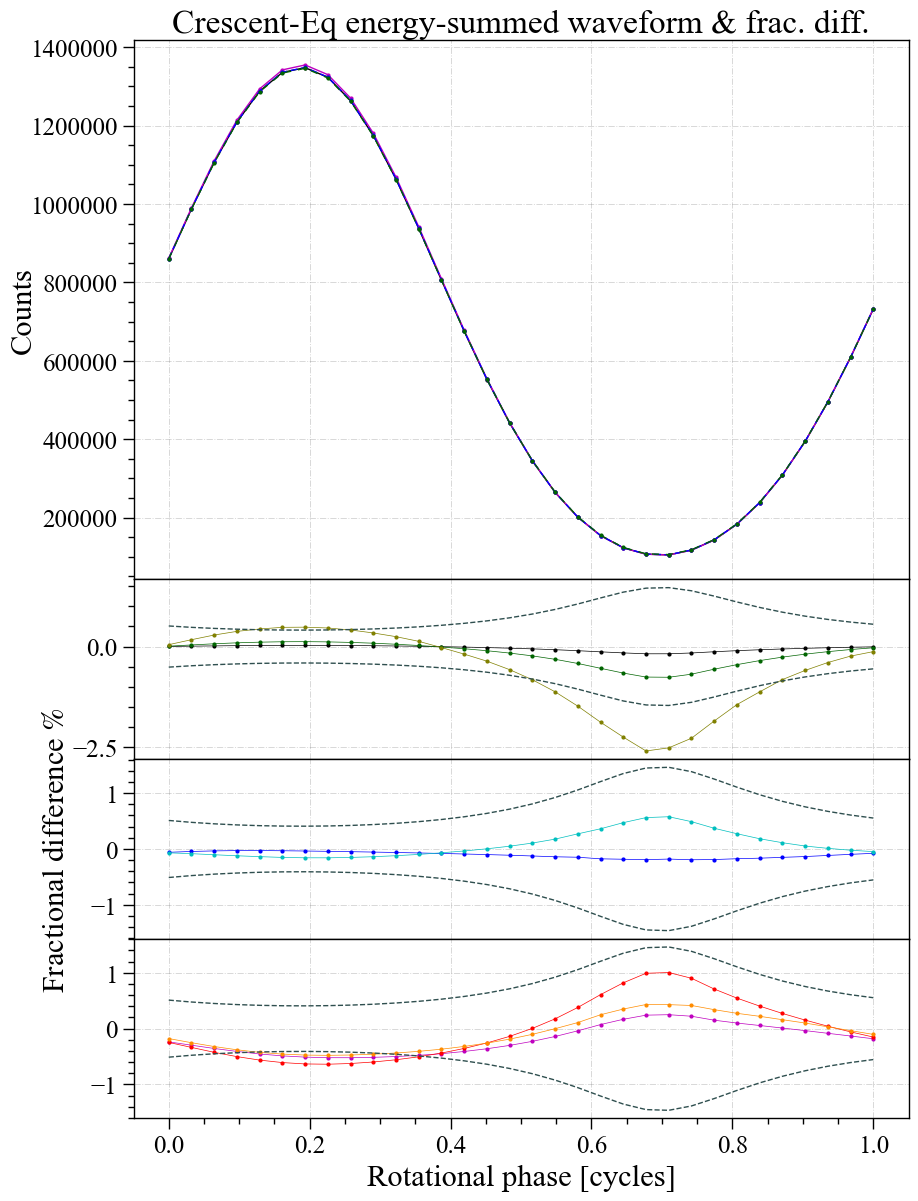

In [43]:
Crescent_Eq_noise_norm = np.sum(Crescent_Eq_UltraXPSI)/10**6
Crescent_Eq_noise = (np.sqrt(Crescent_Eq_UltraXPSI_energy_summed/Crescent_Eq_noise_norm)/(Crescent_Eq_UltraXPSI_energy_summed/Crescent_Eq_noise_norm))*100

fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(10, 14), sharex=True, gridspec_kw={'height_ratios': [3, 1, 1, 1]})

axes[0].plot(np.linspace(0.0, 1.0, 32), Crescent_Eq_UltraXPSI_energy_summed, 'o-', color='k', lw=1, markersize=2, label='Ultra X-PSI')
axes[0].plot(np.linspace(0.0, 1.0, 32), Crescent_Eq_Alberta_energy_summed, 'o-', color='m', lw=1, markersize=2, label='Alberta')
axes[0].plot(np.linspace(0.0, 1.0, 32), Crescent_Eq_IM_energy_summed, 'o--', dashes=(5, 2.5), color='b', lw=1, markersize=2, label='IM')
axes[0].plot(np.linspace(0.0, 1.0, 32), Crescent_Eq_StdXPSI_energy_summed, 'o--', dashes=(5, 5), color='darkgreen', lw=1, markersize=2, label='Std X-PSI')
axes[0].grid(linestyle="-.", color='grey',linewidth=0.7, alpha=0.3)
veneer(None, None, axes[0])
# legend_line_thickness(axes[0].legend())
axes[0].set_ylabel('Counts')
axes[0].ticklabel_format(style='plain')
axes[0].yaxis.labelpad = -5   
axes[0].set_title(r'Crescent-Eq energy-summed waveform & frac. diff.')

axes[1].plot(np.linspace(0.0, 1.0, 32), frac_diff_Crescent_Eq_UltraXPSI_and_HiXPSI, 'o-', color='k', lw=0.5, markersize=2, label='High vs ultra X-PSI')
axes[1].plot(np.linspace(0.0, 1.0, 32), frac_diff_Crescent_Eq_UltraXPSI_and_StdXPSI, 'o-', color='darkgreen', lw=0.5, markersize=2, label='Std vs ultra X-PSI')
axes[1].plot(np.linspace(0.0, 1.0, 32), frac_diff_Crescent_Eq_UltraXPSI_and_LowXPSI, 'o-', color='olive', lw=0.5, markersize=2, label='Low vs ultra X-PSI')
axes[1].plot(np.linspace(0.0, 1.0, 32), Crescent_Eq_noise, '--', color='darkslategrey', lw=1, markersize=2)
axes[1].plot(np.linspace(0.0, 1.0, 32), -Crescent_Eq_noise, '--', color='darkslategrey', lw=1, markersize=2)
axes[1].grid(linestyle="-.", color='grey',linewidth=0.7, alpha=0.3)
veneer(None, None, axes[1])
# legend_line_thickness(axes[1].legend())

axes[2].plot(np.linspace(0.0, 1.0, 32), frac_diff_Crescent_Eq_UltraXPSI_and_IM, 'o-', color='b', lw=0.5, markersize=2, label='IM vs ultra X-PSI')
axes[2].plot(np.linspace(0.0, 1.0, 32), frac_diff_Crescent_Eq_StdXPSI_and_IM, 'o-', color='c', lw=0.5, markersize=2, label='IM vs std X-PSI')
axes[2].plot(np.linspace(0.0, 1.0, 32), Crescent_Eq_noise, '--', color='darkslategrey', lw=1, markersize=2)
axes[2].plot(np.linspace(0.0, 1.0, 32), -Crescent_Eq_noise, '--', color='darkslategrey', lw=1, markersize=2)
axes[2].grid(linestyle="-.", color='grey',linewidth=0.7, alpha=0.3)
veneer(None, None, axes[2])
# legend_line_thickness(axes[2].legend())
axes[2].set_ylabel('Fractional difference $\%$')
axes[2].yaxis.labelpad = 15     # Adjust axis label position

axes[3].plot(np.linspace(0.0, 1.0, 32), frac_diff_Crescent_Eq_UltraXPSI_and_Alberta, 'o-', color='m', lw=0.5, markersize=2, label='Alberta vs ultra X-PSI')
axes[3].plot(np.linspace(0.0, 1.0, 32), frac_diff_Crescent_Eq_StdXPSI_and_Alberta, 'o-', color='r', lw=0.5, markersize=2, label='Alberta vs std X-PSI')
axes[3].plot(np.linspace(0.0, 1.0, 32), frac_diff_Crescent_Eq_IM_and_Alberta, 'o-', color='darkorange', lw=0.5, markersize=2, label='Alberta vs IM')
axes[3].plot(np.linspace(0.0, 1.0, 32), Crescent_Eq_noise, '--', color='darkslategrey', lw=1, markersize=2)
axes[3].plot(np.linspace(0.0, 1.0, 32), -Crescent_Eq_noise, '--', color='darkslategrey', lw=1, markersize=2)
axes[3].grid(linestyle="-.", color='grey',linewidth=0.7, alpha=0.3)
veneer(None, None, axes[3])
# legend_line_thickness(axes[3].legend(framealpha=0.6))
axes[3].set_xlabel('Rotational phase [cycles]')

plt.subplots_adjust(hspace=0)

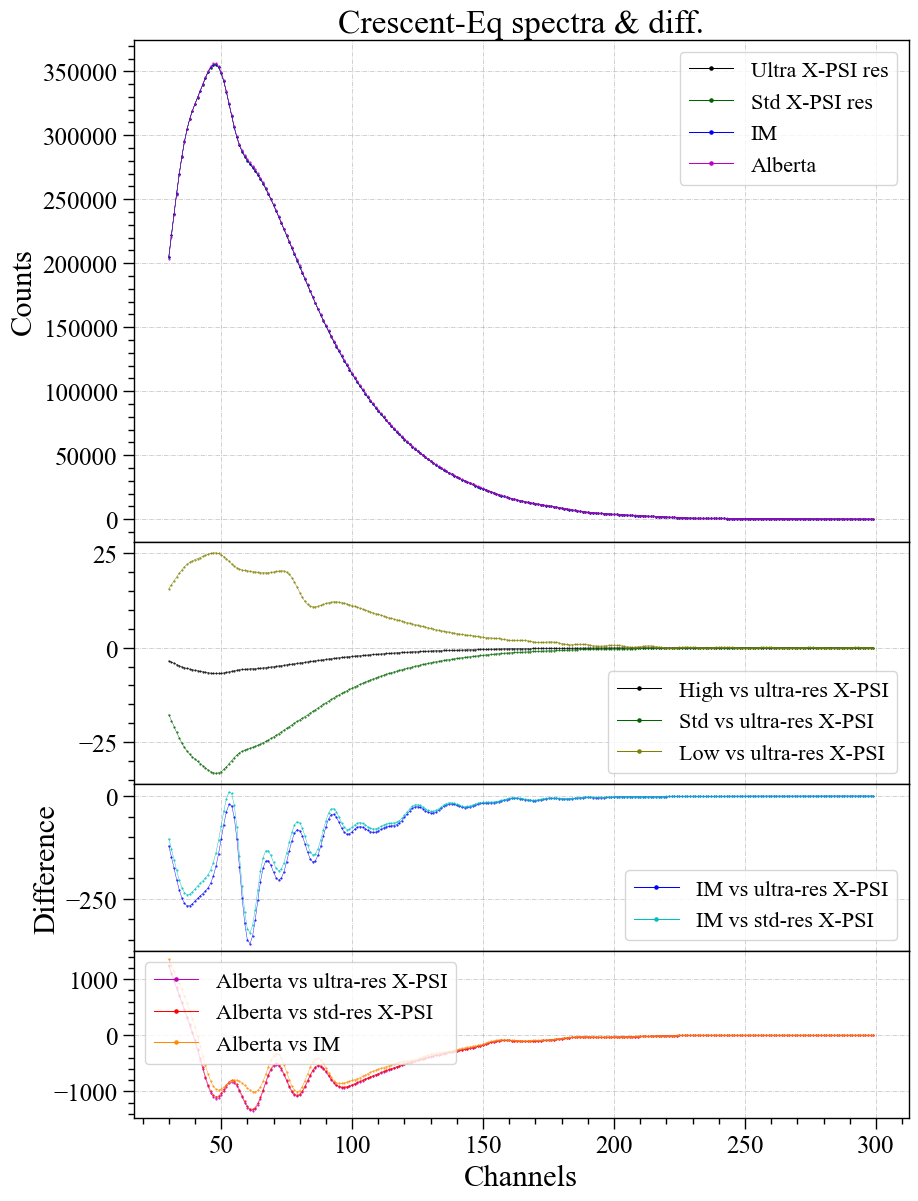

In [44]:
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(10, 14), sharex=True, gridspec_kw={'height_ratios': [3, 1.45, 1, 1]})

axes[0].plot(Crescent_Eq_UltraXPSI_spectrum[:, 0], Crescent_Eq_UltraXPSI_spectrum[:, 1], 'o-', color='k', lw=0.3, markersize=0.5, label='Ultra X-PSI res')
axes[0].plot(Crescent_Eq_UltraXPSI_spectrum[:, 0], Crescent_Eq_StdXPSI_spectrum[:, 1], 'o-', color='darkgreen', lw=0.3, markersize=0.5, label='Std X-PSI res')
axes[0].plot(Crescent_Eq_UltraXPSI_spectrum[:, 0], Crescent_Eq_IM_spectrum[:, 1], 'o-', color='b', lw=0.3, markersize=0.5, label='IM')
axes[0].plot(Crescent_Eq_UltraXPSI_spectrum[:, 0], Crescent_Eq_Alberta_spectrum[:, 1], 'o-', color='m', lw=0.3, markersize=0.5, label='Alberta')
axes[0].grid(linestyle="-.", color='grey',linewidth=0.5, alpha=0.5)
veneer(None, None, axes[0])
legend_line_thickness(axes[0].legend())
axes[0].set_ylabel('Counts')
axes[0].set_title(r'Crescent-Eq spectra & diff.')

axes[1].plot(Crescent_Eq_UltraXPSI_spectrum[:, 0], spec_diff_Crescent_Eq_UltraXPSI_and_HiXPSI, 'o-', color='k', lw=0.3, markersize=0.5, label='High vs ultra-res X-PSI')
axes[1].plot(Crescent_Eq_UltraXPSI_spectrum[:, 0], spec_diff_Crescent_Eq_UltraXPSI_and_StdXPSI, 'o-', color='darkgreen', lw=0.3, markersize=0.5, label='Std vs ultra-res X-PSI')
axes[1].plot(Crescent_Eq_UltraXPSI_spectrum[:, 0], spec_diff_Crescent_Eq_UltraXPSI_and_LowXPSI, 'o-', color='olive', lw=0.3, markersize=0.5, label='Low vs ultra-res X-PSI')
axes[1].grid(linestyle="-.", color='grey',linewidth=0.5, alpha=0.5)
veneer(None, None, axes[1])
legend_line_thickness(axes[1].legend())

axes[2].plot(Crescent_Eq_UltraXPSI_spectrum[:, 0], spec_diff_Crescent_Eq_UltraXPSI_and_IM, 'o-', color='b', lw=0.3, markersize=0.5, label='IM vs ultra-res X-PSI')
axes[2].plot(Crescent_Eq_UltraXPSI_spectrum[:, 0], spec_diff_Crescent_Eq_StdXPSI_and_IM, 'o-', color='c', lw=0.3, markersize=0.5, label='IM vs std-res X-PSI')
axes[2].grid(linestyle="-.", color='grey',linewidth=0.5, alpha=0.5)
veneer(None, None, axes[2])
legend_line_thickness(axes[2].legend())
axes[2].set_ylabel('Difference')
# axes[2].yaxis.labelpad = 15     # Adjust axis label position

axes[3].plot(Crescent_Eq_UltraXPSI_spectrum[:, 0], spec_diff_Crescent_Eq_UltraXPSI_and_Alberta, 'o-', color='m', lw=0.3, markersize=0.5, label='Alberta vs ultra-res X-PSI')
axes[3].plot(Crescent_Eq_UltraXPSI_spectrum[:, 0], spec_diff_Crescent_Eq_StdXPSI_and_Alberta, 'o-', color='r', lw=0.3, markersize=0.5, label='Alberta vs std-res X-PSI')
axes[3].plot(Crescent_Eq_UltraXPSI_spectrum[:, 0], spec_diff_Crescent_Eq_IM_and_Alberta, 'o-', color='darkorange', lw=0.3, markersize=0.5, label='Alberta vs IM')
axes[3].grid(linestyle="-.", color='grey',linewidth=0.5, alpha=0.5)
veneer(None, None, axes[3])
legend_line_thickness(axes[3].legend())
axes[3].set_xlabel('Channels')

plt.subplots_adjust(hspace=0)

### Figure 6 right panel

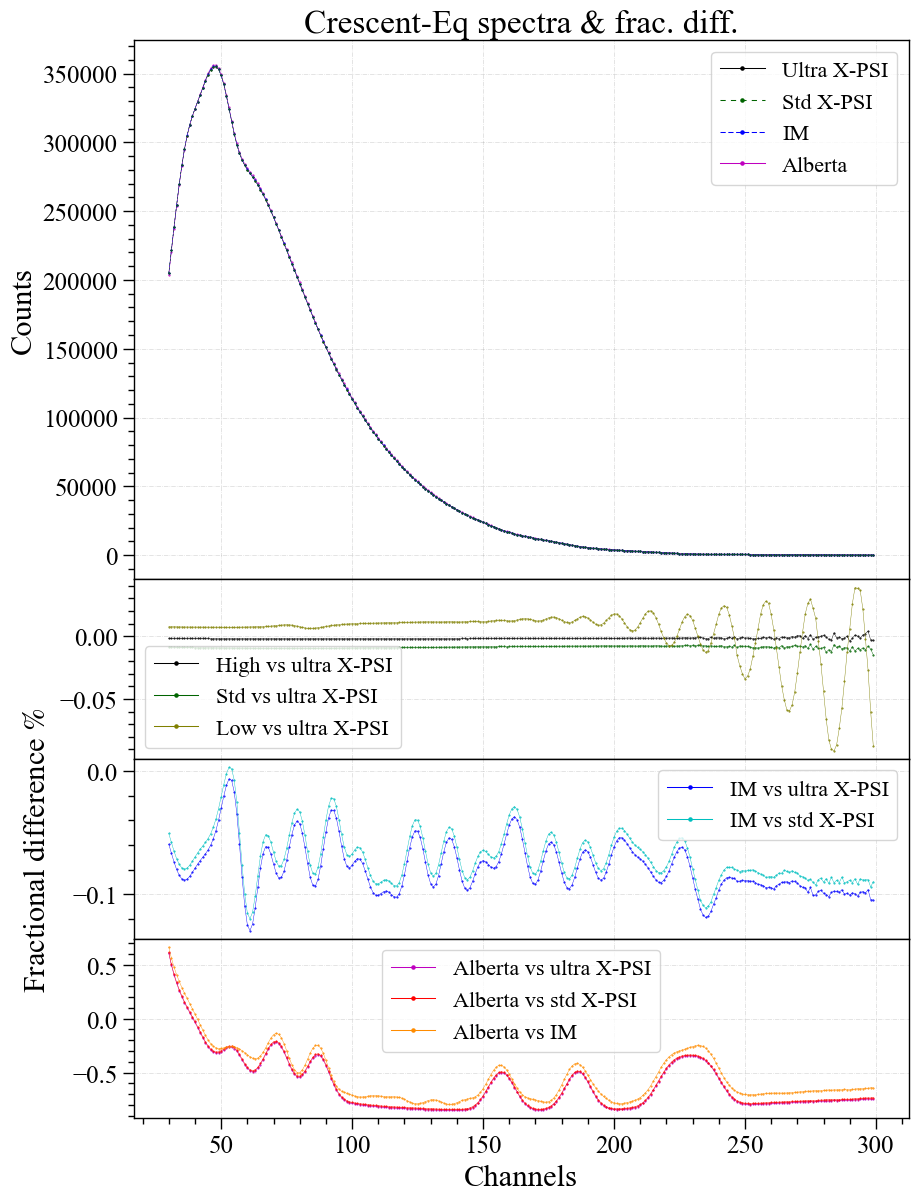

In [45]:
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(10, 14), sharex=True, gridspec_kw={'height_ratios': [3, 1, 1, 1]})

l1, = axes[0].plot(Crescent_Eq_UltraXPSI_spectrum[:, 0], Crescent_Eq_UltraXPSI_spectrum[:, 1], 'o-', color='k', lw=0.3, markersize=0.5, label='Ultra X-PSI')
l2, = axes[0].plot(Crescent_Eq_UltraXPSI_spectrum[:, 0], Crescent_Eq_Alberta_spectrum[:, 1], 'o-', color='m', lw=0.3, markersize=0.5, label='Alberta')
l3, = axes[0].plot(Crescent_Eq_UltraXPSI_spectrum[:, 0], Crescent_Eq_IM_spectrum[:, 1], 'o--', dashes=(5, 2.5), color='b', lw=0.3, markersize=0.5, label='IM')
l4, = axes[0].plot(Crescent_Eq_UltraXPSI_spectrum[:, 0], Crescent_Eq_StdXPSI_spectrum[:, 1], 'o--', dashes=(5, 5), color='darkgreen', lw=0.3, markersize=0.5, label='Std X-PSI')
axes[0].grid(linestyle="-.", color='grey',linewidth=0.5, alpha=0.3)
veneer(None, None, axes[0])
handles = [l1, l4, l3, l2]
labels = [line.get_label() for line in handles]
legend_line_thickness(axes[0].legend(handles, labels))
#axes[0].ticklabel_format(axis='y', style='sci', scilimits=(0,0))  # Scientific notation used for y-axis
axes[0].set_ylabel('Counts')
axes[0].set_title(r'Crescent-Eq spectra & frac. diff.')

axes[1].plot(Crescent_Eq_UltraXPSI_spectrum[:, 0], spec_frac_diff_Crescent_Eq_UltraXPSI_and_HiXPSI, 'o-', color='k', lw=0.3, markersize=0.5, label='High vs ultra X-PSI')
axes[1].plot(Crescent_Eq_UltraXPSI_spectrum[:, 0], spec_frac_diff_Crescent_Eq_UltraXPSI_and_StdXPSI, 'o-', color='darkgreen', lw=0.3, markersize=0.5, label='Std vs ultra X-PSI')
axes[1].plot(Crescent_Eq_UltraXPSI_spectrum[:, 0], spec_frac_diff_Crescent_Eq_UltraXPSI_and_LowXPSI, 'o-', color='olive', lw=0.3, markersize=0.5, label='Low vs ultra X-PSI')
axes[1].grid(linestyle="-.", color='grey',linewidth=0.5, alpha=0.3)
veneer(None, None, axes[1])
legend_line_thickness(axes[1].legend(loc='lower left'))
#axes[1].ticklabel_format(axis='y', style='sci', scilimits=(-1,-1))  # Scientific notation used for y-axis

axes[2].plot(Crescent_Eq_UltraXPSI_spectrum[:, 0], spec_frac_diff_Crescent_Eq_UltraXPSI_and_IM, 'o-', color='b', lw=0.3, markersize=0.5, label='IM vs ultra X-PSI')
axes[2].plot(Crescent_Eq_UltraXPSI_spectrum[:, 0], spec_frac_diff_Crescent_Eq_StdXPSI_and_IM, 'o-', color='c', lw=0.3, markersize=0.5, label='IM vs std X-PSI')
axes[2].grid(linestyle="-.", color='grey',linewidth=0.5, alpha=0.3)
veneer(None, None, axes[2])
# Manually adjust yticklabels for axes[2] since it overlaps with axes[3]
# yticks_3 = axes[2].get_yticks()
# yticklabels_3 = ['' if i==0 or i==4 else label.get_text() for i, label in enumerate(axes[2].get_yticklabels())]
# axes[2].set_yticks(yticks_3)
# axes[2].set_yticklabels(yticklabels_3)
# axes[2].set_ylim(-0.0006)
legend_line_thickness(axes[2].legend())
#axes[2].ticklabel_format(axis='y', style='sci', scilimits=(0,0))  # Scientific notation used for y-axis
axes[2].set_ylabel('Fractional difference $\%$')
axes[2].yaxis.labelpad = 15     # Adjust axis label position

axes[3].plot(Crescent_Eq_UltraXPSI_spectrum[:, 0], spec_frac_diff_Crescent_Eq_UltraXPSI_and_Alberta, 'o-', color='m', lw=0.3, markersize=0.5, label='Alberta vs ultra X-PSI')
axes[3].plot(Crescent_Eq_UltraXPSI_spectrum[:, 0], spec_frac_diff_Crescent_Eq_StdXPSI_and_Alberta, 'o-', color='r', lw=0.3, markersize=0.5, label='Alberta vs std X-PSI')
axes[3].plot(Crescent_Eq_UltraXPSI_spectrum[:, 0], spec_frac_diff_Crescent_Eq_IM_and_Alberta, 'o-', color='darkorange', lw=0.3, markersize=0.5, label='Alberta vs IM')
axes[3].grid(linestyle="-.", color='grey',linewidth=0.5, alpha=0.3)
veneer(None, None, axes[3])
legend_line_thickness(axes[3].legend())
axes[3].set_xlabel('Channels')

plt.subplots_adjust(hspace=0)

# Comparing Bithermal spot

In [46]:
# Loading data from files
Bithermal_LowXPSI = np.loadtxt('./Pulse_profiles_by_diff_codes/XPSI/Low_res/Bithermal_expected_hreadable.dat')
Bithermal_StdXPSI = np.loadtxt('./Pulse_profiles_by_diff_codes/XPSI/Std_res/Bithermal_expected_hreadable.dat')
Bithermal_HiXPSI = np.loadtxt('./Pulse_profiles_by_diff_codes/XPSI/Hi_res/Bithermal_expected_hreadable.dat')
Bithermal_UltraXPSI = np.loadtxt('./Pulse_profiles_by_diff_codes/XPSI/Ultra_res/Bithermal_expected_hreadable.dat')
Bithermal_IM_full = np.loadtxt('./Pulse_profiles_by_diff_codes/IM/Bithermal.txt')
Bithermal_IM = Bithermal_IM_full[:, [0, 1, 3]]

# Energy summed waveforms
Bithermal_LowXPSI_energy_summed = generate_energy_summed_waveform(Bithermal_LowXPSI)
Bithermal_StdXPSI_energy_summed = generate_energy_summed_waveform(Bithermal_StdXPSI)
Bithermal_HiXPSI_energy_summed = generate_energy_summed_waveform(Bithermal_HiXPSI)
Bithermal_UltraXPSI_energy_summed = generate_energy_summed_waveform(Bithermal_UltraXPSI)
Bithermal_IM_energy_summed = generate_energy_summed_waveform(Bithermal_IM)

# Diff in energy summed waveforms
diff_Bithermal_UltraXPSI_and_LowXPSI = diff(Bithermal_UltraXPSI_energy_summed, Bithermal_LowXPSI_energy_summed)
diff_Bithermal_UltraXPSI_and_StdXPSI = diff(Bithermal_UltraXPSI_energy_summed, Bithermal_StdXPSI_energy_summed)
diff_Bithermal_UltraXPSI_and_HiXPSI = diff(Bithermal_UltraXPSI_energy_summed, Bithermal_HiXPSI_energy_summed)
diff_Bithermal_UltraXPSI_and_IM = diff(Bithermal_UltraXPSI_energy_summed, Bithermal_IM_energy_summed)
diff_Bithermal_StdXPSI_and_IM = diff(Bithermal_StdXPSI_energy_summed, Bithermal_IM_energy_summed)

# Fractional diff in energy summed waveforms
frac_diff_Bithermal_UltraXPSI_and_LowXPSI = fractional_diff(Bithermal_UltraXPSI_energy_summed, Bithermal_LowXPSI_energy_summed)
frac_diff_Bithermal_UltraXPSI_and_StdXPSI = fractional_diff(Bithermal_UltraXPSI_energy_summed, Bithermal_StdXPSI_energy_summed)
frac_diff_Bithermal_UltraXPSI_and_HiXPSI = fractional_diff(Bithermal_UltraXPSI_energy_summed, Bithermal_HiXPSI_energy_summed)
frac_diff_Bithermal_UltraXPSI_and_IM = fractional_diff(Bithermal_UltraXPSI_energy_summed, Bithermal_IM_energy_summed)
frac_diff_Bithermal_StdXPSI_and_IM = fractional_diff(Bithermal_StdXPSI_energy_summed, Bithermal_IM_energy_summed)

# Spectra
Bithermal_LowXPSI_spectrum = generate_spectrum(Bithermal_LowXPSI)
Bithermal_StdXPSI_spectrum = generate_spectrum(Bithermal_StdXPSI)
Bithermal_HiXPSI_spectrum = generate_spectrum(Bithermal_HiXPSI)
Bithermal_UltraXPSI_spectrum = generate_spectrum(Bithermal_UltraXPSI)
Bithermal_IM_spectrum = generate_spectrum(Bithermal_IM)

# Diff in spectra
spec_diff_Bithermal_UltraXPSI_and_LowXPSI = diff(Bithermal_UltraXPSI_spectrum[:,1], Bithermal_LowXPSI_spectrum[:,1])
spec_diff_Bithermal_UltraXPSI_and_StdXPSI = diff(Bithermal_UltraXPSI_spectrum[:,1], Bithermal_StdXPSI_spectrum[:,1])
spec_diff_Bithermal_UltraXPSI_and_HiXPSI = diff(Bithermal_UltraXPSI_spectrum[:,1], Bithermal_HiXPSI_spectrum[:,1])
spec_diff_Bithermal_UltraXPSI_and_IM = diff(Bithermal_UltraXPSI_spectrum[:,1], Bithermal_IM_spectrum[:,1])
spec_diff_Bithermal_StdXPSI_and_IM = diff(Bithermal_StdXPSI_spectrum[:,1], Bithermal_IM_spectrum[:,1])

# Fractional diff in spectra
spec_frac_diff_Bithermal_UltraXPSI_and_LowXPSI = fractional_diff(Bithermal_UltraXPSI_spectrum[:,1], Bithermal_LowXPSI_spectrum[:,1])
spec_frac_diff_Bithermal_UltraXPSI_and_StdXPSI = fractional_diff(Bithermal_UltraXPSI_spectrum[:,1], Bithermal_StdXPSI_spectrum[:,1])
spec_frac_diff_Bithermal_UltraXPSI_and_HiXPSI = fractional_diff(Bithermal_UltraXPSI_spectrum[:,1], Bithermal_HiXPSI_spectrum[:,1])
spec_frac_diff_Bithermal_UltraXPSI_and_IM = fractional_diff(Bithermal_UltraXPSI_spectrum[:,1], Bithermal_IM_spectrum[:,1])
spec_frac_diff_Bithermal_StdXPSI_and_IM = fractional_diff(Bithermal_StdXPSI_spectrum[:,1], Bithermal_IM_spectrum[:,1])

# Pulse profiles
Bithermal_LowXPSI_pulse_profile = generate_pulse_profile(Bithermal_LowXPSI)
Bithermal_StdXPSI_pulse_profile = generate_pulse_profile(Bithermal_StdXPSI)
Bithermal_HiXPSI_pulse_profile = generate_pulse_profile(Bithermal_HiXPSI)
Bithermal_UltraXPSI_pulse_profile = generate_pulse_profile(Bithermal_UltraXPSI)
Bithermal_IM_pulse_profile = generate_pulse_profile(Bithermal_IM)

# Difference in pulse profiles
diff_Bithermal_UltraXPSI_and_LowXPSI_pulse_profile = diff(Bithermal_UltraXPSI_pulse_profile, Bithermal_LowXPSI_pulse_profile)
diff_Bithermal_UltraXPSI_and_StdXPSI_pulse_profile = diff(Bithermal_UltraXPSI_pulse_profile, Bithermal_StdXPSI_pulse_profile)
diff_Bithermal_UltraXPSI_and_HiXPSI_pulse_profile = diff(Bithermal_UltraXPSI_pulse_profile, Bithermal_HiXPSI_pulse_profile)
diff_Bithermal_UltraXPSI_and_IM_pulse_profile = diff(Bithermal_UltraXPSI_pulse_profile, Bithermal_IM_pulse_profile)
diff_Bithermal_StdXPSI_and_IM_pulse_profile = diff(Bithermal_StdXPSI_pulse_profile, Bithermal_IM_pulse_profile)

# Fractional difference in pulse profiles when counts are above a certain counts threshold
frac_diff_Bithermal_UltraXPSI_and_LowXPSI_pulse_profile = fractional_diff(Bithermal_UltraXPSI_pulse_profile, Bithermal_LowXPSI_pulse_profile)
frac_diff_Bithermal_UltraXPSI_and_StdXPSI_pulse_profile = fractional_diff(Bithermal_UltraXPSI_pulse_profile, Bithermal_StdXPSI_pulse_profile)
frac_diff_Bithermal_UltraXPSI_and_HiXPSI_pulse_profile = fractional_diff(Bithermal_UltraXPSI_pulse_profile, Bithermal_HiXPSI_pulse_profile)
frac_diff_Bithermal_UltraXPSI_and_IM_pulse_profile = fractional_diff(Bithermal_UltraXPSI_pulse_profile, Bithermal_IM_pulse_profile)
frac_diff_Bithermal_StdXPSI_and_IM_pulse_profile = fractional_diff(Bithermal_StdXPSI_pulse_profile, Bithermal_IM_pulse_profile)

# Max fractional differences for energy-summed waveforms
print('Max fractional difference for energy summed waveforms: \n')
print('\t X-PSI Ultra and Low settings:', np.max(np.abs(frac_diff_Bithermal_UltraXPSI_and_LowXPSI)))
print('\t X-PSI Ultra and Std settings:', np.max(np.abs(frac_diff_Bithermal_UltraXPSI_and_StdXPSI)))
print('\t X-PSI Ultra and High settings:', np.max(np.abs(frac_diff_Bithermal_UltraXPSI_and_HiXPSI)))
print('\t X-PSI Ultra and IM:', np.max(np.abs(frac_diff_Bithermal_UltraXPSI_and_IM)))
print('\t X-PSI Std settings and IM:', np.max(np.abs(frac_diff_Bithermal_StdXPSI_and_IM)))

# Max fractional differences for spectra
print('\nMax fractional difference for spectra: \n')
print('\t X-PSI Ultra and Low settings:', np.max(np.abs(spec_frac_diff_Bithermal_UltraXPSI_and_LowXPSI)))
print('\t X-PSI Ultra and Std settings:', np.max(np.abs(spec_frac_diff_Bithermal_UltraXPSI_and_StdXPSI)))
print('\t X-PSI Ultra and High settings:', np.max(np.abs(spec_frac_diff_Bithermal_UltraXPSI_and_HiXPSI)))
print('\t X-PSI Ultra and IM:', np.max(np.abs(spec_frac_diff_Bithermal_UltraXPSI_and_IM)))
print('\t X-PSI Std settings and IM:', np.max(np.abs(spec_frac_diff_Bithermal_StdXPSI_and_IM)))

# Max fractional difference in pulse profiles
print('\nMax fractional difference for pulse profiles: \n')
print('\t X-PSI Ultra and Low settings:', np.max(np.abs(frac_diff_Bithermal_UltraXPSI_and_LowXPSI_pulse_profile)))
print('\t X-PSI Ultra and Std settings:', np.max(np.abs(frac_diff_Bithermal_UltraXPSI_and_StdXPSI_pulse_profile)))
print('\t X-PSI Ultra and High settings:', np.max(np.abs(frac_diff_Bithermal_UltraXPSI_and_HiXPSI_pulse_profile)))
print('\t X-PSI Ultra and IM:', np.max(np.abs(frac_diff_Bithermal_UltraXPSI_and_IM_pulse_profile)))
print('\t X-PSI Std settings and IM:', np.max(np.abs(frac_diff_Bithermal_StdXPSI_and_IM_pulse_profile)))

Max fractional difference for energy summed waveforms: 

	 X-PSI Ultra and Low settings: 0.025033888819751843
	 X-PSI Ultra and Std settings: 0.00662505342969753
	 X-PSI Ultra and High settings: 0.0015579263225478012
	 X-PSI Ultra and IM: 5.108429564619365
	 X-PSI Std settings and IM: 5.114314008546776

Max fractional difference for spectra: 

	 X-PSI Ultra and Low settings: 0.0895094880057267
	 X-PSI Ultra and Std settings: 0.029815146094212576
	 X-PSI Ultra and High settings: 0.02896032435561673
	 X-PSI Ultra and IM: 5.879046894209957
	 X-PSI Std settings and IM: 5.877944826940191

Max fractional difference for pulse profiles: 

	 X-PSI Ultra and Low settings: 1.0101010101010108
	 X-PSI Ultra and Std settings: 1.0101010101010108
	 X-PSI Ultra and High settings: 0.980392156862746
	 X-PSI Ultra and IM: 7.1428571428571495
	 X-PSI Std settings and IM: 7.1428571428571495


### Figure 2 bottom panel

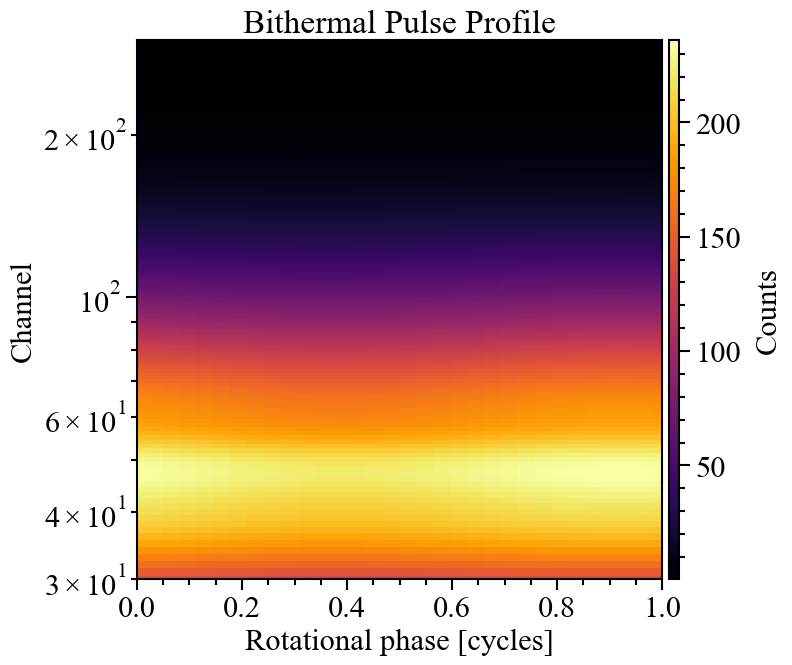

In [47]:
plot_pulse_profile(generate_pulse_profile(Bithermal_UltraXPSI), r'Counts', r'Bithermal Pulse Profile')

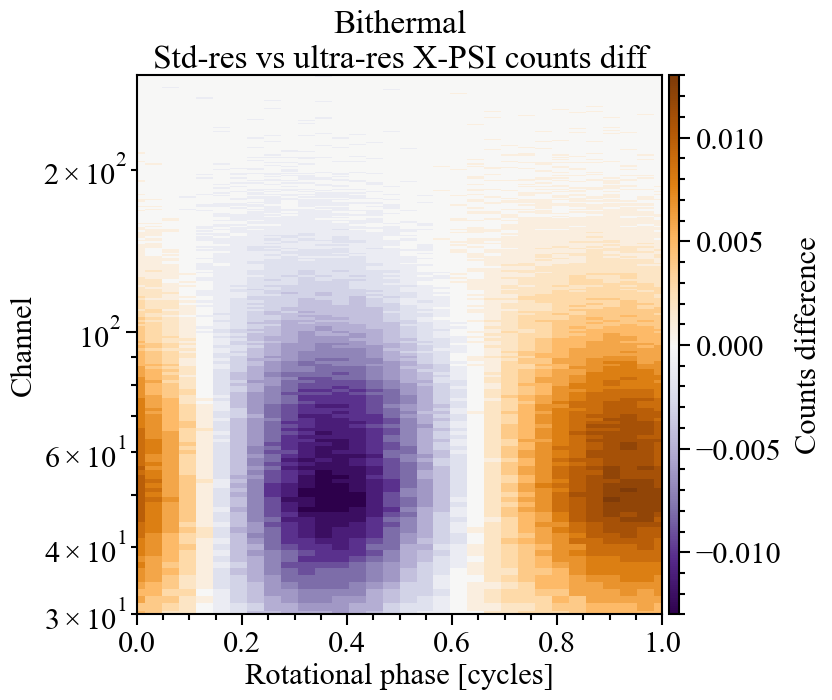

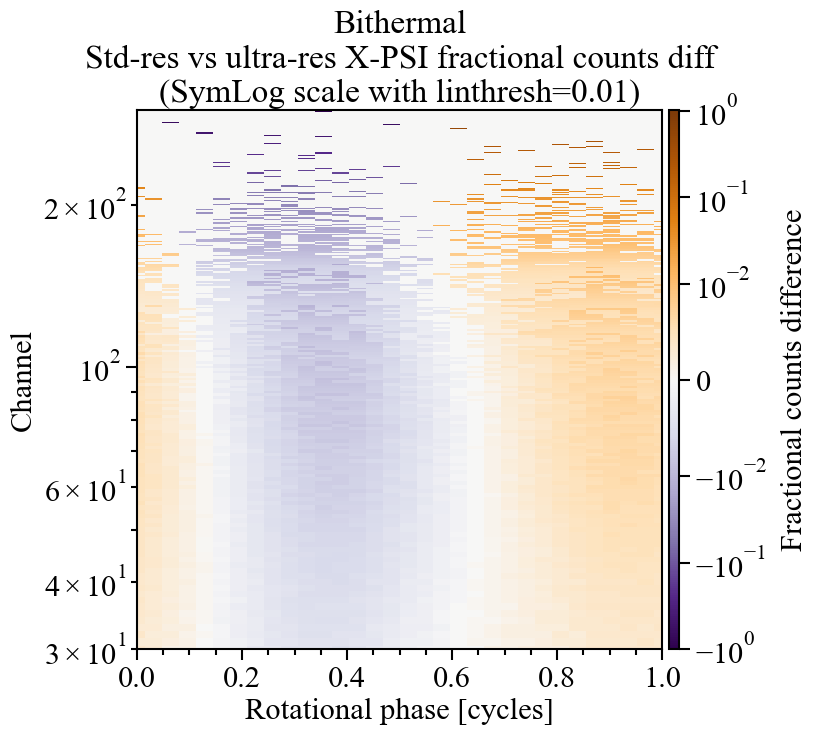

In [48]:
plot_pulse_profile(diff_Bithermal_UltraXPSI_and_StdXPSI_pulse_profile, 
                   r'Counts difference', r'Bithermal'+ '\n' + r'Std-res vs ultra-res X-PSI counts diff', 
                   norm='TwoSlope')

plot_pulse_profile(frac_diff_Bithermal_UltraXPSI_and_StdXPSI_pulse_profile, 
                   r'Fractional counts difference', r'Bithermal'+ '\n' + r'Std-res vs ultra-res X-PSI fractional counts diff'+ '\n' + r'(SymLog scale with linthresh=0.01)', 
                   norm='SymLog', linthresh=0.01)

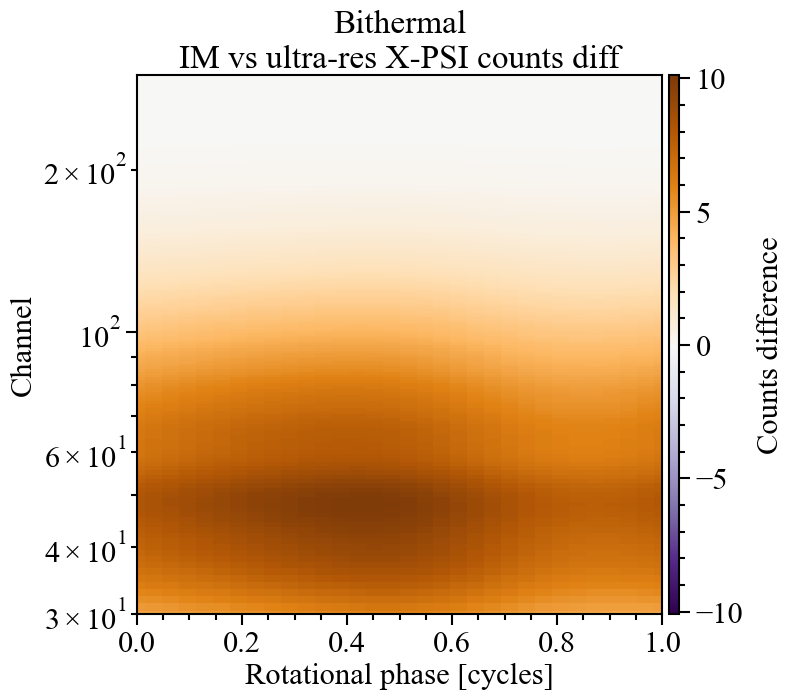

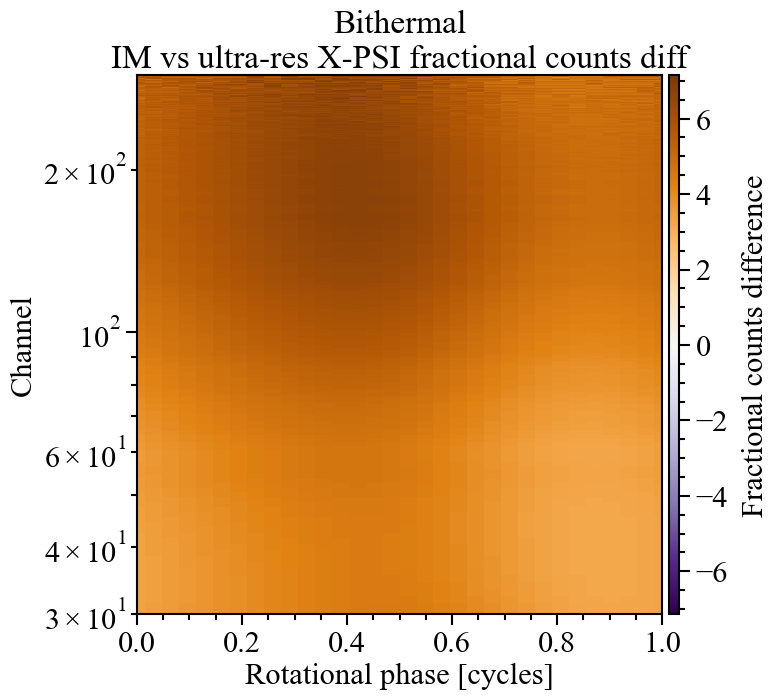

In [49]:
plot_pulse_profile(diff_Bithermal_UltraXPSI_and_IM_pulse_profile, 
                   r'Counts difference', r'Bithermal'+ '\n' + r'IM vs ultra-res X-PSI counts diff', 
                   norm='TwoSlope')

plot_pulse_profile(frac_diff_Bithermal_UltraXPSI_and_IM_pulse_profile, 
                   r'Fractional counts difference', r'Bithermal'+ '\n' + r'IM vs ultra-res X-PSI fractional counts diff', 
                   norm='TwoSlope')

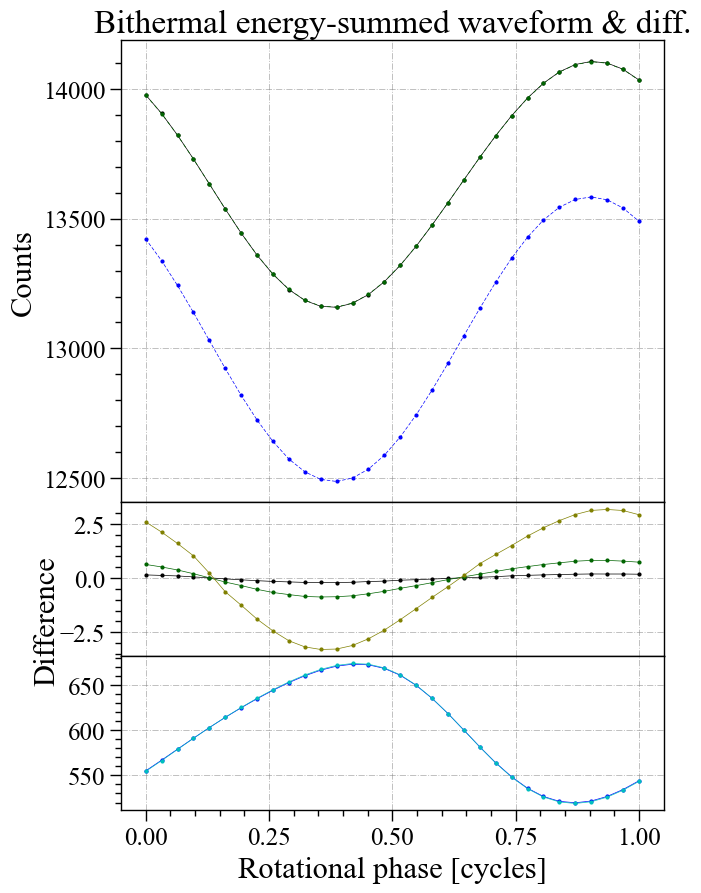

In [50]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(7, 10), sharex=True, gridspec_kw={'height_ratios': [3, 1, 1]})

axes[0].plot(np.linspace(0.0, 1.0, 32), Bithermal_UltraXPSI_energy_summed, 'o-', color='k', lw=0.5, markersize=2, label='Ultra X-PSI')
axes[0].plot(np.linspace(0.0, 1.0, 32), Bithermal_IM_energy_summed, 'o--', dashes=(5, 2.5), color='b', lw=0.5, markersize=2, label='IM')
axes[0].plot(np.linspace(0.0, 1.0, 32), Bithermal_StdXPSI_energy_summed, 'o--', dashes=(5, 5), color='darkgreen', lw=0.5, markersize=2, label='Std X-PSI')
# axes[0].plot(np.linspace(0.0, 1.0, 32), Bithermal_Alberta_energy_summed, 'o-', color='m', lw=0.5, markersize=2, label='Alberta')
axes[0].grid(linestyle="-.", color='grey',linewidth=0.7, alpha=0.5)
veneer(None, None, axes[0])
# legend_line_thickness(axes[0].legend())
axes[0].set_ylabel('Counts')
axes[0].set_title(r'Bithermal energy-summed waveform & diff.')

axes[1].plot(np.linspace(0.0, 1.0, 32), diff_Bithermal_UltraXPSI_and_HiXPSI, 'o-', color='k', lw=0.5, markersize=2, label='High vs ultra X-PSI')
axes[1].plot(np.linspace(0.0, 1.0, 32), diff_Bithermal_UltraXPSI_and_StdXPSI, 'o-', color='darkgreen', lw=0.5, markersize=2, label='Std vs ultra X-PSI')
axes[1].plot(np.linspace(0.0, 1.0, 32), diff_Bithermal_UltraXPSI_and_LowXPSI, 'o-', color='olive', lw=0.5, markersize=2, label='Low vs ultra X-PSI')
axes[1].grid(linestyle="-.", color='grey',linewidth=0.7, alpha=0.5)
veneer(None, None, axes[1])
# legend_line_thickness(axes[1].legend())

axes[2].plot(np.linspace(0.0, 1.0, 32), diff_Bithermal_UltraXPSI_and_IM, 'o-', color='b', lw=0.5, markersize=2, label='IM vs ultra X-PSI')
axes[2].plot(np.linspace(0.0, 1.0, 32), diff_Bithermal_StdXPSI_and_IM, 'o-', color='c', lw=0.5, markersize=2, label='IM vs std X-PSI')
axes[2].grid(linestyle="-.", color='grey',linewidth=0.7, alpha=0.5)
veneer(None, None, axes[2])
# legend_line_thickness(axes[2].legend())
## Shared y-axis label when only having two residual subplots
fig.text(0.0, 0.30, 'Difference', va='center', rotation='vertical')
axes[2].set_xlabel('Rotational phase [cycles]')
# axes[2].set_ylabel('Difference')
# axes[2].yaxis.labelpad = 25     # Adjust axis label position

plt.subplots_adjust(hspace=0)

### Figure 8 left panel

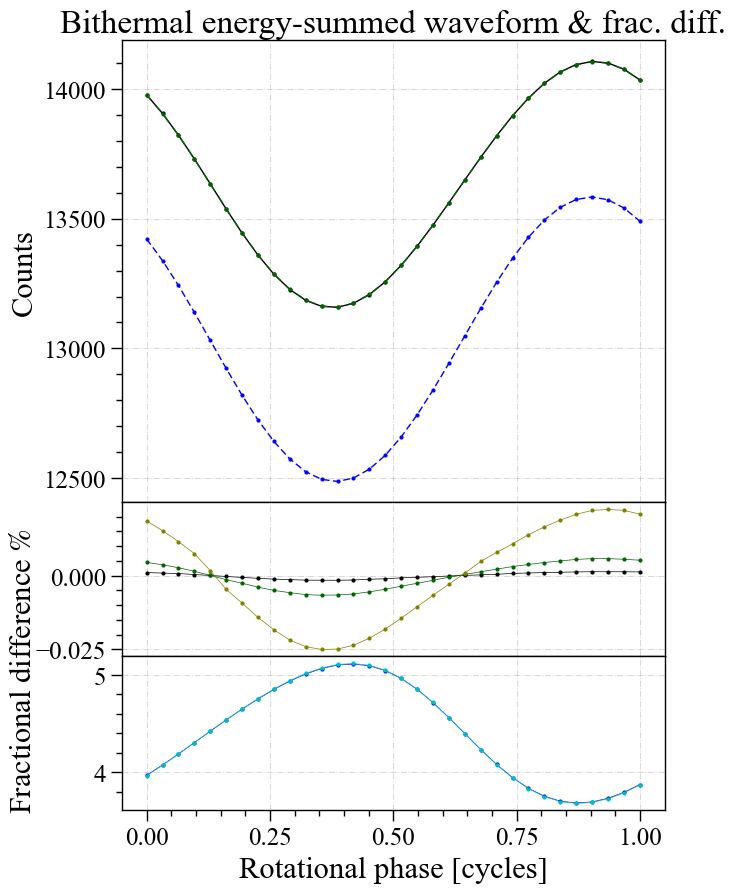

In [51]:
Bithermal_noise_norm = np.sum(Bithermal_UltraXPSI)/10**6
Bithermal_noise = (np.sqrt(Bithermal_UltraXPSI_energy_summed/Bithermal_noise_norm)/(Bithermal_UltraXPSI_energy_summed/Bithermal_noise_norm))*100

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(7, 10), sharex=True, gridspec_kw={'height_ratios': [3, 1, 1]})

axes[0].plot(np.linspace(0.0, 1.0, 32), Bithermal_UltraXPSI_energy_summed, 'o-', color='k', lw=1, markersize=2, label='Ultra X-PSI')
axes[0].plot(np.linspace(0.0, 1.0, 32), Bithermal_IM_energy_summed, 'o--', dashes=(5, 2.5), color='b', lw=1, markersize=2, label='IM')
axes[0].plot(np.linspace(0.0, 1.0, 32), Bithermal_StdXPSI_energy_summed, 'o--', dashes=(5, 5), color='darkgreen', lw=1, markersize=2, label='Std X-PSI')
# axes[0].plot(np.linspace(0.0, 1.0, 32), Bithermal_Alberta_energy_summed, 'o-', color='m', lw=0.5, markersize=2, label='Alberta')
axes[0].grid(linestyle="-.", color='grey',linewidth=0.7, alpha=0.3)
veneer(None, None, axes[0])
# legend_line_thickness(axes[0].legend())
#axes[0].ticklabel_format(axis='y', style='sci', scilimits=(0,0))  # Scientific notation used for y-axis
axes[0].set_ylabel('Counts')
axes[0].set_title(r'Bithermal energy-summed waveform & frac. diff.')

axes[1].plot(np.linspace(0.0, 1.0, 32), frac_diff_Bithermal_UltraXPSI_and_HiXPSI, 'o-', color='k', lw=0.5, markersize=2, label='High vs ultra X-PSI')
axes[1].plot(np.linspace(0.0, 1.0, 32), frac_diff_Bithermal_UltraXPSI_and_StdXPSI, 'o-', color='darkgreen', lw=0.5, markersize=2, label='Std vs ultra X-PSI')
axes[1].plot(np.linspace(0.0, 1.0, 32), frac_diff_Bithermal_UltraXPSI_and_LowXPSI, 'o-', color='olive', lw=0.5, markersize=2, label='Low vs ultra X-PSI')
# axes[1].plot(np.linspace(0.0, 1.0, 32), Bithermal_noise, '--', color='darkslategrey', lw=1, markersize=2)
# axes[1].plot(np.linspace(0.0, 1.0, 32), -Bithermal_noise, '--', color='darkslategrey', lw=1, markersize=2)
axes[1].grid(linestyle="-.", color='grey',linewidth=0.7, alpha=0.3)
veneer(None, None, axes[1])
# legend_line_thickness(axes[1].legend())
#axes[1].ticklabel_format(axis='y', style='sci', scilimits=(0,0))  # Scientific notation used for y-axis

axes[2].plot(np.linspace(0.0, 1.0, 32), frac_diff_Bithermal_UltraXPSI_and_IM, 'o-', color='b', lw=0.5, markersize=2, label='IM vs ultra X-PSI')
axes[2].plot(np.linspace(0.0, 1.0, 32), frac_diff_Bithermal_StdXPSI_and_IM, 'o-', color='c', lw=0.5, markersize=2, label='IM vs std X-PSI')
# axes[2].plot(np.linspace(0.0, 1.0, 32), Bithermal_noise, '--', color='darkslategrey', lw=1, markersize=2)
# axes[2].plot(np.linspace(0.0, 1.0, 32), -Bithermal_noise, '--', color='darkslategrey', lw=1, markersize=2)
axes[2].grid(linestyle="-.", color='grey',linewidth=0.7, alpha=0.3)
veneer(None, None, axes[2])
# legend_line_thickness(axes[2].legend())
## Shared y-axis label when only having two residual subplots
fig.text(-0.035, 0.25, 'Fractional difference $\%$', va='center', rotation='vertical')
axes[2].set_xlabel('Rotational phase [cycles]')
# axes[2].set_ylabel('frac_difference')
# axes[2].yaxis.labelpad = 25     # Adjust axis label position

plt.subplots_adjust(hspace=0)

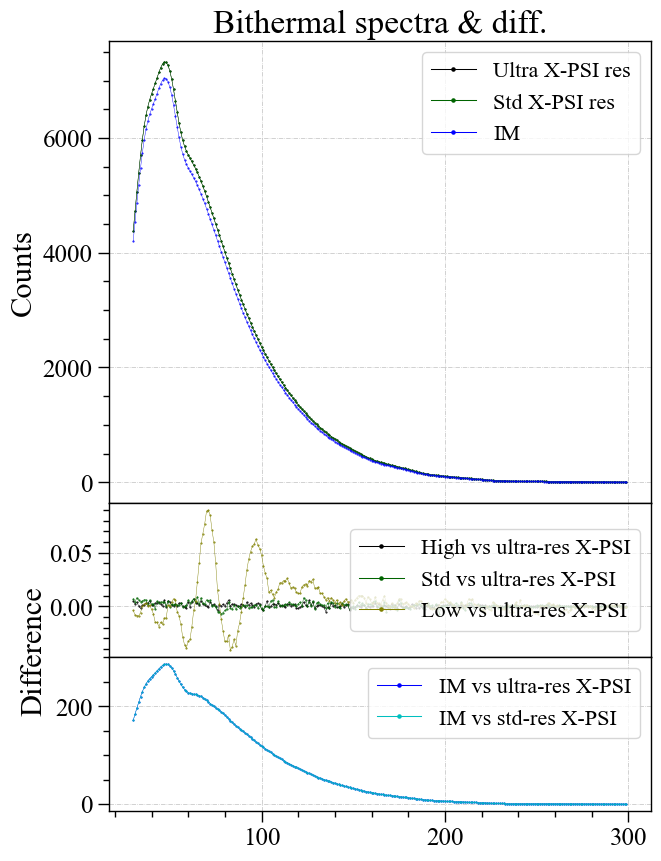

In [52]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(7, 10), sharex=True, gridspec_kw={'height_ratios': [3, 1, 1]})

axes[0].plot(Bithermal_UltraXPSI_spectrum[:, 0], Bithermal_UltraXPSI_spectrum[:, 1], 'o-', color='k', lw=0.3, markersize=0.5, label='Ultra X-PSI res')
axes[0].plot(Bithermal_UltraXPSI_spectrum[:, 0], Bithermal_StdXPSI_spectrum[:, 1], 'o-', color='darkgreen', lw=0.3, markersize=0.5, label='Std X-PSI res')
axes[0].plot(Bithermal_UltraXPSI_spectrum[:, 0], Bithermal_IM_spectrum[:, 1], 'o-', color='b', lw=0.3, markersize=0.5, label='IM')
# axes[0].plot(Bithermal_UltraXPSI_spectrum[:, 0], Bithermal_Alberta_spectrum[:, 1], 'o-', color='m', lw=0.3, markersize=0.5, label='Alberta')
axes[0].grid(linestyle="-.", color='grey',linewidth=0.5, alpha=0.5)
veneer(None, None, axes[0])
legend_line_thickness(axes[0].legend())
axes[0].set_ylabel('Counts')
axes[0].set_title(r'Bithermal spectra & diff.')

axes[1].plot(Bithermal_UltraXPSI_spectrum[:, 0], spec_diff_Bithermal_UltraXPSI_and_HiXPSI, 'o-', color='k', lw=0.3, markersize=0.5, label='High vs ultra-res X-PSI')
axes[1].plot(Bithermal_UltraXPSI_spectrum[:, 0], spec_diff_Bithermal_UltraXPSI_and_StdXPSI, 'o-', color='darkgreen', lw=0.3, markersize=0.5, label='Std vs ultra-res X-PSI')
axes[1].plot(Bithermal_UltraXPSI_spectrum[:, 0], spec_diff_Bithermal_UltraXPSI_and_LowXPSI, 'o-', color='olive', lw=0.3, markersize=0.5, label='Low vs ultra-res X-PSI')
axes[1].grid(linestyle="-.", color='grey',linewidth=0.5, alpha=0.5)
veneer(None, None, axes[1])
legend_line_thickness(axes[1].legend(loc='right'))

axes[2].plot(Bithermal_UltraXPSI_spectrum[:, 0], spec_diff_Bithermal_UltraXPSI_and_IM, 'o-', color='b', lw=0.3, markersize=0.5, label='IM vs ultra-res X-PSI')
axes[2].plot(Bithermal_UltraXPSI_spectrum[:, 0], spec_diff_Bithermal_StdXPSI_and_IM, 'o-', color='c', lw=0.3, markersize=0.5, label='IM vs std-res X-PSI')
axes[2].grid(linestyle="-.", color='grey',linewidth=0.5, alpha=0.5)
veneer(None, None, axes[2])
legend_line_thickness(axes[2].legend())
## Shared y-axis label when only having two residual subplots
fig.text(0.0, 0.27, 'Difference', va='center', rotation='vertical')
# axes[2].set_ylabel('Difference')
# axes[2].yaxis.labelpad = 15     # Adjust axis label position

plt.subplots_adjust(hspace=0)

### Figure 8 right panel

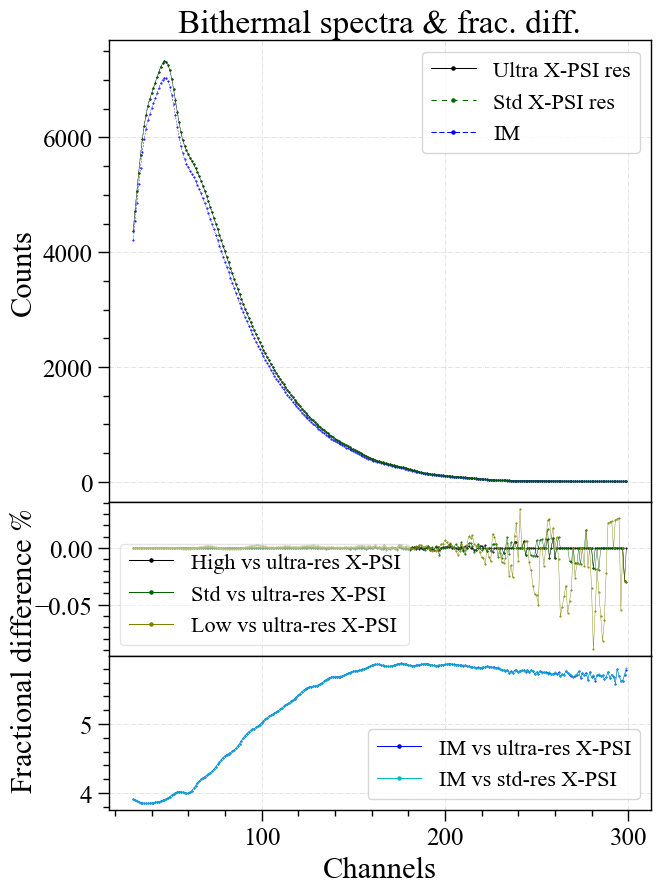

In [53]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(7, 10), sharex=True, gridspec_kw={'height_ratios': [3, 1, 1]})

l1, = axes[0].plot(Bithermal_UltraXPSI_spectrum[:, 0], Bithermal_UltraXPSI_spectrum[:, 1], 'o-', color='k', lw=0.3, markersize=0.5, label='Ultra X-PSI res')
l2, = axes[0].plot(Bithermal_UltraXPSI_spectrum[:, 0], Bithermal_IM_spectrum[:, 1], 'o--', dashes=(5, 2.5), color='b', lw=0.3, markersize=0.5, label='IM')
l3, = axes[0].plot(Bithermal_UltraXPSI_spectrum[:, 0], Bithermal_StdXPSI_spectrum[:, 1], 'o--', dashes=(5, 5), color='darkgreen', lw=0.3, markersize=0.5, label='Std X-PSI res')
# axes[0].plot(Bithermal_UltraXPSI_spectrum[:, 0], Bithermal_Alberta_spectrum[:, 1], 'o-', color='m', lw=0.3, markersize=0.5, label='Alberta')
axes[0].grid(linestyle="-.", color='grey',linewidth=0.5, alpha=0.3)
veneer(None, None, axes[0])
handles = [l1, l3, l2]
labels = [line.get_label() for line in handles]
legend_line_thickness(axes[0].legend(handles, labels))
#axes[0].ticklabel_format(axis='y', style='sci', scilimits=(0,0))  # Scientific notation used for y-axis
axes[0].set_ylabel('Counts')
axes[0].set_title(r'Bithermal spectra & frac. diff.')

axes[1].plot(Bithermal_UltraXPSI_spectrum[:, 0], spec_frac_diff_Bithermal_UltraXPSI_and_HiXPSI, 'o-', color='k', lw=0.3, markersize=0.5, label='High vs ultra-res X-PSI')
axes[1].plot(Bithermal_UltraXPSI_spectrum[:, 0], spec_frac_diff_Bithermal_UltraXPSI_and_StdXPSI, 'o-', color='darkgreen', lw=0.3, markersize=0.5, label='Std vs ultra-res X-PSI')
axes[1].plot(Bithermal_UltraXPSI_spectrum[:, 0], spec_frac_diff_Bithermal_UltraXPSI_and_LowXPSI, 'o-', color='olive', lw=0.3, markersize=0.5, label='Low vs ultra-res X-PSI')
axes[1].grid(linestyle="-.", color='grey',linewidth=0.5, alpha=0.3)
veneer(None, None, axes[1])
legend_line_thickness(axes[1].legend(loc='lower left', framealpha=0.5))
#axes[1].ticklabel_format(axis='y', style='sci', scilimits=(0,0))  # Scientific notation used for y-axis

axes[2].plot(Bithermal_UltraXPSI_spectrum[:, 0], spec_frac_diff_Bithermal_UltraXPSI_and_IM, 'o-', color='b', lw=0.3, markersize=0.5, label='IM vs ultra-res X-PSI')
axes[2].plot(Bithermal_UltraXPSI_spectrum[:, 0], spec_frac_diff_Bithermal_StdXPSI_and_IM, 'o-', color='c', lw=0.3, markersize=0.5, label='IM vs std-res X-PSI')
axes[2].grid(linestyle="-.", color='grey',linewidth=0.5, alpha=0.3)
veneer(None, None, axes[2])
legend_line_thickness(axes[2].legend())
## Shared y-axis label when only having two residual subplots
fig.text(-0.015, 0.27, 'Fractional difference $\%$', va='center', rotation='vertical')
axes[2].set_xlabel('Channels')
# axes[2].set_ylabel('Difference')
# axes[2].yaxis.labelpad = 15     # Adjust axis label position

plt.subplots_adjust(hspace=0)